# ML-решения для HR-отдела компании «Работа с заботой»

## Описание проекта <a class="tocSkip">

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

У вас будет несколько задач. **Первая задача** — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Ваша **вторая задача** — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

Импортируем необходимые библиотеки, объявим функции, зафиксируем рандомстейт.

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings

from scipy import stats as st
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder, 
    MinMaxScaler,
    StandardScaler
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import phik
import shap

In [8]:
def display_df_basic_info(df, count=5):
    display(df.head(count))
    display(df.info())


def display_scatterplot(data, x, y, ax, hue=None, alpha=0.5, title='', xlabel='', ylabel=''):
    sns.scatterplot(data=data, x=x, y=y, ax=ax, hue=hue, alpha=alpha)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.5, linestyle=':')


def get_smape(y_true, y_pred):
    n = len(y_true)
    return 100 * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) / n


def replace_segment_label(label, features):
    return '\n'.join(f'{features[ind]}={value}' for ind, value in enumerate(label.split('-')))

In [9]:
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [10]:
RANDOM_STATE = 42

Считаем CSV-файлы с данными и сохраним их в датафреймы. Изучим общую информацию о датафреймах.

In [12]:
csv_local_path = 'datasets/train_job_satisfaction_rate.csv'
csv_url = 'https://example.com/datasets/train_job_satisfaction_rate.csv'
if os.path.exists(csv_local_path):
    jsr_train = pd.read_csv(csv_local_path, index_col='id')
    
else:
    jsr_train = pd.read_csv(csv_url, index_col='id')

display_df_basic_info(jsr_train)

dept   level workload  employment_years last_year_promo  \
id                                                                      
155278       sales  junior   medium                 2              no   
653870          hr  junior     high                 2              no   
184592       sales  junior      low                 1              no   
171431  technology  junior      low                 4              no   
693419          hr  junior   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
155278                   no                      1   24000   
653870                   no                      5   38400   
184592                   no                      2   12000   
171431                   no                      2   18000   
693419                   no                      3   22800   

        job_satisfaction_rate  
id                             
155278                   0.58  
653870                   0.76  
184592                   0.11  
171431                   0.37  
693419                   0.20

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

In [13]:
csv_local_path = 'datasets/test_features.csv'
csv_url = 'https://example.com/datasets/test_features.csv'
if os.path.exists(csv_local_path):
    jsr_test_features = pd.read_csv(csv_local_path, index_col='id')
else:
    jsr_test_features = pd.read_csv(csv_url, index_col='id')

display_df_basic_info(jsr_test_features)

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

In [14]:
csv_local_path = 'datasets/test_target_job_satisfaction_rate.csv'
csv_url = 'https://example.com/datasets/test_target_job_satisfaction_rate.csv'
if os.path.exists(csv_local_path):
    jsr_test_target = pd.read_csv(csv_local_path, index_col='id')
else:
    jsr_test_target = pd.read_csv(csv_url, index_col='id')

display_df_basic_info(jsr_test_target)

job_satisfaction_rate
id                           
130604                   0.74
825977                   0.75
418490                   0.60
555320                   0.72
826430                   0.08

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


None

### Предобработка данных

In [16]:
jsr_train.index.duplicated().sum()

0

In [17]:
jsr_train.duplicated().sum()

245

В датафрейме с тренировочной выборкой есть явные дубликаты. Учтем при обучении моделей.

In [19]:
for col_name in jsr_train.select_dtypes(exclude='number').columns:
    display(f'{col_name}: {jsr_train[col_name].unique().tolist()}')

"dept: ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]"

"level: ['junior', 'middle', 'sinior', nan]"

"workload: ['medium', 'high', 'low']"

"last_year_promo: ['no', 'yes']"

"last_year_violations: ['no', 'yes']"

Скрытых дубликатов в датафрейме с тренировочной выборкой в значениях категориальных признаков не обнаружено.

In [21]:
jsr_train.isna().sum().loc[lambda x : x > 0]

dept     6
level    4
dtype: int64

Есть пропуски в данных в датафрейме с тренировочной выборкой. Заполним их в пайплайне при обучении модели.

Датафрейм `jsr_train` содержит данные о сотрудниках, предоставленные заказчиком (тренировочная выборка).

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Датафрейм `jsr_test_features` содержит входные признаки тестовой выборки.

Датафрейм `jsr_test_target` содержит целевой признак тестовой выборки.

### Исследовательский анализ данных

#### Тренировочная выборка

Посмотрим на числовое описание количественных признаков в датафрейме с тренировочной выборкой.

In [27]:
num_col_names = jsr_train.select_dtypes(include='number').columns
jsr_train[num_col_names].describe().T

count          mean           std       min       25%  \
employment_years       4000.0      3.718500      2.542513      1.00      2.00   
supervisor_evaluation  4000.0      3.476500      1.008812      1.00      3.00   
salary                 4000.0  33926.700000  14900.703838  12000.00  22800.00   
job_satisfaction_rate  4000.0      0.533995      0.225327      0.03      0.36   

                            50%       75%      max  
employment_years           3.00      6.00     10.0  
supervisor_evaluation      4.00      4.00      5.0  
salary                 30000.00  43200.00  98400.0  
job_satisfaction_rate      0.56      0.71      1.0

Изучим распределения непрерывных количественных признаков в датафрейме с тренировочной выборкой.

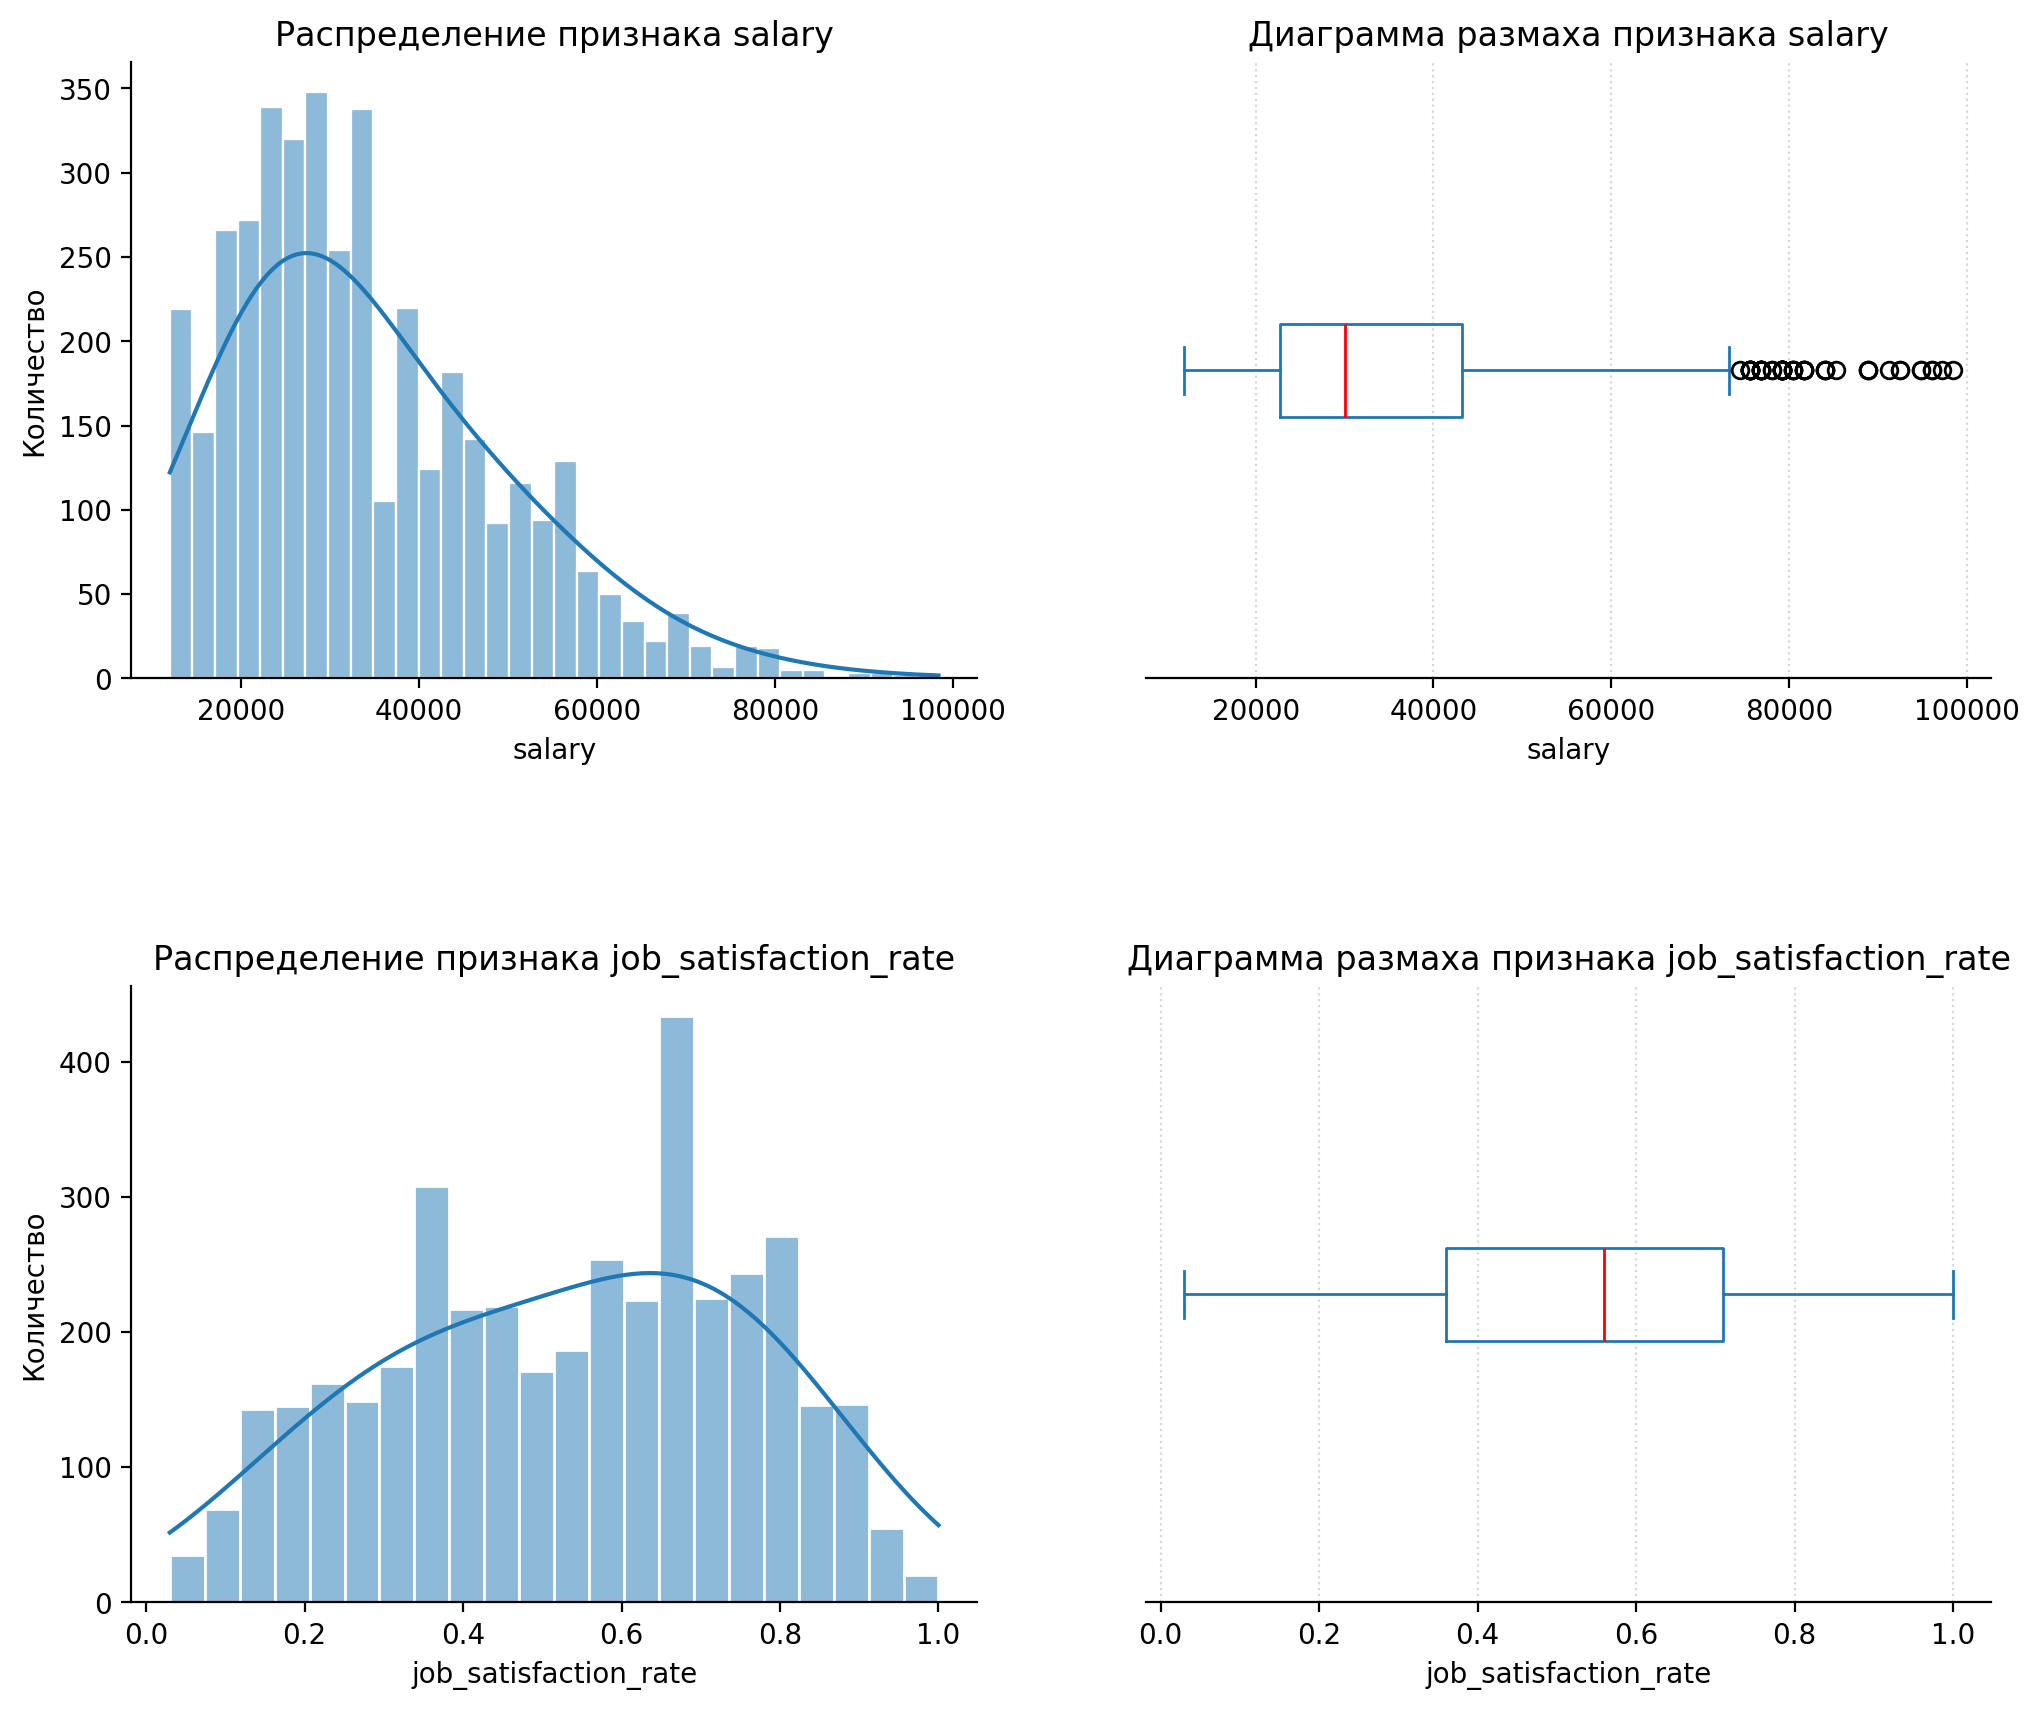

In [29]:
continuous_col_names = ['salary', 'job_satisfaction_rate']

n = len(continuous_col_names)
fig, axes = plt.subplots(n, 2, figsize=(12, n * 5))
fig.subplots_adjust(hspace=0.5)

for ind, col_name in enumerate(continuous_col_names):
    ax1, ax2 = axes[ind, 0], axes[ind, 1]

    sns.histplot(data=jsr_train, x=col_name, ax=ax1, kde=True, kde_kws={'bw_method': 0.6}, edgecolor='white')
    ax1.set_title(f'Распределение признака {col_name}')
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Количество')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    jsr_train[col_name].plot(kind='box', vert=False, ax=ax2, medianprops={'color': 'red'})
    ax2.set_title(f'Диаграмма размаха признака {col_name}')
    ax2.set_xlabel(col_name)
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.grid(axis='x', alpha=0.5, linestyle=':')
    
plt.show()

В признаке `salary` с ежемесячной зарплатой сотрудника есть выбросы с высокими значениями. Распределение целевого признака `job_satisfaction_rate` с уровенем удовлетворённости сотрудника имеет несколько пиков, то есть по целевому признаку сотрудники разделены на несколько групп.

Изучим распределения дискретных количественных признаков в датафрейме с тренировочной выборкой.

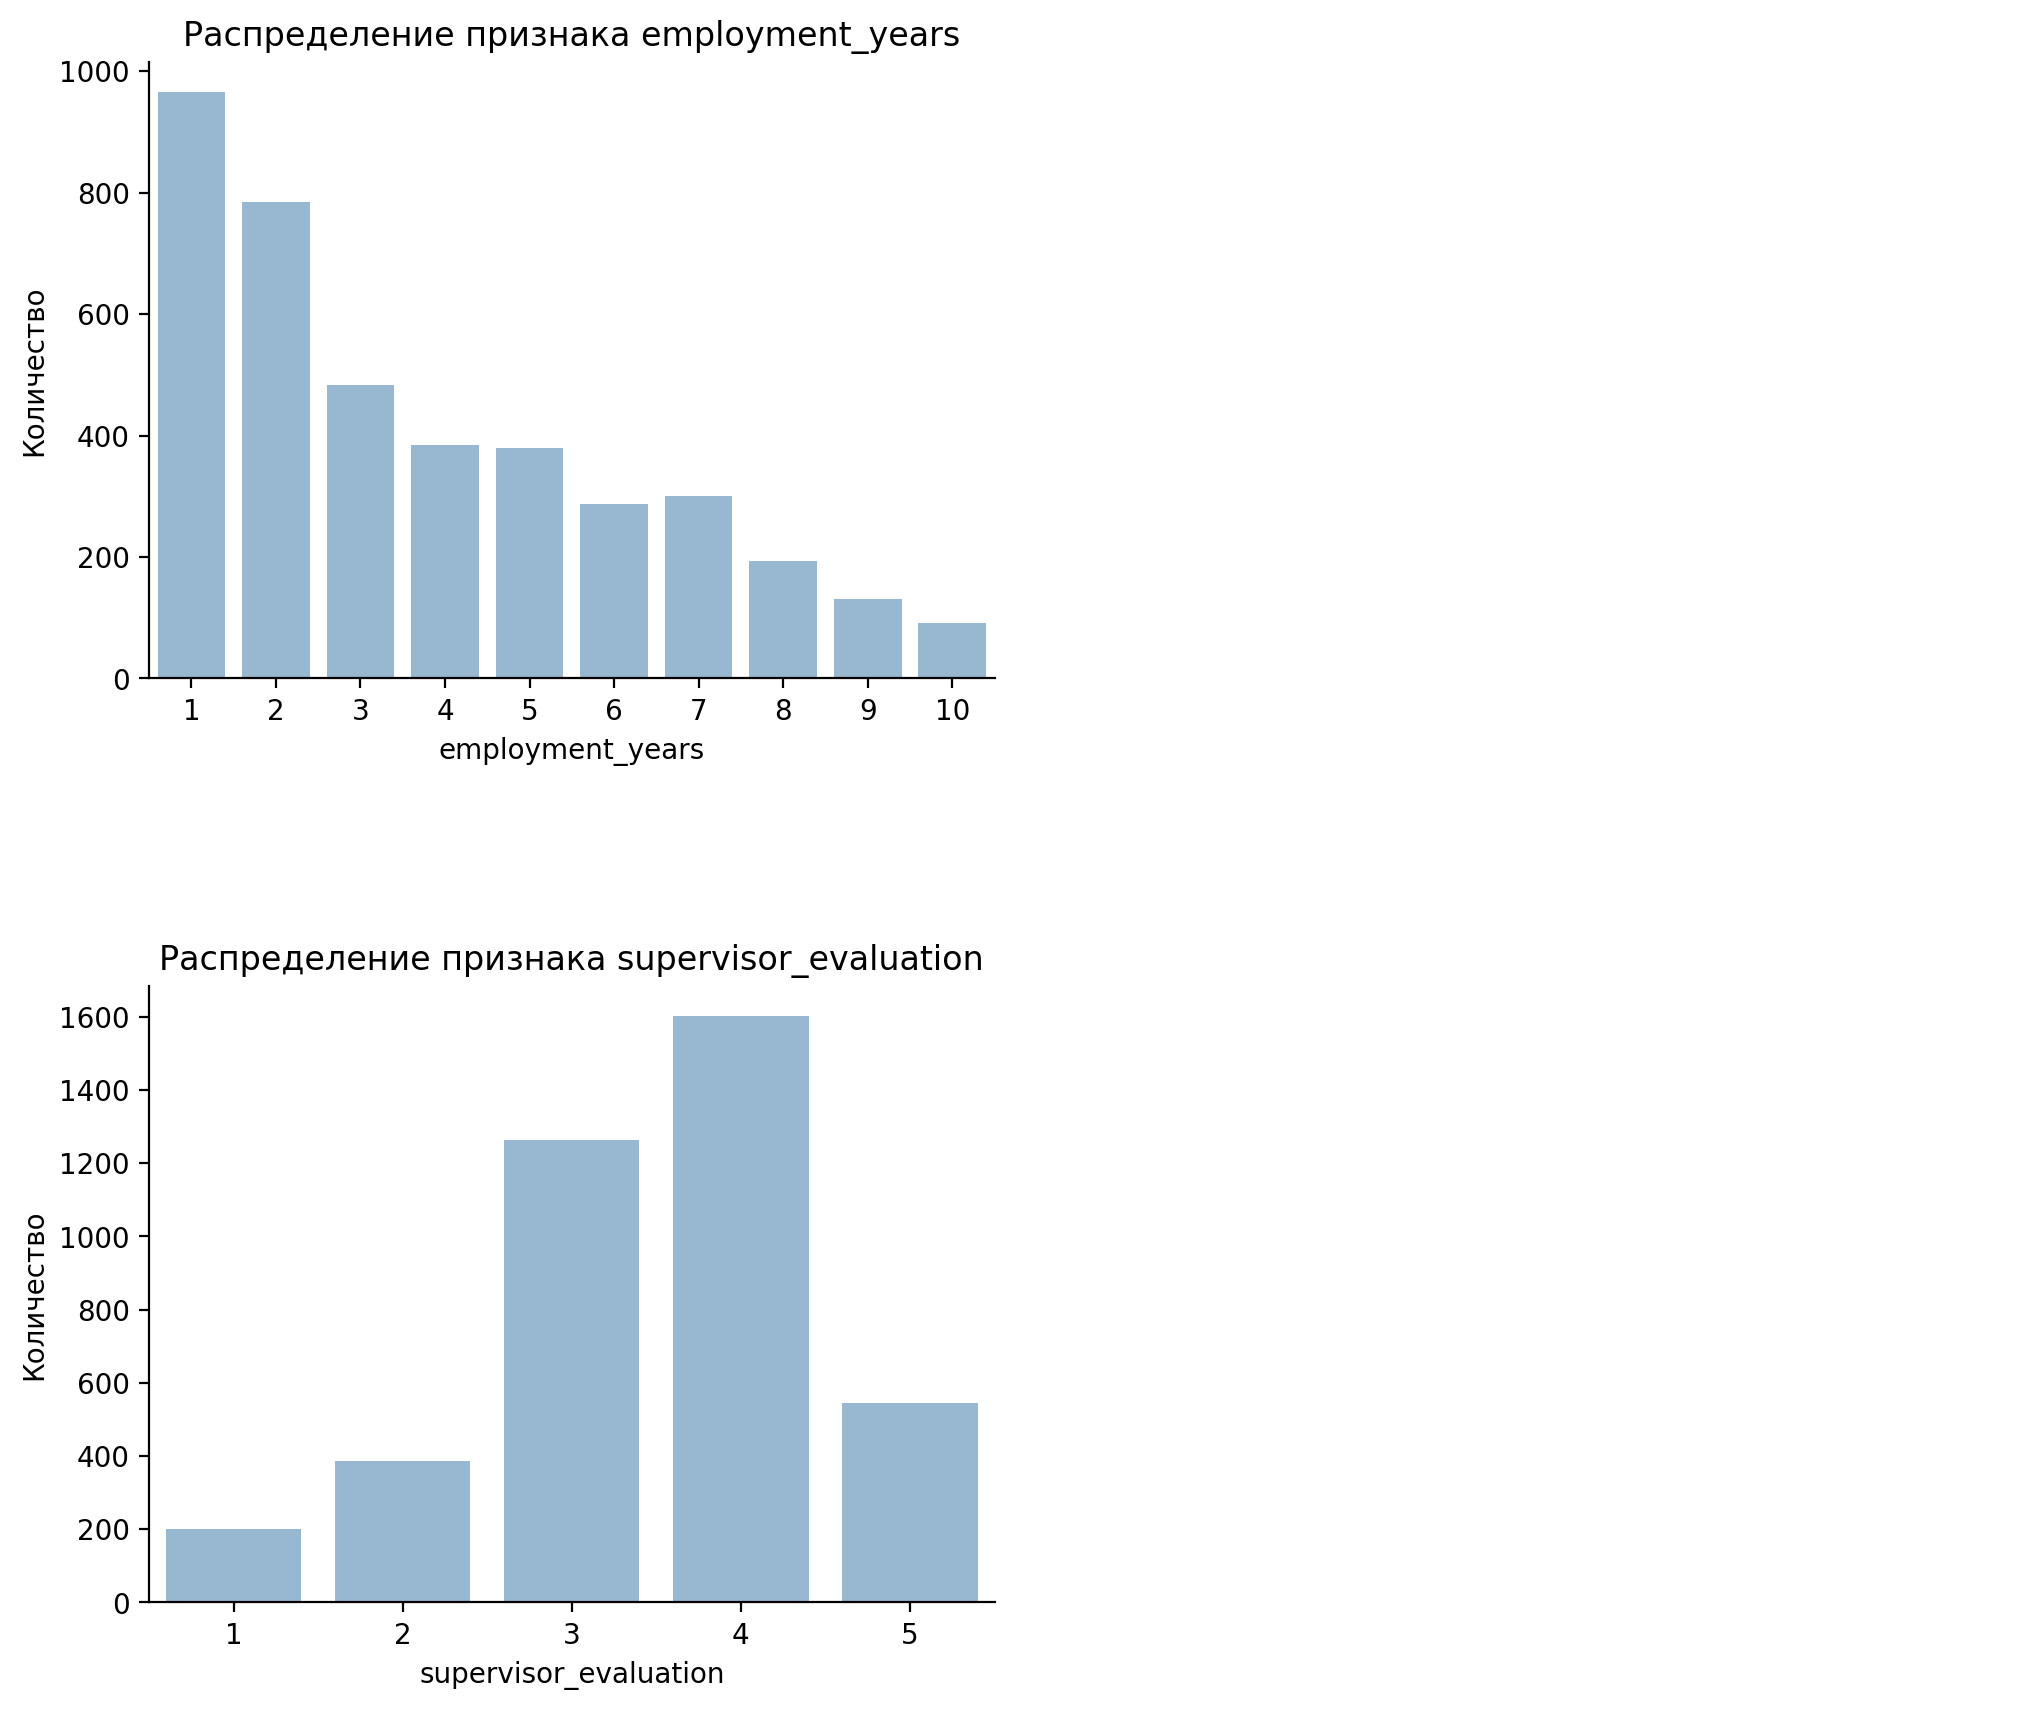

In [32]:
discrete_col_names = ['employment_years', 'supervisor_evaluation']

n = len(discrete_col_names)
fig, axes = plt.subplots(n, 2, figsize=(12, n * 5))
fig.subplots_adjust(hspace=0.5)

for ind, col_name in enumerate(discrete_col_names):
    ax1, ax2 = axes[ind, 0], axes[ind, 1]

    sns.countplot(data=jsr_train, x=col_name, ax=ax1, color='#8ebad9')
    ax1.set_title(f'Распределение признака {col_name}')
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Количество')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    ax2.set_axis_off()

plt.show()

Изучим распределения категориальных признаков в датафрейме с тренировочной выборкой.

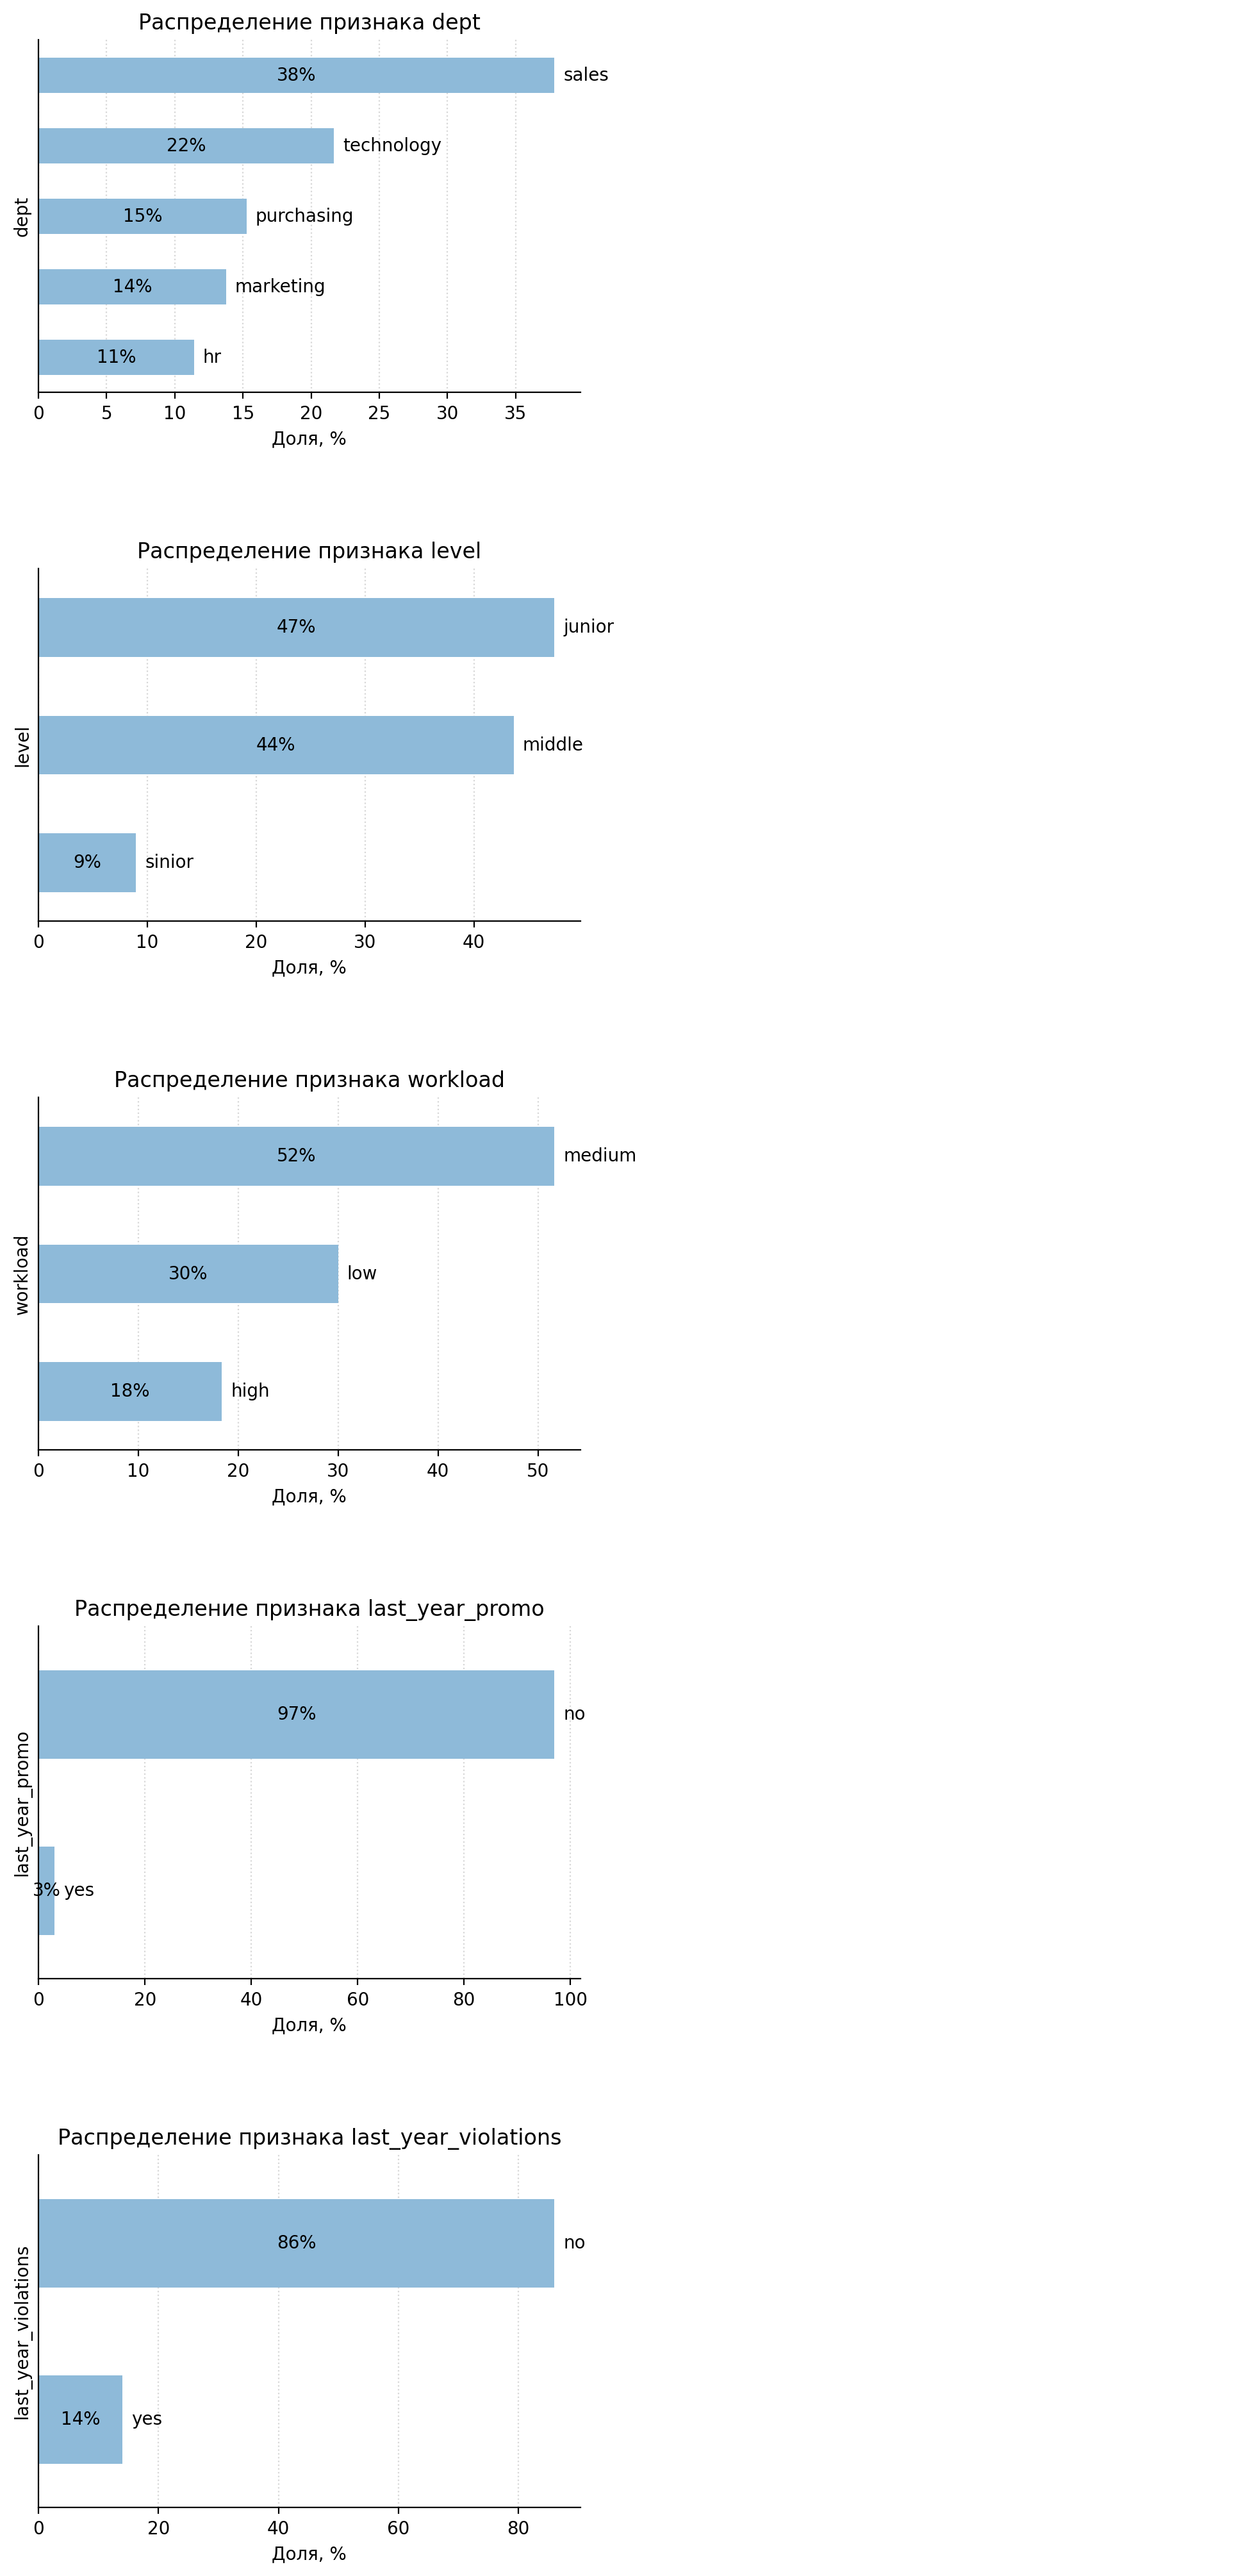

In [34]:
cat_col_names = jsr_train.select_dtypes(exclude='number').columns

n = len(cat_col_names)
fig, axes = plt.subplots(n, 2, figsize=(12, n * 5))
fig.subplots_adjust(hspace=0.5)

for ind, col_name in enumerate(cat_col_names):
    ax1, ax2 = axes[ind, 0], axes[ind, 1]

    col = jsr_train[col_name].value_counts(normalize=True).sort_values() * 100
    col.plot(kind='barh', ax=ax1, color='#8ebad9')
    ax1.bar_label(axes[ind, 0].containers[0], fmt='%.0f%%', label_type='center')
    ax1.bar_label(axes[ind, 0].containers[0], labels=col.index, label_type='edge', padding=5)
    ax1.set_title(f'Распределение признака {col_name}')
    ax1.set_xlabel('Доля, %')
    ax1.set_yticks([])
    ax1.set_axisbelow(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='x', alpha=0.5, linestyle=':')
    
    ax2.set_axis_off()

plt.show()

Можно отметить несколько фактов:
- В датафрейме с тренировочной выборкой содержится больше всего записей о сотрудниках из отдела продаж. В случае, если перед нами стратифицированная выборка, можно сделать вывод о том, что отдел продаж самый многочисленный.
- Сильный дисбаланс классов наблюдается у признаков `last_year_promo` и `last_year_violations`, то есть малое число сотрудников получили повышение за последний год или нарушили трудовой договор за последний год. 

Рассчитаем коэффициенты корреляции Фи между всеми признаками в датафрейме с тренировочной выборкой. Посмотрим тепловую карту матрицы корреляций.

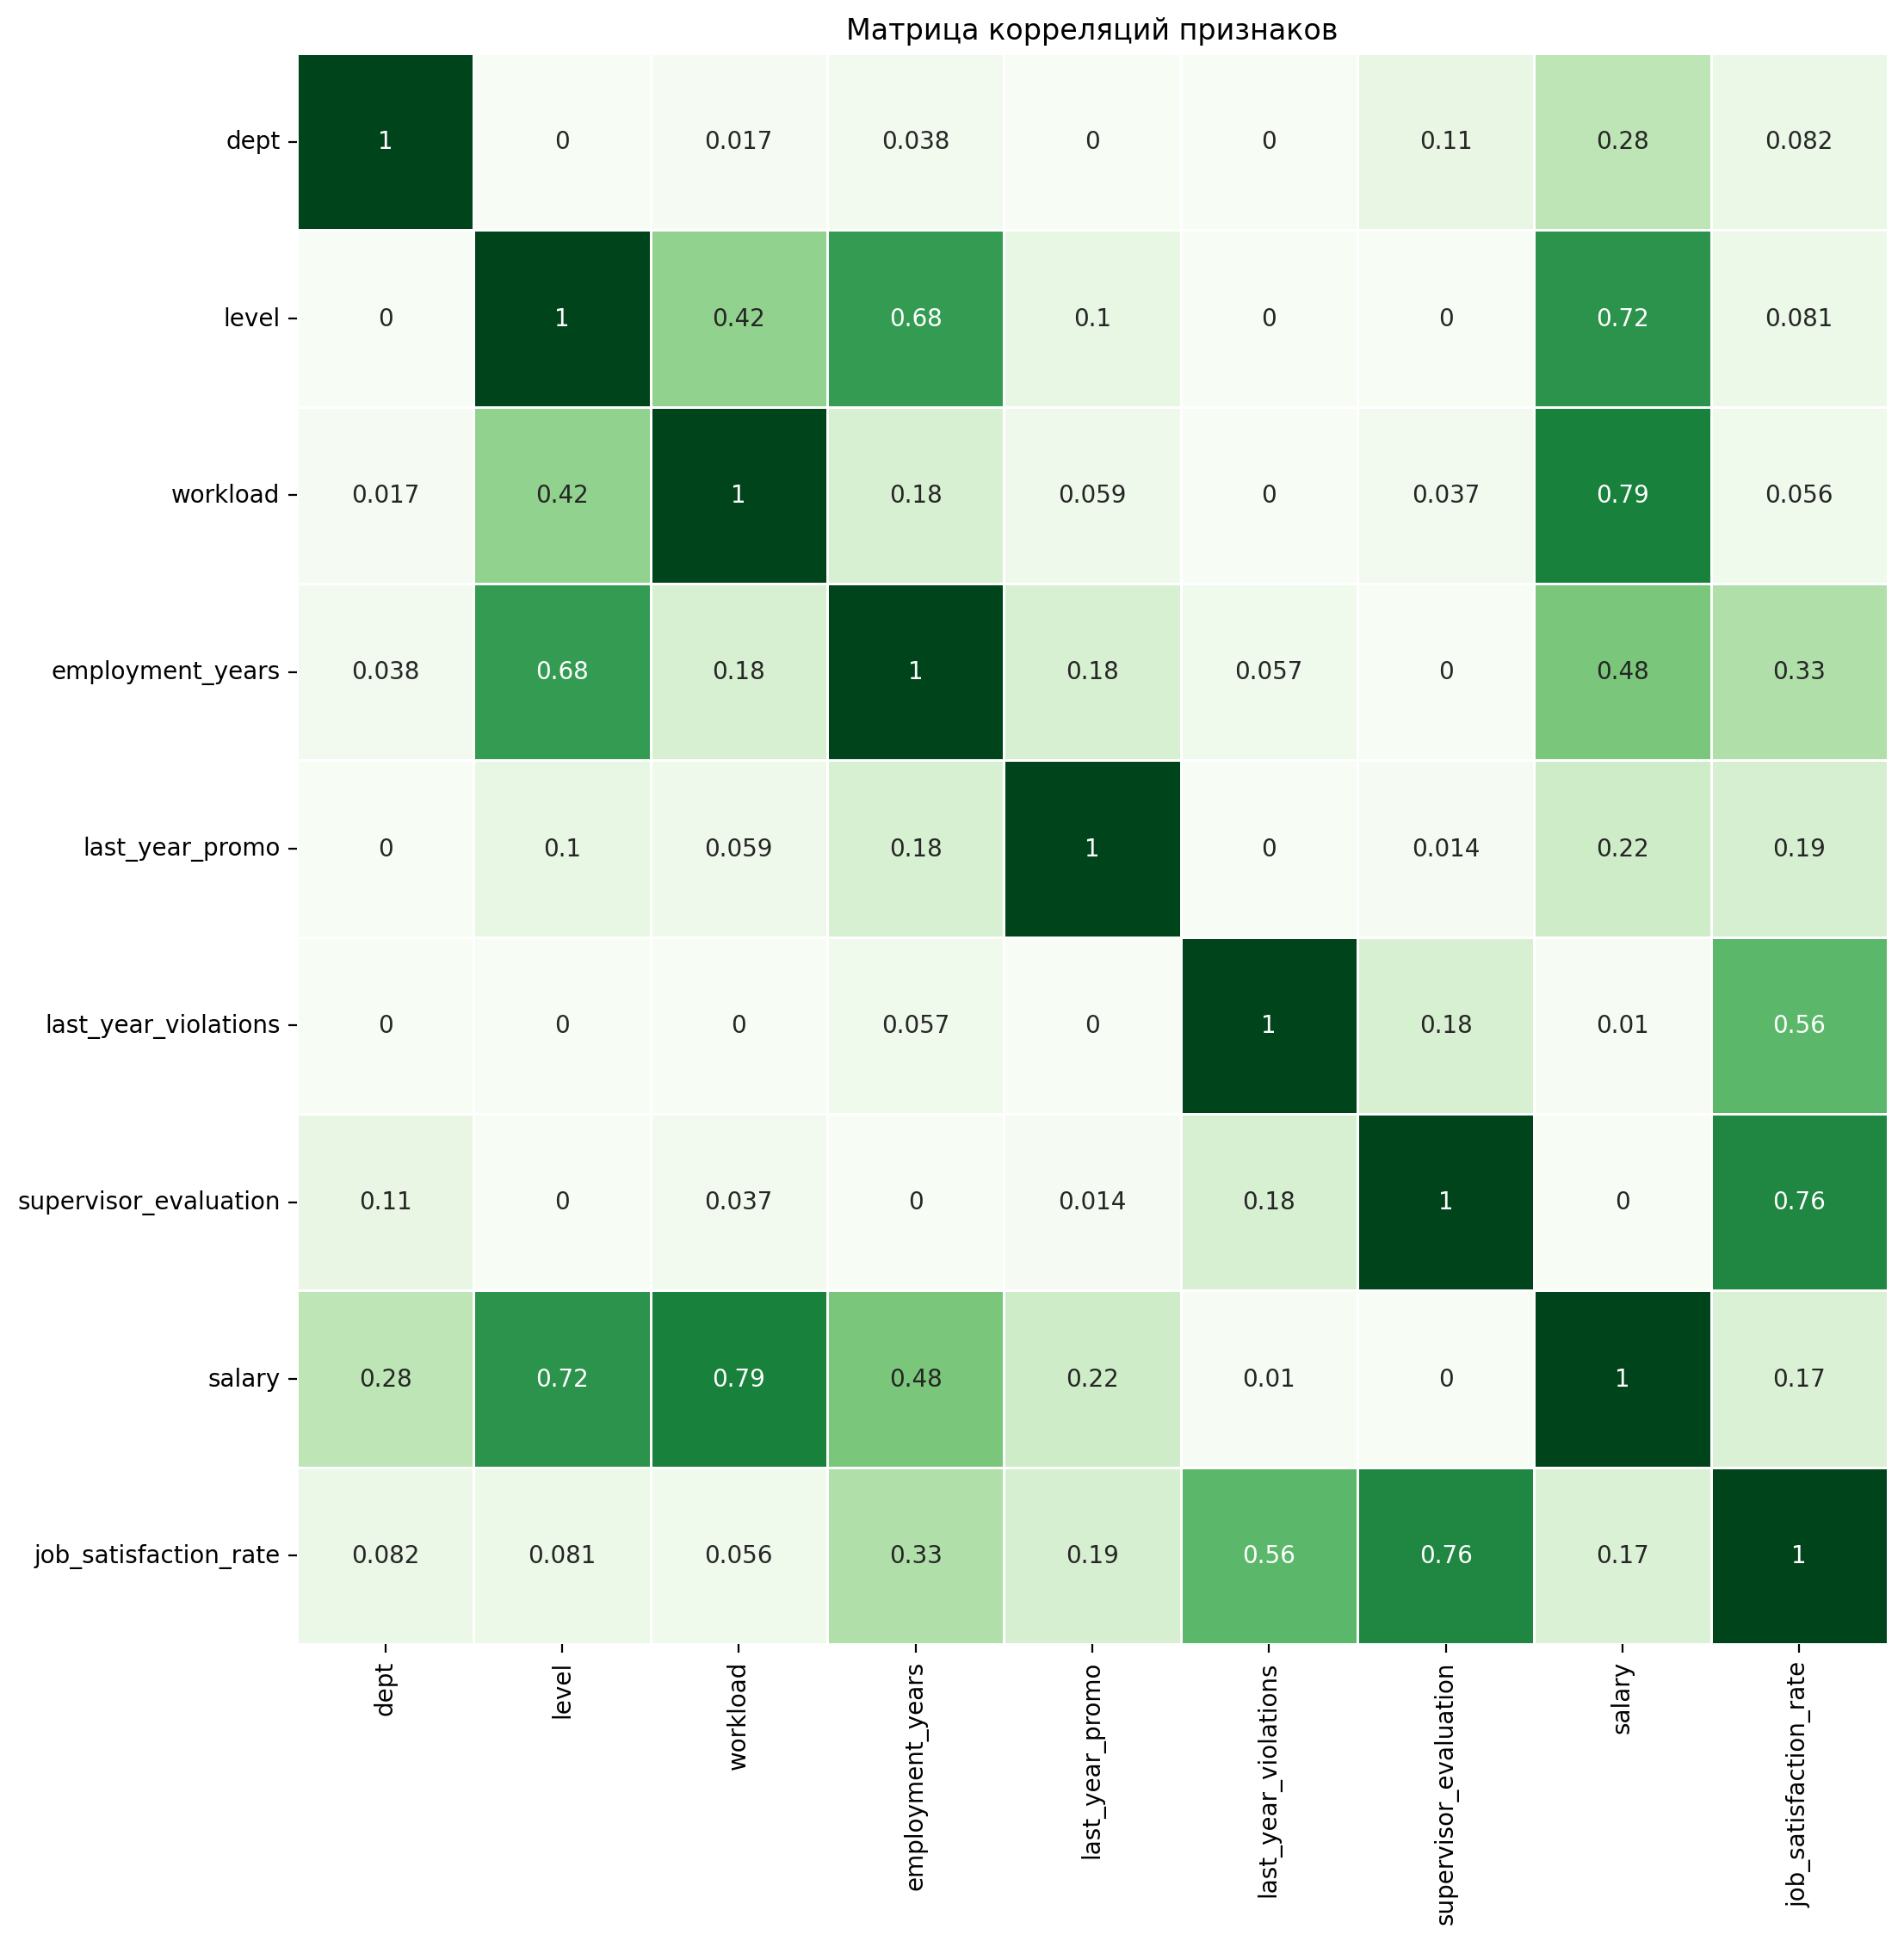

In [37]:
interval_col_names = ['salary', 'job_satisfaction_rate']
corr_coefficients = jsr_train.phik_matrix(interval_cols=interval_col_names)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(corr_coefficients, annot=True, square=True, cbar=False, linewidths=0.5, cmap='Greens', ax=ax)
ax.set_title('Матрица корреляций признаков')
plt.show()

Мультиколлинеарности, которая может негативно повлиять на качество моделей, не наблюдается. При этом можно отметить, что:
- Признаки `level` (уровень занимаемой должности), `employment_years` (длительность работы в компании) и `salary` (ежемесячная зарплата сотрудника) имеют высокую взаимосвязь.
- С целевым признаком `job_satisfaction_rate` с уровенем удовлетворённости сотрудника более других коррелируют признаки `supervisor_evaluation` (оценка качества работы сотрудника, которую дал руководитель) и `last_year_violations` (нарушал ли сотрудник трудовой договор за последний год).

Посмотрим на друаграммы рассеяния количественных признаков с целевым.

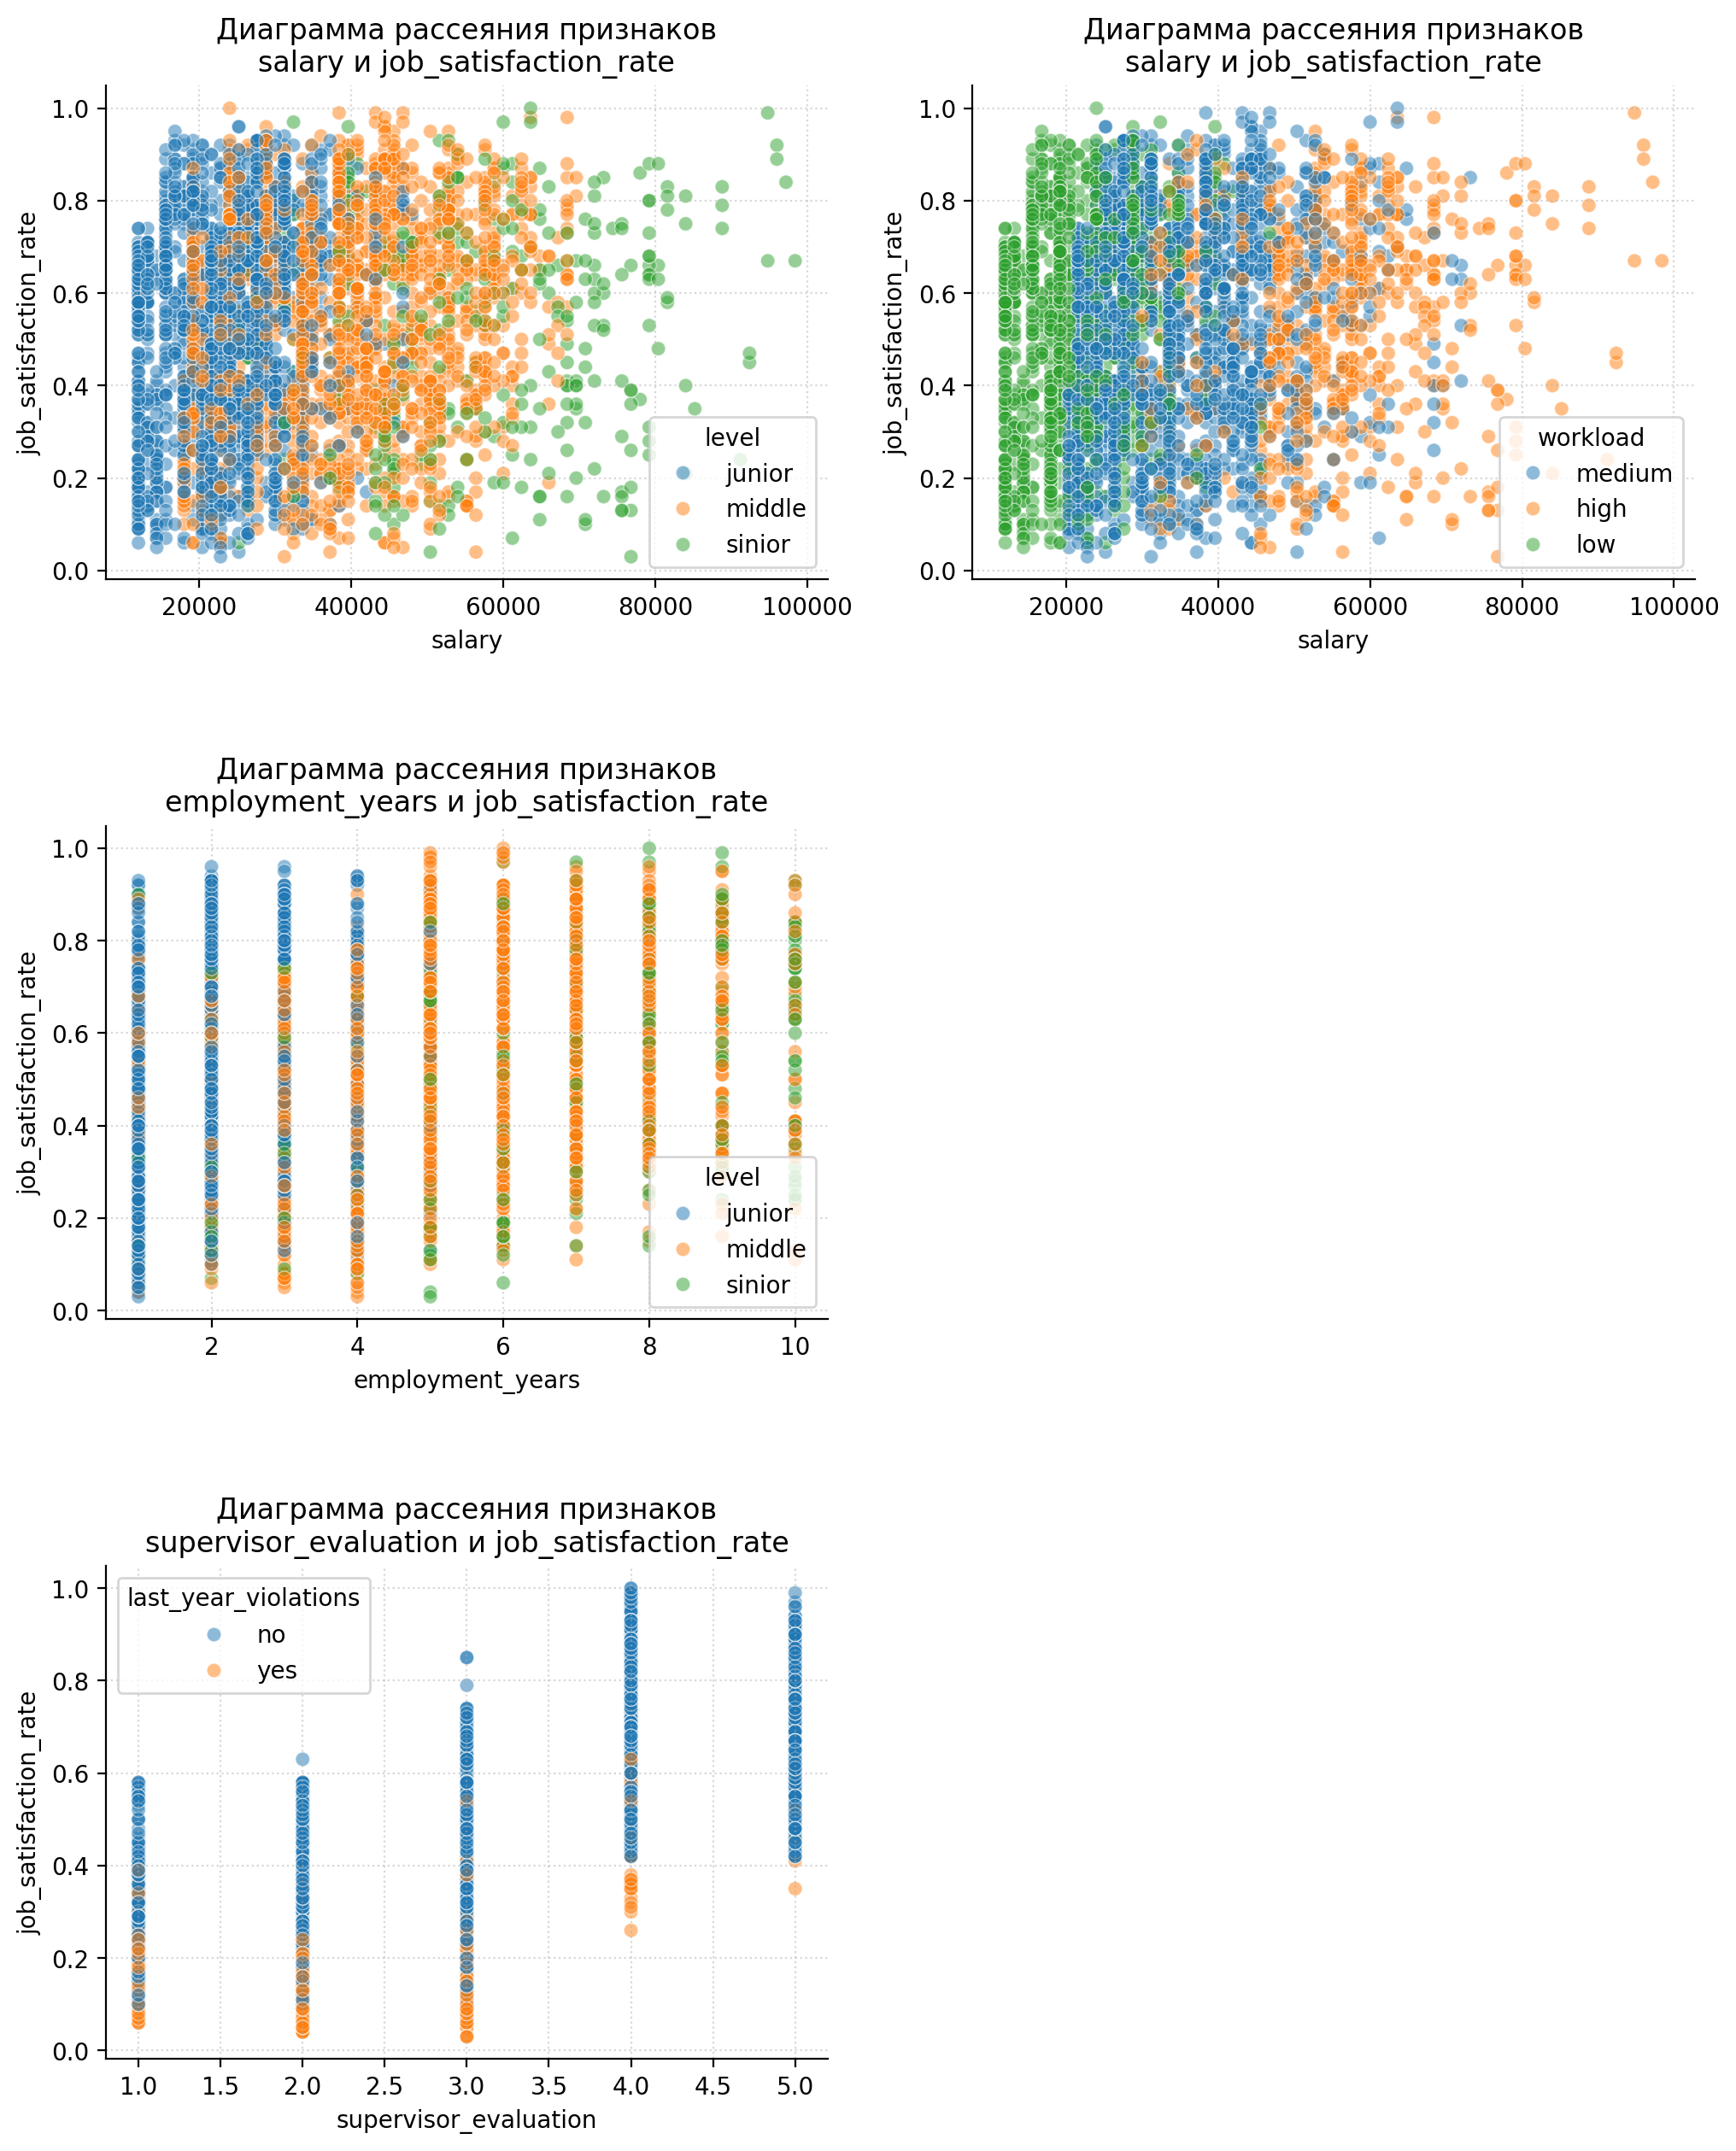

In [40]:
fig, axes = plt.subplots(3, 2, figsize=(12, 3 * 5))
fig.subplots_adjust(hspace=0.5)

display_scatterplot(jsr_train, 'salary', 'job_satisfaction_rate', axes[0][0], hue='level', alpha=0.5, 
                    title='Диаграмма рассеяния признаков\nsalary и job_satisfaction_rate', 
                    xlabel='salary', ylabel='job_satisfaction_rate')
display_scatterplot(jsr_train, 'salary', 'job_satisfaction_rate', axes[0][1], hue='workload', alpha=0.5, 
                    title='Диаграмма рассеяния признаков\nsalary и job_satisfaction_rate', 
                    xlabel='salary', ylabel='job_satisfaction_rate')
display_scatterplot(jsr_train, 'employment_years', 'job_satisfaction_rate', axes[1][0], hue='level', alpha=0.5, 
                    title='Диаграмма рассеяния признаков\nemployment_years и job_satisfaction_rate', 
                    xlabel='employment_years', ylabel='job_satisfaction_rate')
display_scatterplot(jsr_train, 'supervisor_evaluation', 'job_satisfaction_rate', axes[2][0], 
                    hue='last_year_violations', alpha=0.5, 
                    title='Диаграмма рассеяния признаков\nsupervisor_evaluation и job_satisfaction_rate', 
                    xlabel='supervisor_evaluation', ylabel='job_satisfaction_rate')
axes[1][1].set_axis_off()
axes[2][1].set_axis_off()
plt.show()

Посмотрим на уровень удовлетворённости сотрудника работой в компании в различных сегментах.

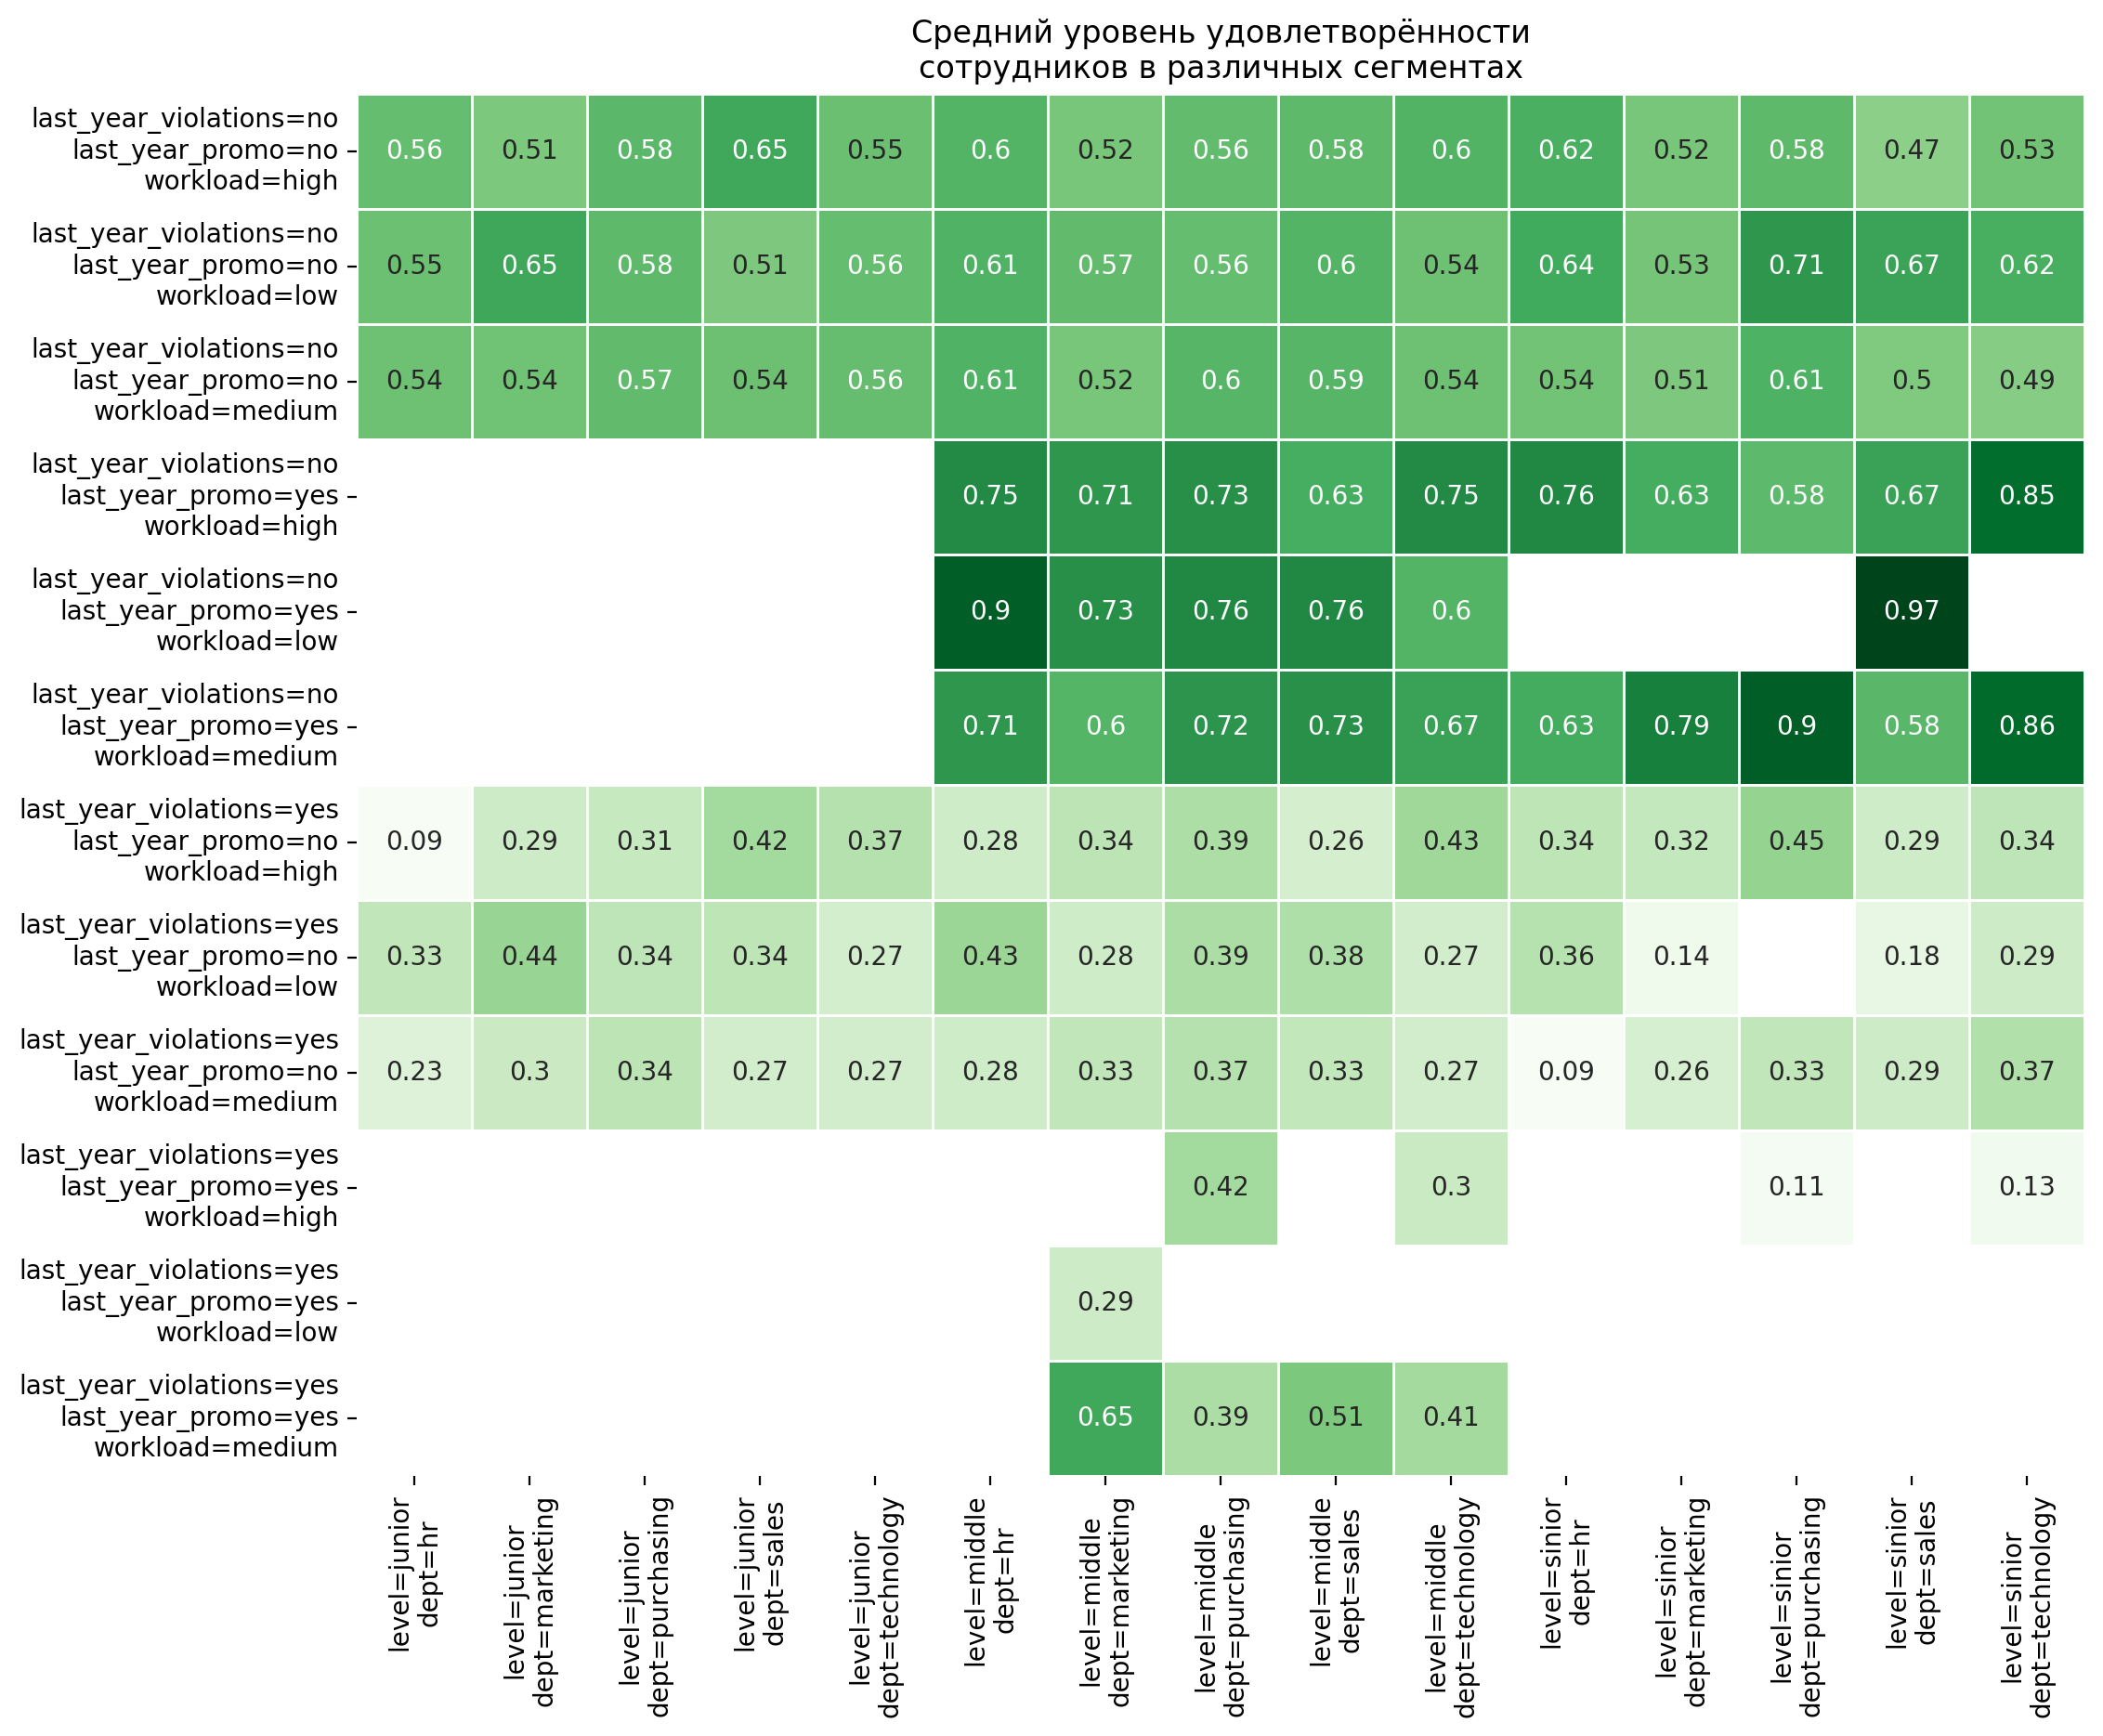

In [42]:
x_col_names = ['level', 'dept']
y_col_names = ['last_year_violations', 'last_year_promo', 'workload']
segments = jsr_train.pivot_table(index=y_col_names, columns=x_col_names, values='job_satisfaction_rate')

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(segments, annot=True, square=True, cbar=False, linewidths=0.5, cmap='Greens', ax=ax)
ax.set_title('Cредний уровень удовлетворённости\nсотрудников в различных сегментах')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(map(lambda x: replace_segment_label(x.get_text(), x_col_names), ax.get_xticklabels()))
ax.set_yticklabels(map(lambda y: replace_segment_label(y.get_text(), y_col_names), ax.get_yticklabels()))
plt.show()

Можно отметить, что:
- средний уровень удовлетворённости значительно выше у сотрудников, получивших повышение за последний год.
- средний уровень удовлетворённости значительно ниже у сотрудников, нарушивших трудовой договор за последний год.

#### Тестовая выборка

Сравним распределения количественных признаков в тренировочной и тестовой выборках.

In [46]:
num_col_names = ['employment_years', 'supervisor_evaluation', 'salary']

describe_train = jsr_train[num_col_names].describe().T.reset_index(names='признак')
describe_train['выборка'] = 'тренировочная'

describe_test = jsr_test_features[num_col_names].describe().T.reset_index(names='признак')
describe_test['выборка'] = 'тестовая'

displayed_col_names = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
pd.concat([describe_train, describe_test]).pivot_table(index=['признак', 'выборка'], aggfunc='first')[displayed_col_names]

mean           std      min  \
признак               выборка                                            
employment_years      тестовая           3.6665      2.537222      1.0   
                      тренировочная      3.7185      2.542513      1.0   
salary                тестовая       34066.8000  15398.436729  12000.0   
                      тренировочная  33926.7000  14900.703838  12000.0   
supervisor_evaluation тестовая           3.5265      0.996892      1.0   
                      тренировочная      3.4765      1.008812      1.0   

                                         25%      50%      75%      max  
признак               выборка                                            
employment_years      тестовая           1.0      3.0      6.0     10.0  
                      тренировочная      2.0      3.0      6.0     10.0  
salary                тестовая       22800.0  30000.0  43200.0  96000.0  
                      тренировочная  22800.0  30000.0  43200.0  98400.0  
supervisor_evaluation тестовая           3.0      4.0      4.0      5.0  
                      тренировочная      3.0      4.0      4.0      5.0

Существенных различий в части распределений количественных признаков нет.

In [48]:
cat_col_names = jsr_train.select_dtypes(exclude='number').columns

feature_values = pd.DataFrame(columns=['признак', 'выборка', 'значения'])
for col_name in cat_col_names:
    feature_values.loc[len(feature_values)] = [col_name, 'тренировочная', 
                                               ', '.join(sorted(f"'{x}'" for x in jsr_train[col_name].unique()))]
    feature_values.loc[len(feature_values)] = [col_name, 'тестовая', 
                                               ', '.join(sorted(f"'{x}'" for x in jsr_test_features[col_name].unique()))]
feature_values.pivot_table(index=['признак', 'выборка'], aggfunc='first')

значения
признак              выборка                                                                          
dept                 тестовая       ' ', 'hr', 'marketing', 'nan', 'purchasing', 'sales', 'technology'
                     тренировочная       'hr', 'marketing', 'nan', 'purchasing', 'sales', 'technology'
last_year_promo      тестовая                                                              'no', 'yes'
                     тренировочная                                                         'no', 'yes'
last_year_violations тестовая                                                              'no', 'yes'
                     тренировочная                                                         'no', 'yes'
level                тестовая                                      'junior', 'middle', 'nan', 'sinior'
                     тренировочная                                 'junior', 'middle', 'nan', 'sinior'
workload             тестовая                                             ' ', 'high', 'low', 'medium'
                     тренировочная                                             'high', 'low', 'medium'

Отличий в значениях категориальных признаков нет. В тестовой выборке есть пропуски в значениях признаков `dept` и `level`, а также пробелы в значениях признаков `dept` и `workload` — учтем при подготовке признаков в пайплайне.

Сравним коэффициенты корреляции Фи между всеми признаками в датафреймах с тренировочной и тестовой выборками. Посмотрим тепловую карту разницы матриц корреляций.

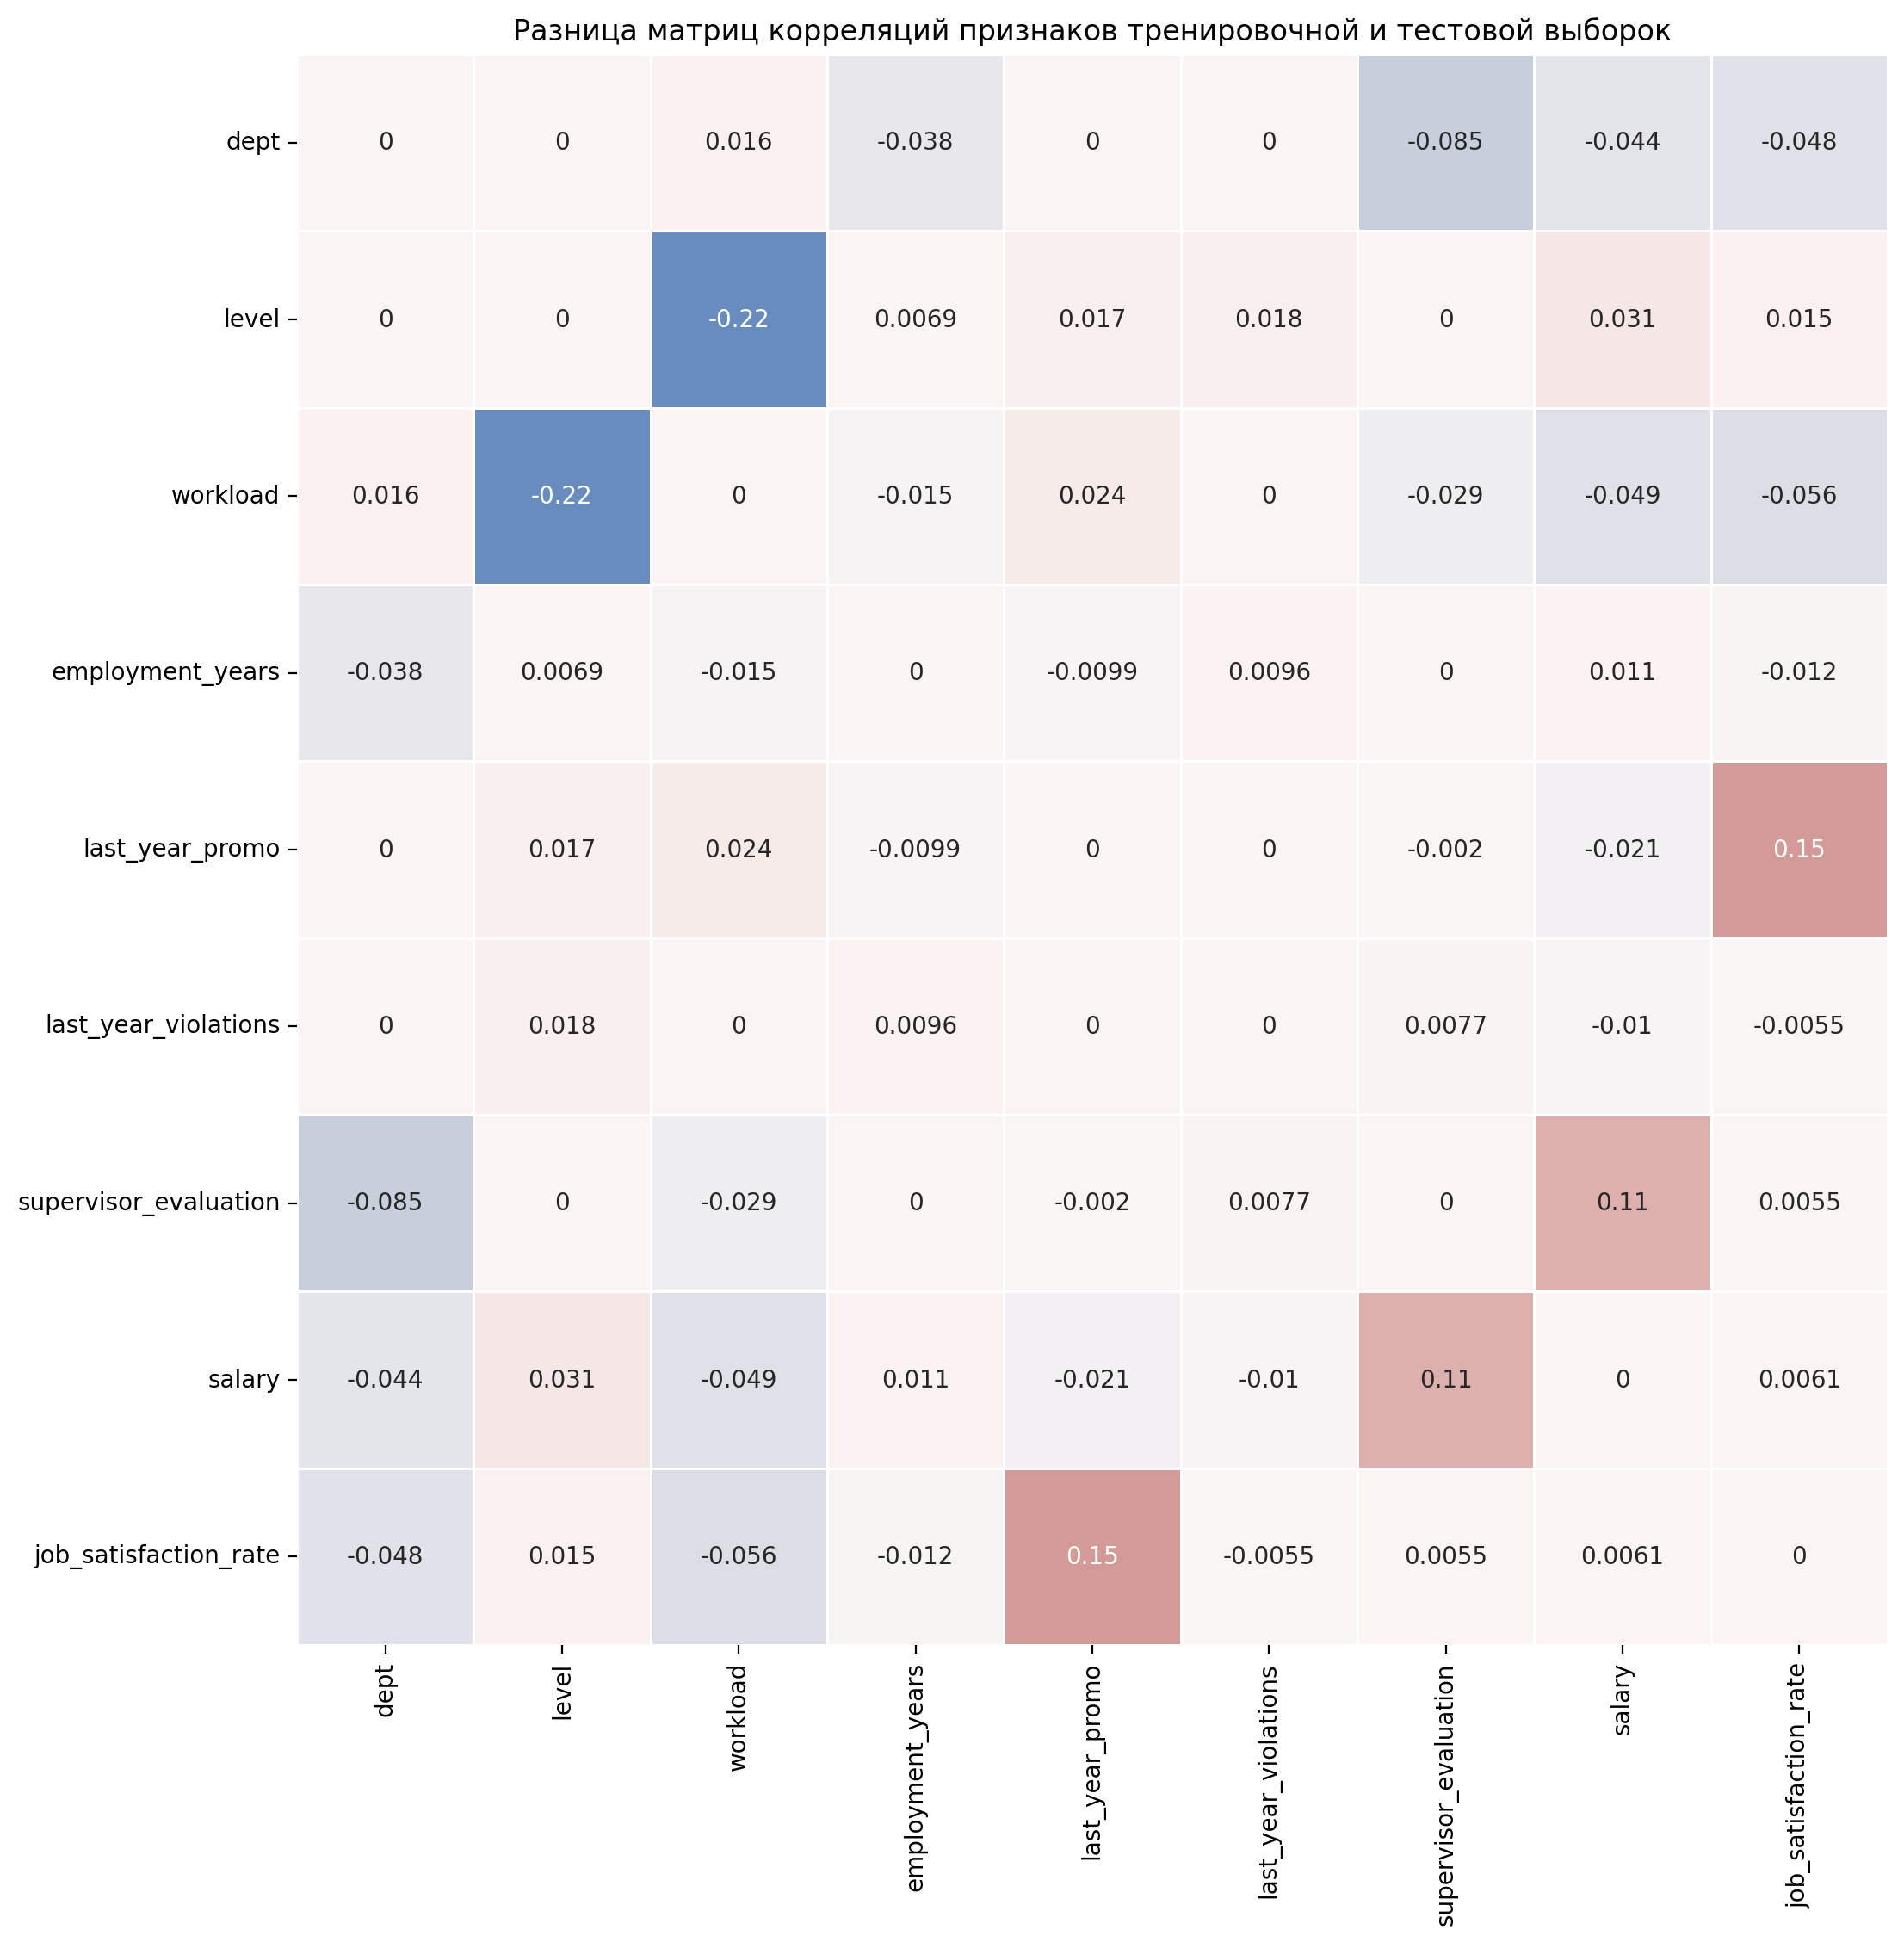

In [51]:
interval_col_names = ['salary', 'job_satisfaction_rate']
jsr_train_corr_coefficients = jsr_train.phik_matrix(interval_cols=interval_col_names)
jsr_test_corr_coefficients = jsr_test_features.join(jsr_test_target).phik_matrix(interval_cols=interval_col_names)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(jsr_test_corr_coefficients - jsr_train_corr_coefficients, annot=True, square=True, 
            cbar=False, linewidths=0.5, cmap=sns.color_palette('vlag', as_cmap=True), vmin=-0.30, vmax=0.30, ax=ax)
ax.set_title('Разница матриц корреляций признаков тренировочной и тестовой выборок')
plt.show()

Заметно, что в тестовой выборке незначительно увеличилась корреляция целевого признака `job_satisfaction_rate` (уровень удовлетворённости сотрудника) с признаком `last_year_promo` (было ли повышение за последний год). Также можно отметить снижение корреляции признаков `level` (уровень занимаемой должности) и `workload` (уровень загруженности сотрудника). Однако существенных отличий не обнаружено.

### Подготовка данных

Для автоматизации действий по подготовке данных (кодирование категориальных признаков и масштабирование количественных признаков) будем использовать пайплайны. При кодировании учтем ранговые признаки `level` (уровень занимаемой должности) и `workload` (уровень загруженности сотрудника).

In [55]:
jsr_ohe_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
)

jsr_ord_transformer = Pipeline(
    steps=[('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ('encoder', OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], 
                                                  ['low', 'medium', 'high']],
                                      handle_unknown='use_encoded_value', unknown_value=np.nan)),
           ('imputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)

jsr_num_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
           ('scaler', MinMaxScaler())]
)

jsr_data_preprocessor = ColumnTransformer(
    transformers=[('ohe', jsr_ohe_transformer, ['dept', 'last_year_promo', 'last_year_violations']),
                  ('ord', jsr_ord_transformer, ['level', 'workload']),
                  ('num', jsr_num_transformer, ['employment_years', 'supervisor_evaluation', 'salary'])], 
    remainder='drop', 
    verbose_feature_names_out=False
)

### Обучение моделей

Обучим несколько моделей, которые предскажут уровня удовлетворённости сотрудника и выберем лучшую из них. Поскольку в качестве одной из моделей мы будем использовать линейную регрессию, предварительно удалим дубликаты из тренировочной выборки.

In [58]:
jsr_train_without_duplicates = jsr_train.drop_duplicates()

X_train = jsr_train_without_duplicates.sort_index().drop('job_satisfaction_rate', axis=1)
y_train = jsr_train_without_duplicates.sort_index()['job_satisfaction_rate']
X_test = jsr_test_features.sort_index()
y_test = jsr_test_target.sort_index()['job_satisfaction_rate']

Создадим итоговый пайплайн, включающий подготовку данных и модель.

In [60]:
jsr_final_pipe = Pipeline(steps=[('preprocessor', jsr_data_preprocessor),
                                 ('model', LinearRegression())])

Для оценки качества моделей создадим объект пользовательской метрики SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).

In [62]:
jsr_smape_scorer = make_scorer(get_smape, greater_is_better=False)

Начнем с дамми-модели, предсказывающей среднее значение уровень удовлетворённости сотрудника работой в тренировочной выборке.

In [64]:
jsr_dummy_model = DummyRegressor()
jsr_dummy_model.fit(X_train, y_train)

score_test = -jsr_smape_scorer(jsr_dummy_model, X_test, y_test)
display(f'Метрика SMAPE на тестовой выборке: {score_test:.2f}')

'Метрика SMAPE на тестовой выборке: 38.26'

В качестве моделей возьмем:
- линейную регрессию `LinearRegression()`,
- модель дерева решений `DecisionTreeRegressor()`.

Подберем гиперпараметры с помощью класса `GridSearchCV`.

In [66]:
cell_start_time = time.time()

param_grid = [
    {
        'preprocessor__ohe__encoder__drop': ['if_binary'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler()],
        'model': [LinearRegression(fit_intercept=False)]
    },
    {
        'preprocessor__num': ['passthrough'],
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 21),
        'model__min_samples_split': range(2, 6),
        'model__min_samples_leaf': range(1, 6)
    }
]

jsr_search_model_cv = GridSearchCV(jsr_final_pipe, param_grid, cv=5, scoring=jsr_smape_scorer, n_jobs=-1)
jsr_search_model_cv.fit(X_train, y_train)

display(f'На подбор гиперпараметров затрачено времени: {time.time() - cell_start_time:.0f} сек')
display(f'Метрика SMAPE при кросс-валидации: {-jsr_search_model_cv.best_score_:.2f}')

score_test = -jsr_smape_scorer(jsr_search_model_cv, X_test, y_test)
display(f'Метрика SMAPE на тестовой выборке: {score_test:.2f}')

'На подбор гиперпараметров затрачено времени: 16 сек'

'Метрика SMAPE при кросс-валидации: 14.72'

'Метрика SMAPE на тестовой выборке: 13.72'

Посмотрим на результаты лучших моделей каждого типа.

In [68]:
cv_results_df = pd.DataFrame(jsr_search_model_cv.cv_results_).sort_values('rank_test_score')
cv_results_df['model_name'] = cv_results_df['param_model'].apply(lambda x: x.__class__.__name__)

grouped = cv_results_df.pivot_table(index='model_name', aggfunc='first').sort_values('rank_test_score')
grouped[['params', 'mean_test_score', 'rank_test_score']]

params  \
model_name                                                                                                                                                                                          
DecisionTreeRegressor  {'model': DecisionTreeRegressor(random_state=42), 'model__max_depth': 15, 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'preprocessor__num': 'passthrough'}   
LinearRegression                                           {'model': LinearRegression(fit_intercept=False), 'preprocessor__num': MinMaxScaler(), 'preprocessor__ohe__encoder__drop': 'if_binary'}   

                       mean_test_score  rank_test_score  
model_name                                               
DecisionTreeRegressor       -14.720352                1  
LinearRegression            -25.004721              381

Лучше всего справилась модель `DecisionTreeRegressor()` с гиперпараметрами `max_depth=15`, `min_samples_leaf=3` и `min_samples_split=3`. Модель удовлетворяет поставленному критерию успеха (SMAPE5≤15 на тестовой выборке). Посмотрим на распределение остатков.

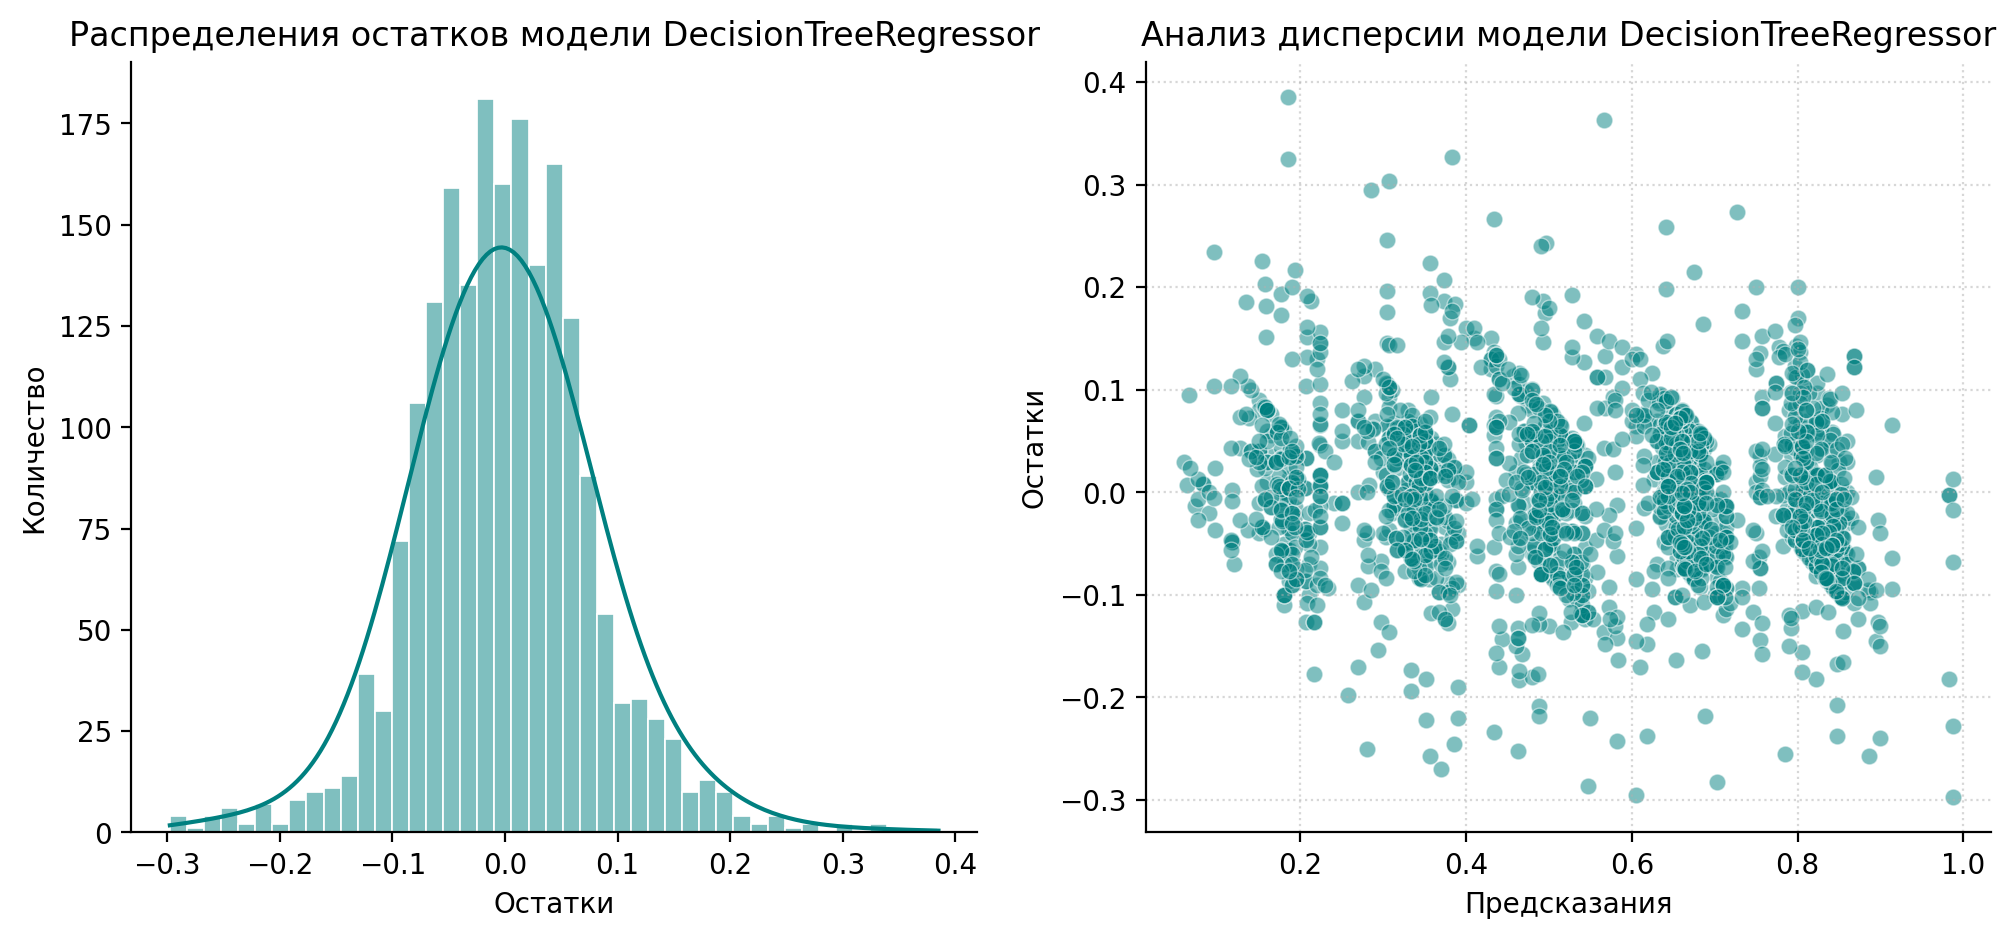

In [70]:
y_test_pred = jsr_search_model_cv.predict(X_test)
residuals = y_test - y_test_pred

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x=residuals, ax=ax1, kde=True, kde_kws={'bw_method': 0.6}, edgecolor='white', color='teal')
ax1.set_title(f'Распределения остатков модели DecisionTreeRegressor')
ax1.set_xlabel('Остатки')
ax1.set_ylabel('Количество')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

sns.scatterplot(x=y_test_pred, y=residuals, ax=ax2, alpha=0.5, color='teal')
ax2.set_title('Анализ дисперсии модели DecisionTreeRegressor')
ax2.set_xlabel('Предсказания')
ax2.set_ylabel('Остатки')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(alpha=0.5, linestyle=':')

plt.show()

Остатки имеют нормальное распределение со средним значением около 0.

Оценим веса каждого из входных признаков в прогнозе модели.

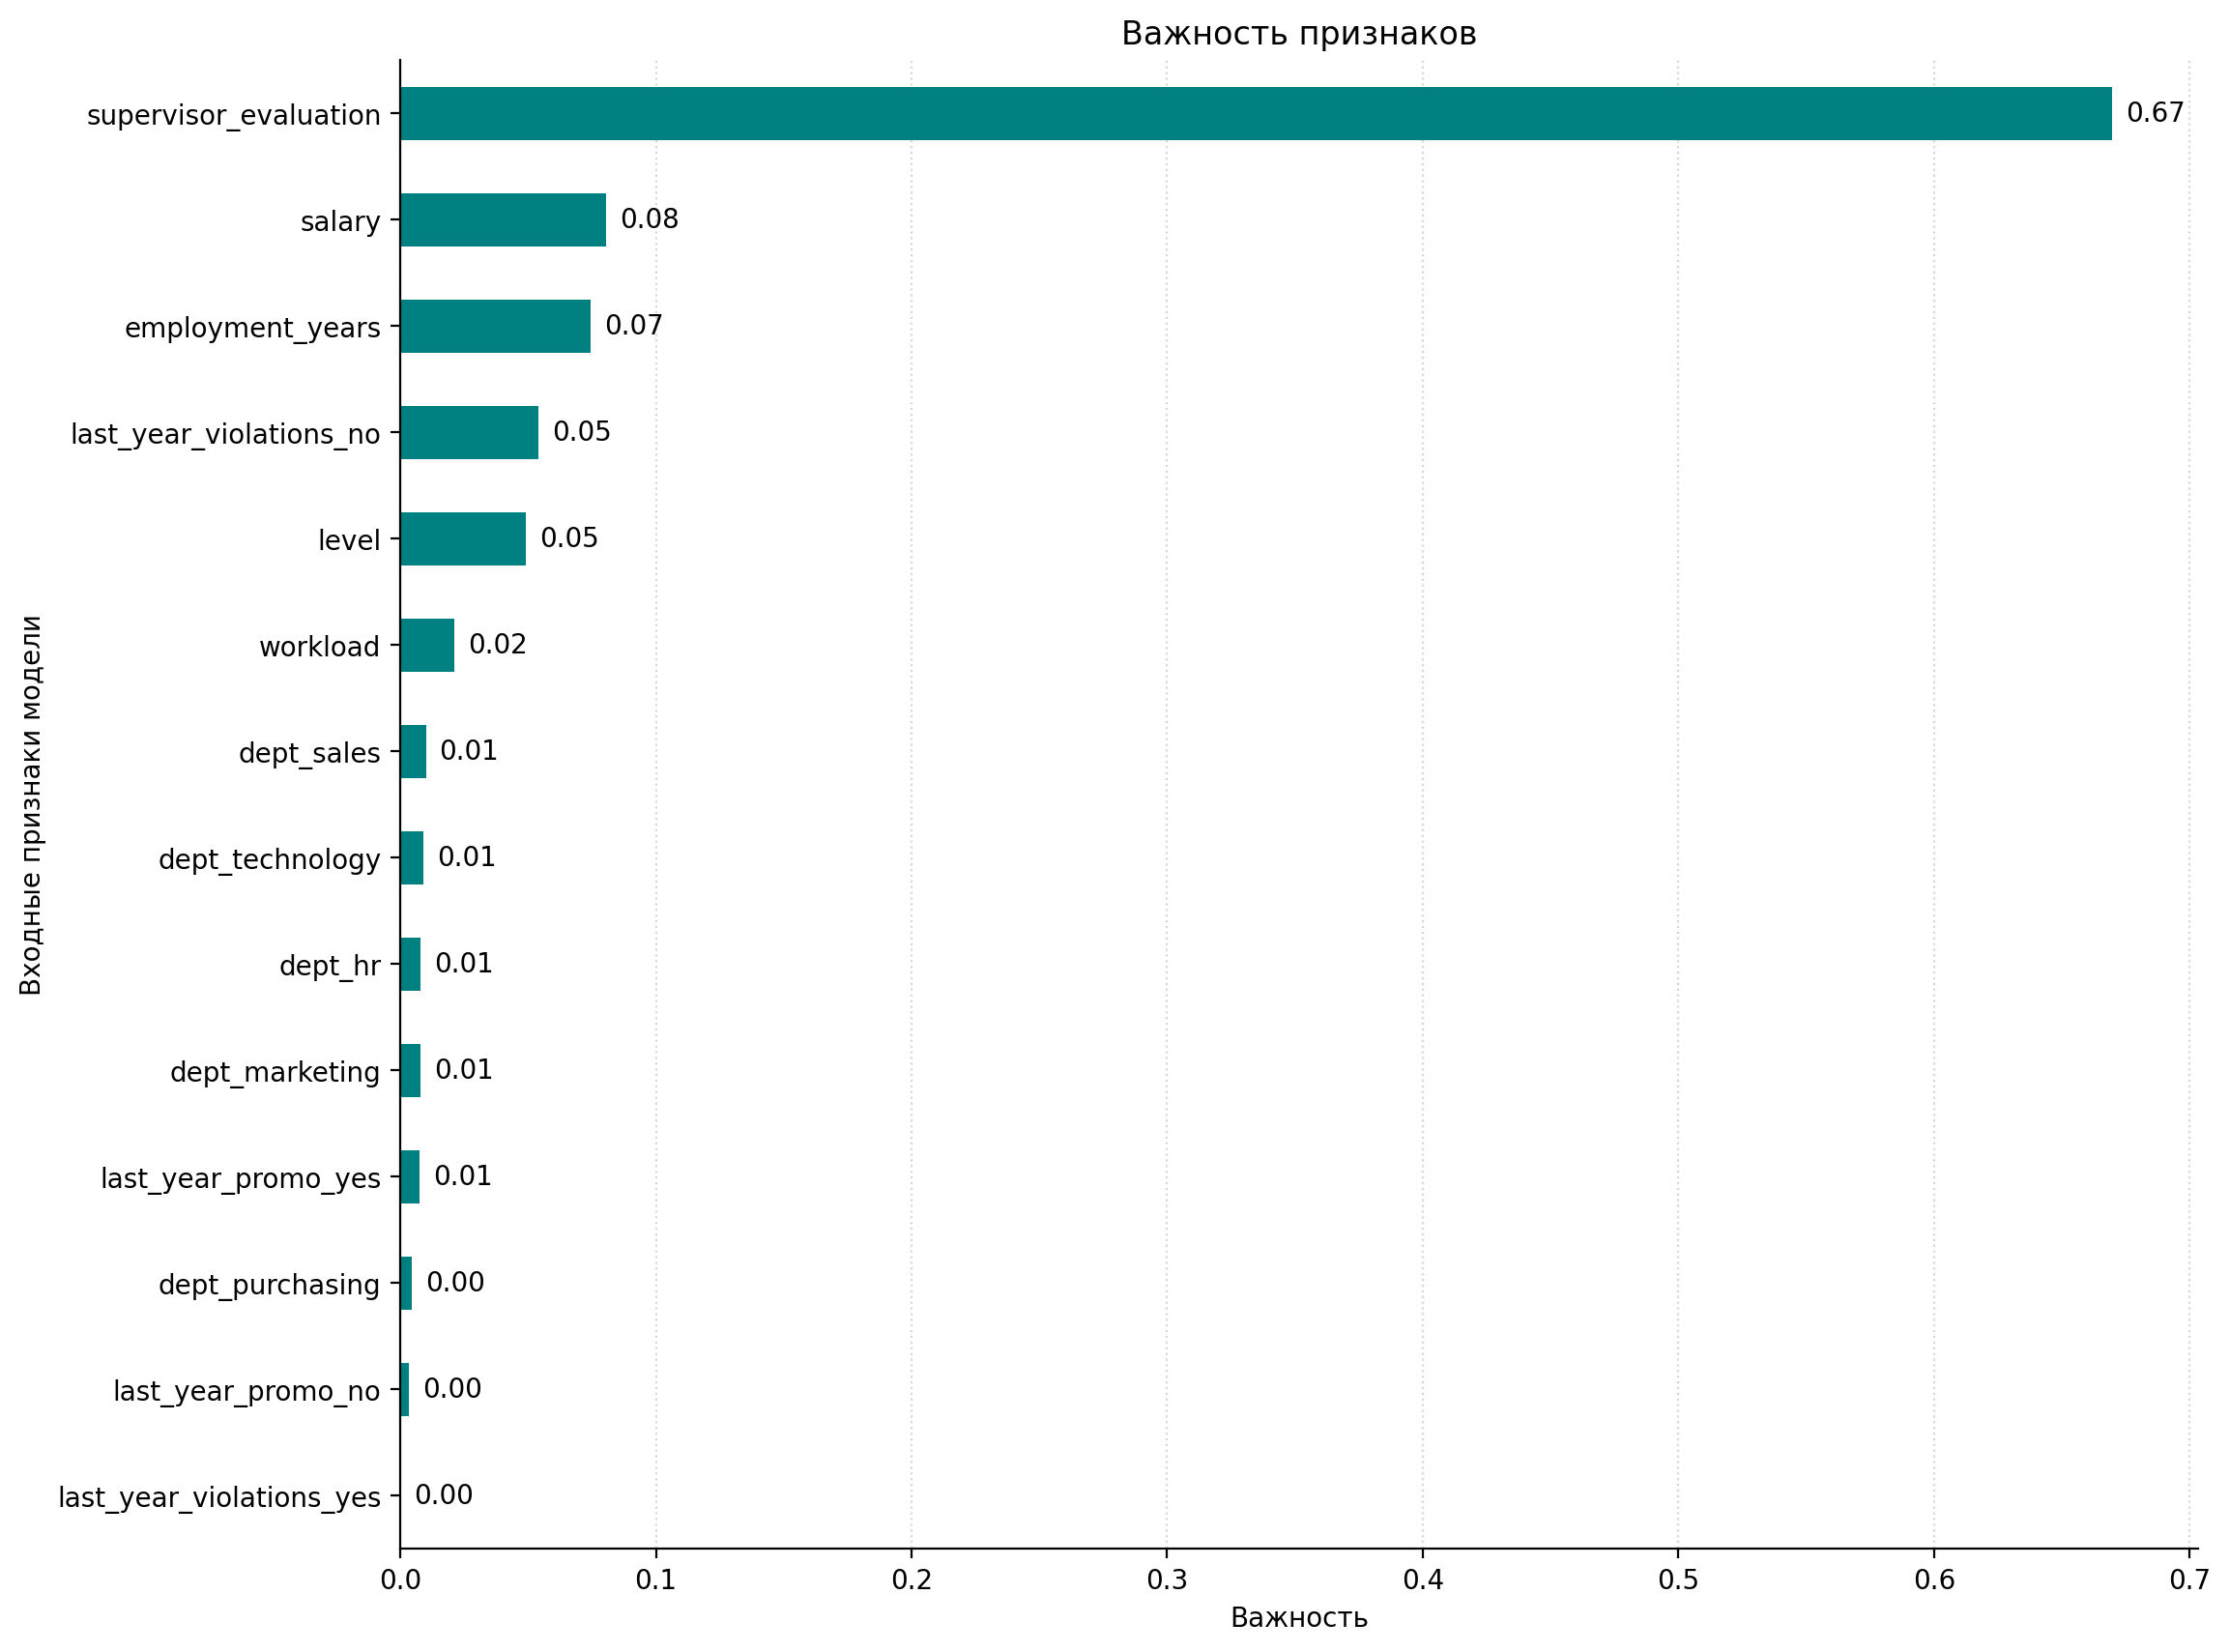

In [73]:
feature_importances = pd.Series(
    data=jsr_search_model_cv.best_estimator_.named_steps['model'].feature_importances_,
    index=jsr_search_model_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

feature_importances.plot(kind='barh', ax=ax, color='teal')
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge', padding=5)
ax.set_title('Важность признаков')
ax.set_xlabel('Важность')
ax.set_ylabel('Входные признаки модели')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5, linestyle=':')

plt.show()

Самыми важными признаками в работе модели дерева решений оказались:
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `employment_years` — длительность работы в компании;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `level` — уровень занимаемой должности.

### Вывод

Лучше всего с предсказанием уровня удовлетворённости сотрудника справилась модель `DecisionTreeRegressor()` с гиперпараметрами `max_depth=15`, `min_samples_leaf=3` и `min_samples_split=3`. Модель удовлетворяет поставленному критерию успеха (SMAPE=13.72 на тестовой выборке). 

Модель дерева решений показала лучший результат (SMAP=14.72 при кросс-валидации), чем модель линейной регресии (SMAP=25 при кросс-валидации). Поскольку большинство входных признаков является категориальными, а количественные признаки не имеют высокой линейной корреляции с целевым признаком, модель линейной регресии не показала высокого качества.

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

Считаем CSV-файлы с данными и сохраним их в датафреймы. Изучим общую информацию о датафреймах.

In [80]:
csv_local_path = 'datasets/train_quit.csv'
csv_url = 'https://example.com/datasets/train_quit.csv'
if os.path.exists(csv_local_path):
    quit_train = pd.read_csv(csv_local_path, index_col='id')
else:
    quit_train = pd.read_csv(csv_url, index_col='id')

display_df_basic_info(quit_train)

dept   level workload  employment_years last_year_promo  \
id                                                                      
723290       sales  middle     high                 2              no   
814010       sales  junior   medium                 2              no   
155091  purchasing  middle   medium                 5              no   
257132       sales  junior   medium                 2              no   
910140   marketing  junior   medium                 2              no   

       last_year_violations  supervisor_evaluation  salary quit  
id                                                               
723290                   no                      4   54000   no  
814010                   no                      4   27600   no  
155091                   no                      1   37200   no  
257132                  yes                      3   24000  yes  
910140                   no                      5   25200   no

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

In [81]:
csv_local_path = 'datasets/test_features.csv'
csv_url = 'https://example.com/datasets/test_features.csv'
if os.path.exists(csv_local_path):
    quit_test_features = pd.read_csv(csv_local_path, index_col='id')
else:
    quit_test_features = pd.read_csv(csv_url, index_col='id')

display_df_basic_info(quit_test_features)

dept   level workload  employment_years last_year_promo  \
id                                                                     
485046  marketing  junior   medium                 2              no   
686555         hr  junior   medium                 1              no   
467458      sales  middle      low                 5              no   
418655      sales  middle      low                 6              no   
789145         hr  middle   medium                 5              no   

       last_year_violations  supervisor_evaluation  salary  
id                                                          
485046                   no                      5   28800  
686555                   no                      4   30000  
467458                   no                      4   19200  
418655                   no                      4   19200  
789145                   no                      5   40800

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

In [82]:
csv_local_path = 'datasets/test_target_quit.csv'
csv_url = 'https://example.com/datasets/test_target_quit.csv'
if os.path.exists(csv_local_path):
    quit_test_target = pd.read_csv(csv_local_path, index_col='id')
else:
    quit_test_target = pd.read_csv(csv_url, index_col='id')

display_df_basic_info(quit_test_target)

quit
id         
999029  yes
372846   no
726767   no
490105   no
416898  yes

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

### Предобработка данных

In [84]:
quit_train.index.duplicated().sum()

0

In [85]:
quit_train.duplicated().sum()

1413

В датафрейме с тренировочной выборкой есть явные дубликаты (не ошибка, у сотрудников могут быть одинаковые признаки). Качество нелинейных моделей не пострадает.

In [87]:
for col_name in quit_train.select_dtypes(exclude='number').columns:
    display(f'{col_name}: {quit_train[col_name].unique().tolist()}')

"dept: ['sales', 'purchasing', 'marketing', 'technology', 'hr']"

"level: ['middle', 'junior', 'sinior']"

"workload: ['high', 'medium', 'low']"

"last_year_promo: ['no', 'yes']"

"last_year_violations: ['no', 'yes']"

"quit: ['no', 'yes']"

Скрытых дубликатов в датафрейме с тренировочной выборкой в значениях категориальных признаков не обнаружено.

In [89]:
quit_train.isna().sum().sum()

0

Пропусков в данных в датафрейме с тренировочной выборкой не обнаружено.

Датафрейм `quit_train` содержит данные о сотрудниках, предоставленные заказчиком (тренировочная выборка).

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `quit` — увольнение сотрудника из компании.

Датафрейм `quit_test_features` содержит входные признаки тестовой выборки.

Датафрейм `quit_test_target` содержит целевой признак тестовой выборки.

### Исследовательский анализ данных

#### Тренировочная выборка

Посмотрим на числовое описание количественных признаков в датафрейме с тренировочной выборкой.

In [95]:
num_col_names = quit_train.select_dtypes(include='number').columns
quit_train[num_col_names].describe().T

count         mean           std      min      25%  \
employment_years       4000.0      3.70150      2.541852      1.0      2.0   
supervisor_evaluation  4000.0      3.47475      1.004049      1.0      3.0   
salary                 4000.0  33805.80000  15152.415163  12000.0  22800.0   

                           50%      75%      max  
employment_years           3.0      6.0     10.0  
supervisor_evaluation      4.0      4.0      5.0  
salary                 30000.0  43200.0  96000.0

Изучим распределения непрерывных количественных признаков в датафрейме с тренировочной выборкой в разбивке по целевому признаку увольнения сотрудника из компании `quit`.

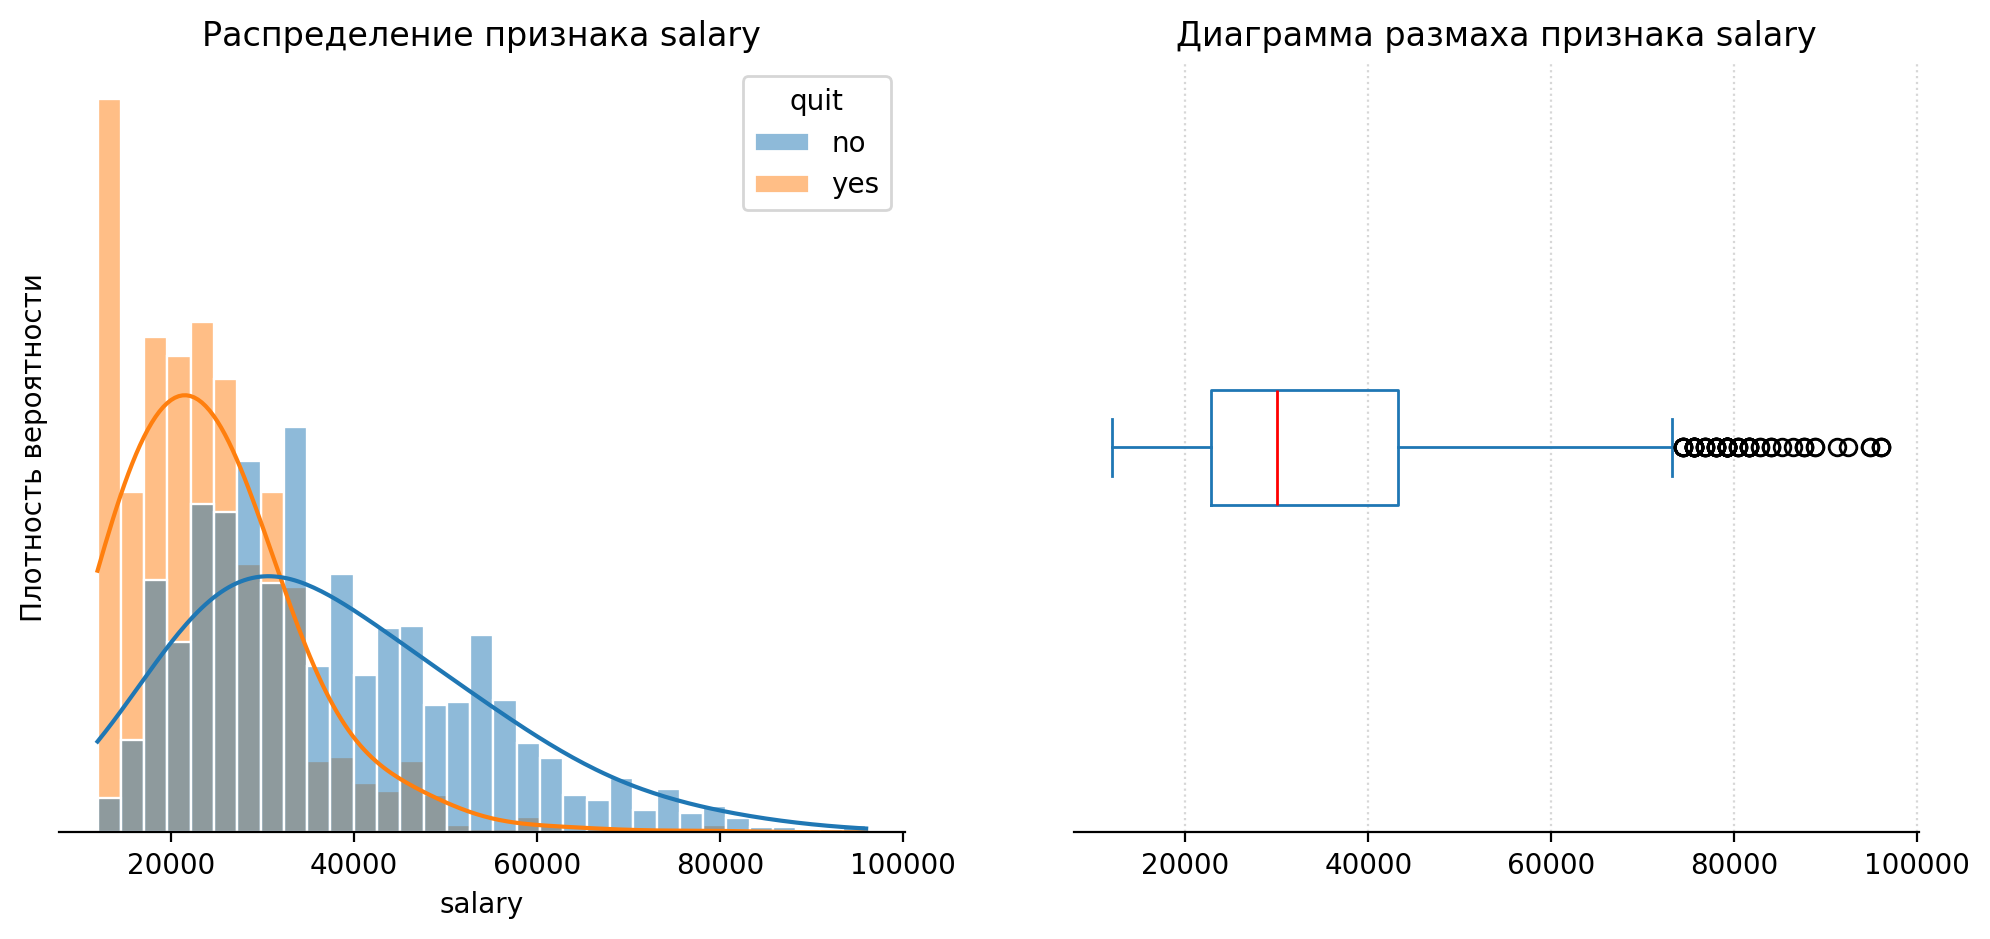

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=quit_train, x='salary', ax=ax1, hue='quit', stat='density', common_norm=False, 
             kde=True, kde_kws={'bw_method': 0.6}, edgecolor='white')
ax1.set_title('Распределение признака salary')
ax1.set_xlabel('salary')
ax1.set_ylabel('Плотность вероятности')
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

quit_train['salary'].plot(kind='box', vert=False, ax=ax2, medianprops={'color': 'red'})
ax2.set_title('Диаграмма размаха признака salary')
ax1.set_xlabel('salary')
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(axis='x', alpha=0.5, linestyle=':')

plt.show()

Изучим распределения дискретных количественных признаков в датафрейме с тренировочной выборкой в разбивке по целевому признаку увольнения сотрудника из компании `quit`.

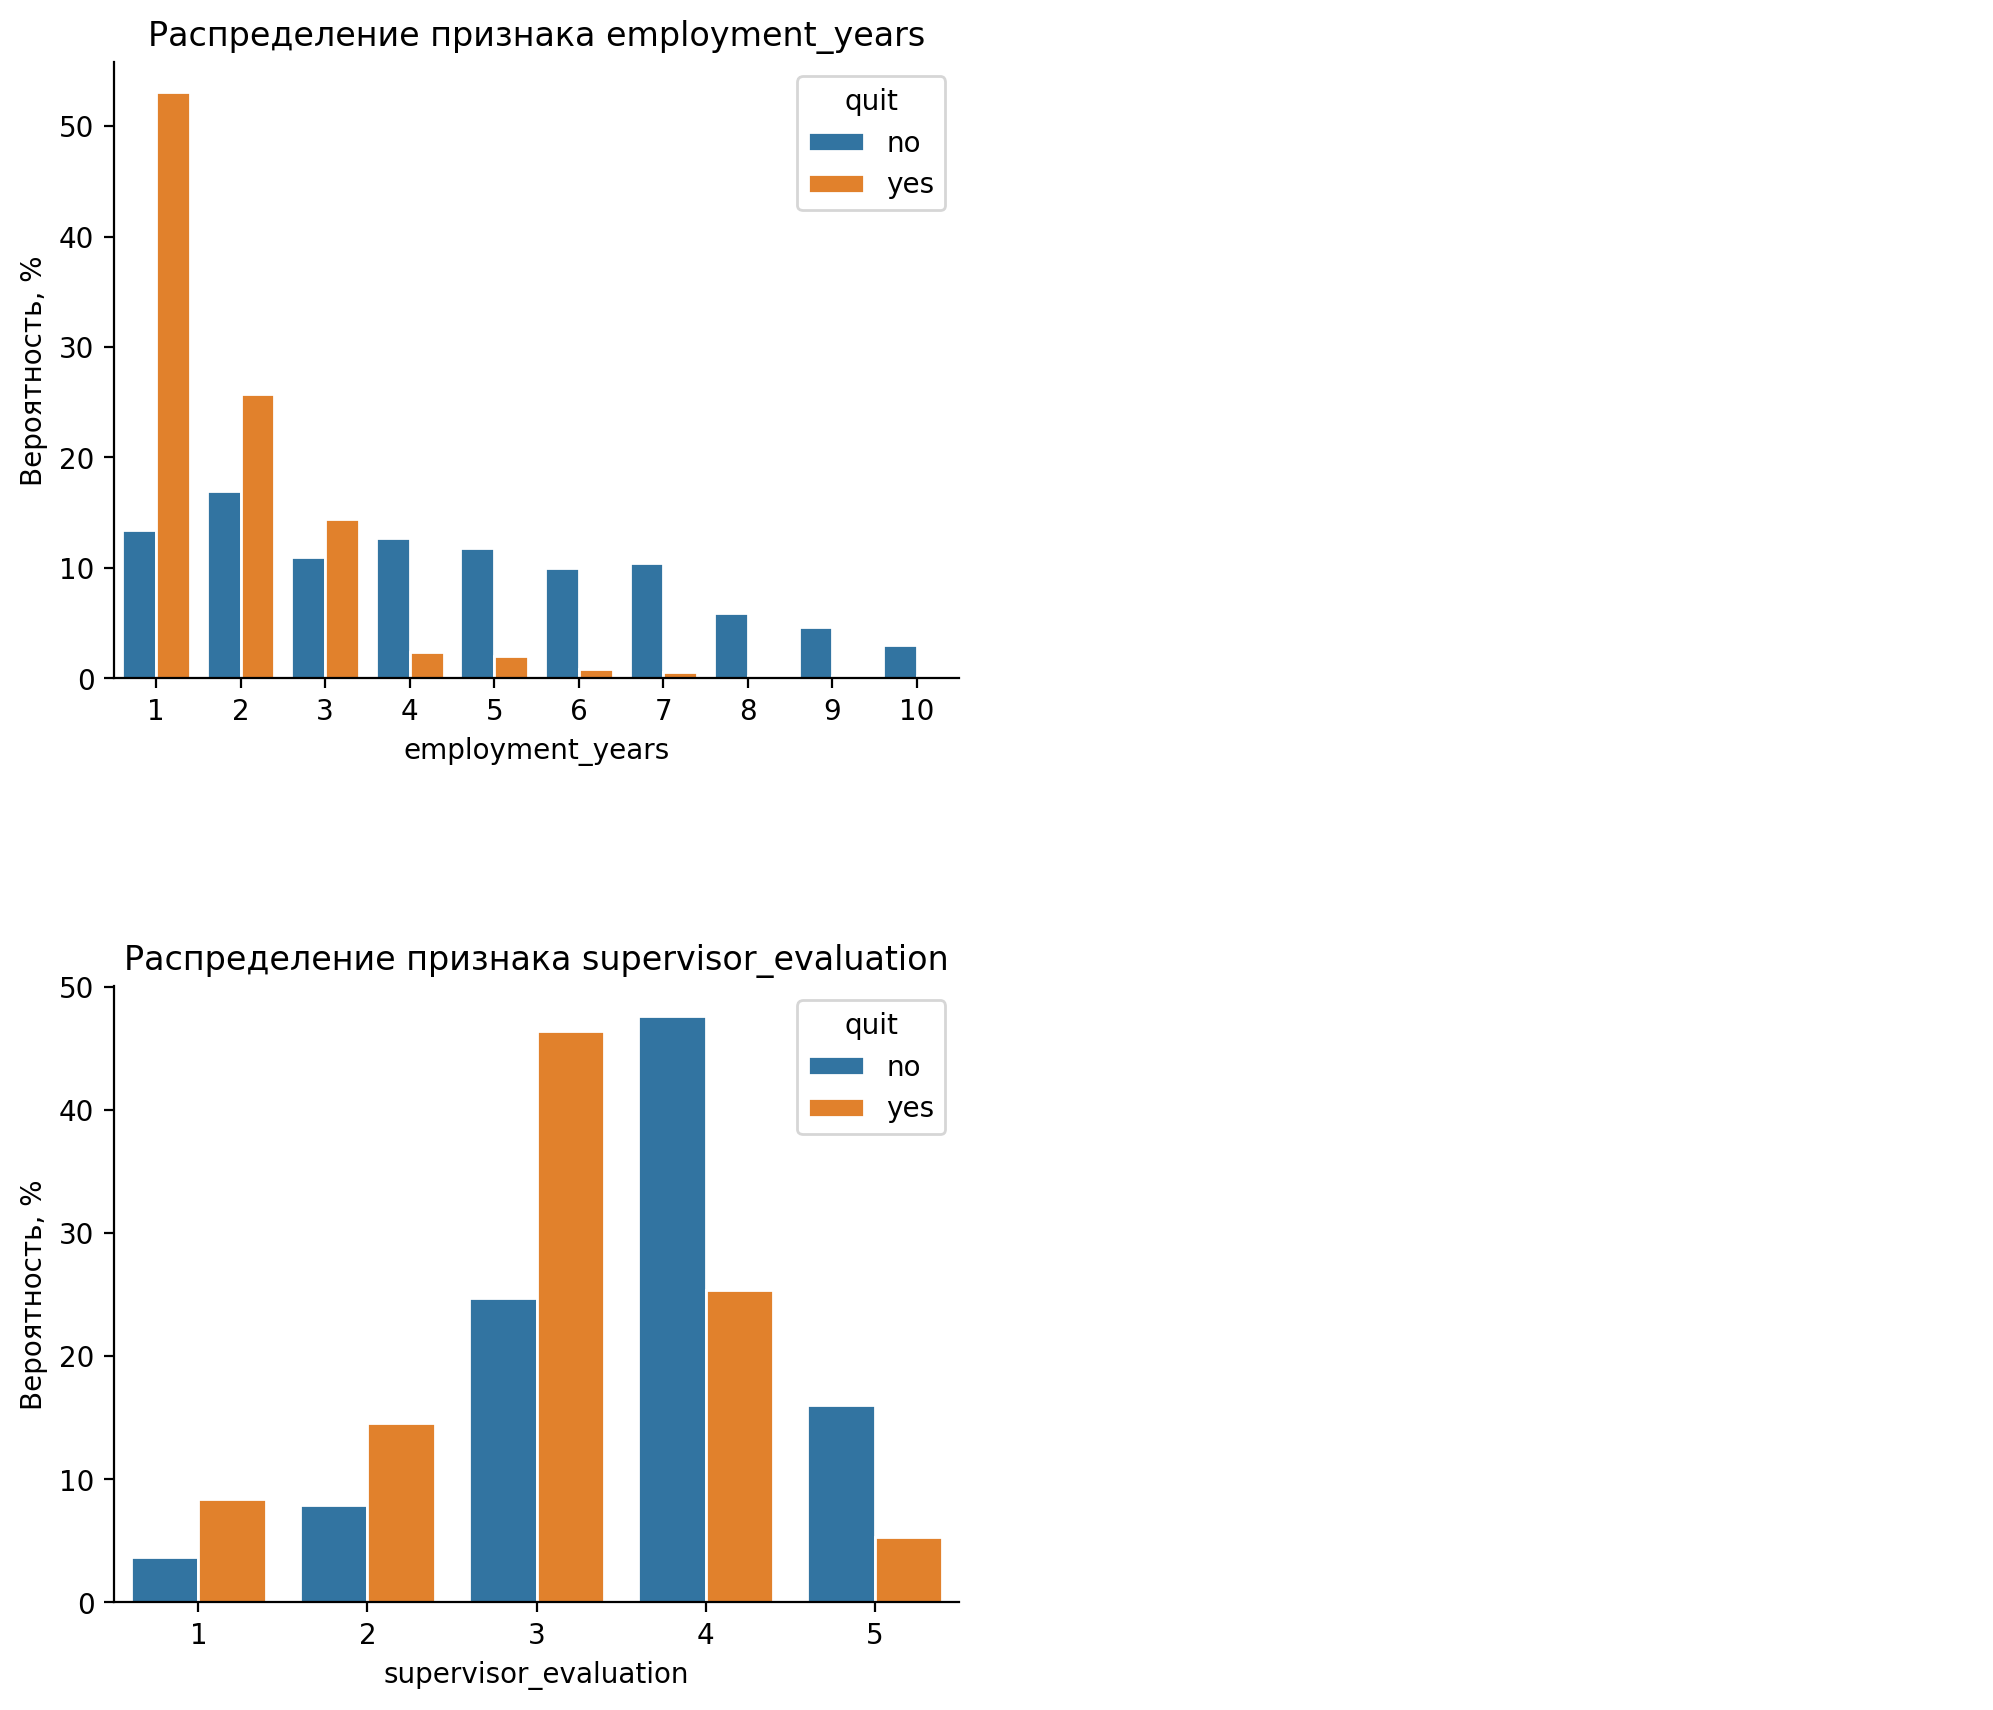

In [99]:
discrete_col_names = ['employment_years', 'supervisor_evaluation']

n = len(discrete_col_names)
fig, axes = plt.subplots(n, 2, figsize=(12, n * 5))
fig.subplots_adjust(hspace=0.5)

for ind, col_name in enumerate(discrete_col_names):
    ax1, ax2 = axes[ind, 0], axes[ind, 1]
    
    grouped = (quit_train.groupby('quit')[col_name]
               .value_counts(normalize=True)
               .rename('pct')
               .mul(100)
               .reset_index()
               .sort_values(col_name))
    
    sns.barplot(data=grouped, x=col_name, y='pct', hue='quit', ax=ax1, edgecolor='white')
    ax1.set_title(f'Распределение признака {col_name}')
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Вероятность, %')
    ax1.set_axisbelow(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    ax2.set_axis_off()

plt.show()

Изучим распределения категориальных признаков в датафрейме с тренировочной выборкой.

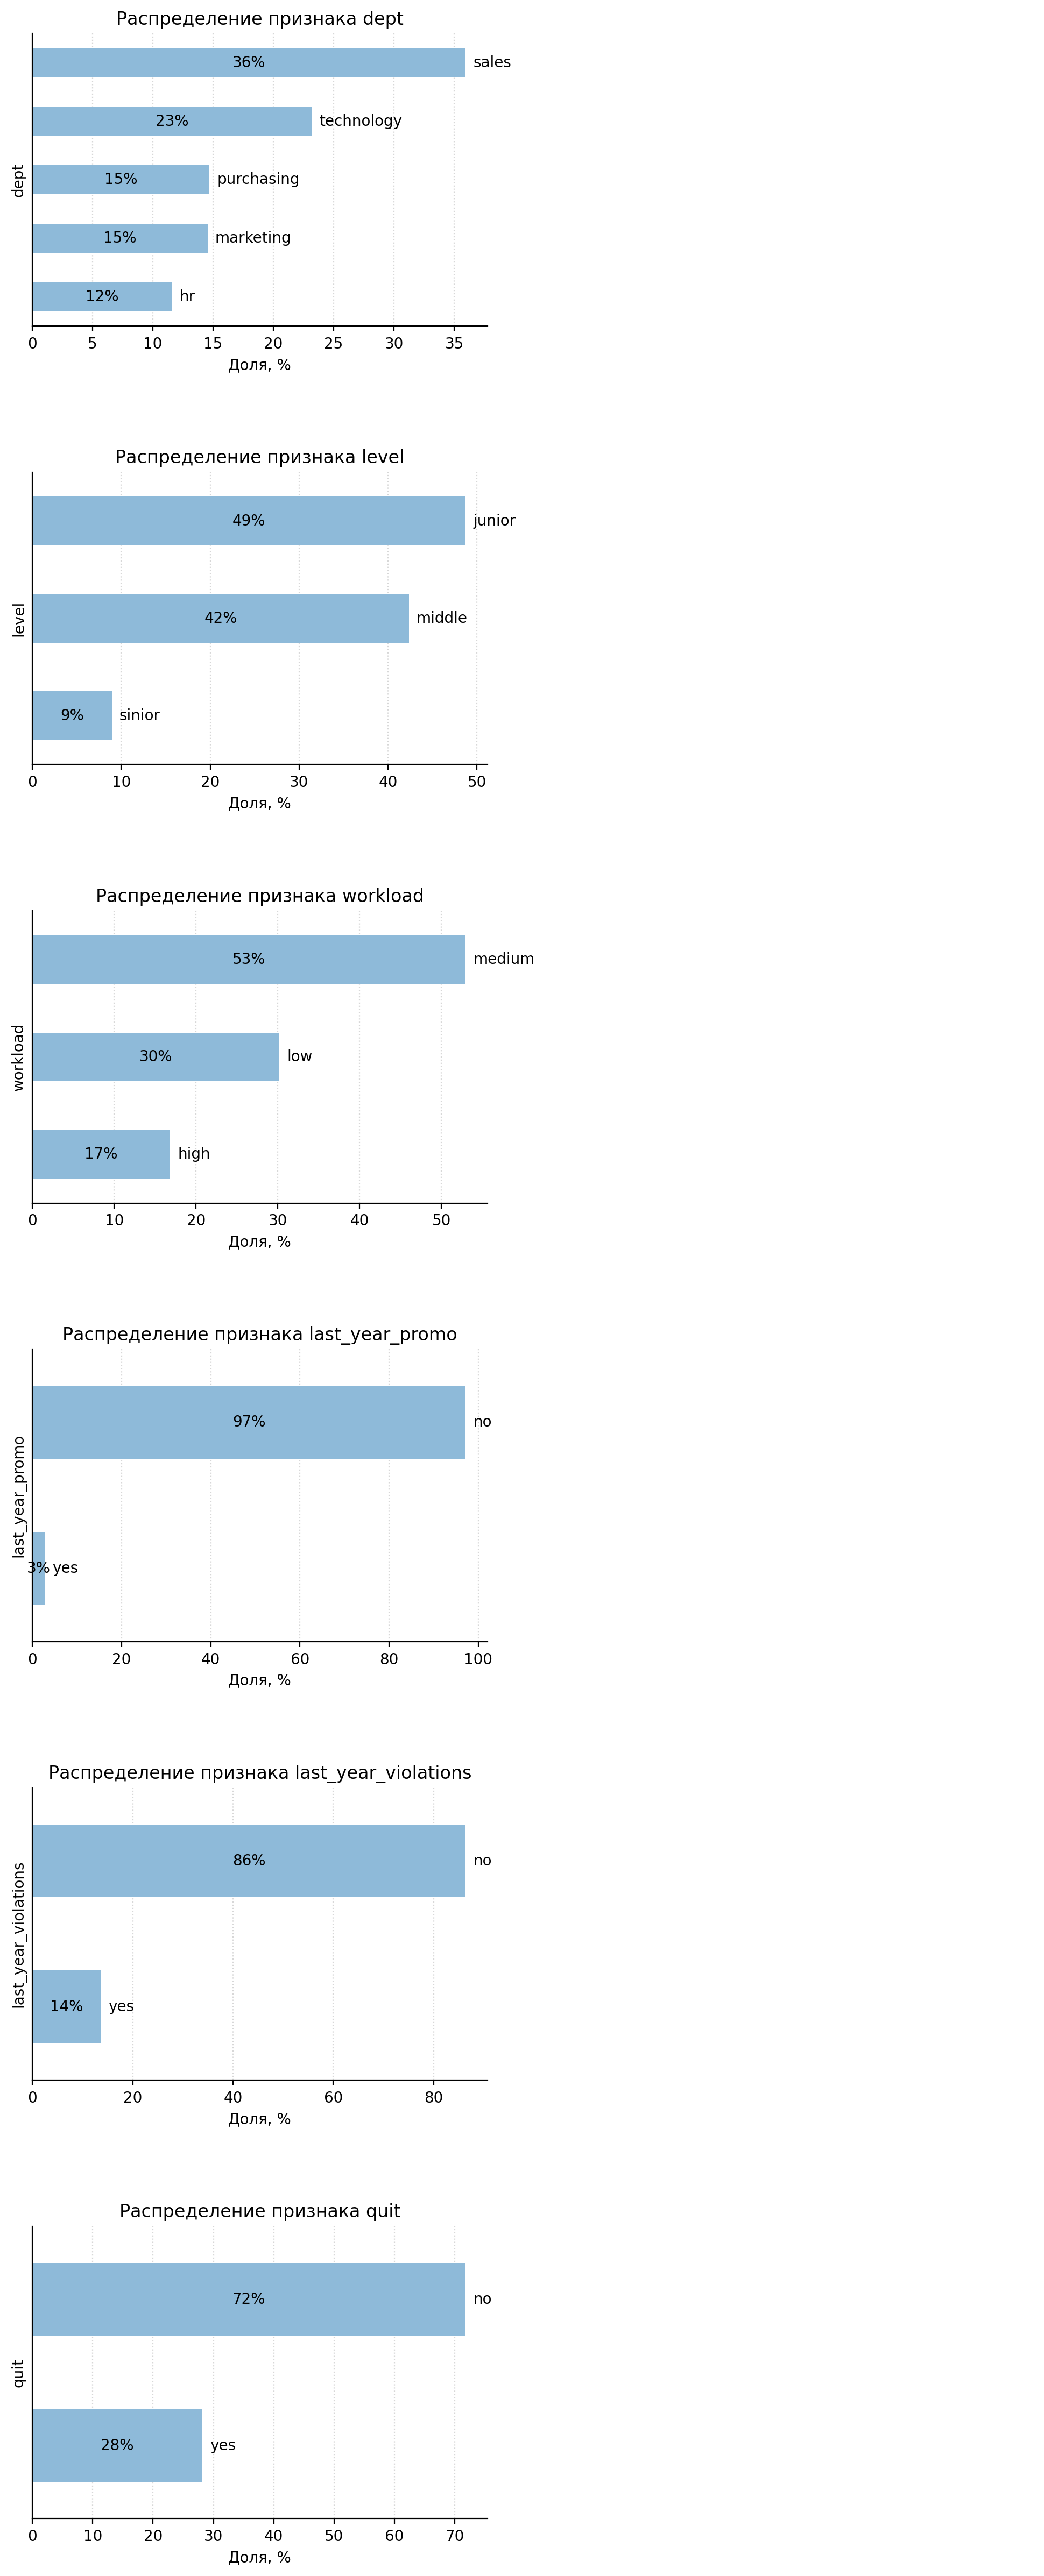

In [101]:
cat_col_names = quit_train.select_dtypes(exclude='number').columns

n = len(cat_col_names)
fig, axes = plt.subplots(n, 2, figsize=(12, n * 5))
fig.subplots_adjust(hspace=0.5)

for ind, col_name in enumerate(cat_col_names):
    ax1, ax2 = axes[ind, 0], axes[ind, 1]
    
    col = quit_train[col_name].value_counts(normalize=True).sort_values() * 100
    col.plot(kind='barh', ax=ax1, color='#8ebad9')
    ax1.bar_label(axes[ind, 0].containers[0], fmt='%.0f%%', label_type='center')
    ax1.bar_label(axes[ind, 0].containers[0], labels=col.index, label_type='edge', padding=5)
    ax1.set_title(f'Распределение признака {col_name}')
    ax1.set_xlabel('Доля, %')
    ax1.set_yticks([])
    ax1.set_axisbelow(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='x', alpha=0.5, linestyle=':')
    
    ax2.set_axis_off()
    
plt.show()

Составим портрет уволившегося сотрудника.

In [103]:
num_col_names = quit_train.select_dtypes(include='number').columns
cat_col_names = quit_train.select_dtypes(exclude='number').columns.drop('quit')

quit_train.pivot_table(index='quit', values=num_col_names).join(
    quit_train.pivot_table(index='quit', values=cat_col_names, aggfunc=pd.Series.mode)
)

employment_years        salary  supervisor_evaluation   dept  \
quit                                                                 
no            4.430710  37702.228412               3.643106  sales   
yes           1.844858  23885.106383               3.046099  sales   

     last_year_promo last_year_violations   level workload  
quit                                                        
no                no                   no  middle   medium  
yes               no                   no  junior      low

Таким образом портрет уволившегося сотрудника выглядит следующим образом:
- средняя длительность работы в компании ~1.8 года (против ~4.4 года у «неуволившегося» сотрудника);
- средняя ежемесячная зарплата сотрудника ~23885 (против ~37702 у «неуволившегося» сотрудника);
- средняя оценка качества работы сотрудника, которую дал руководитель, ~3 (против ~3.6 у «неуволившегося» сотрудника);
- уволившийся сотрудник с большей вероятностью работает джуном в отделе продаж, слабо загружен, не получал повышений и не нарушал трудовой договор за последний год.

Посмотрим на вероятность ухода сотрудника в различных сегментах. Для этого рассчитаем отношение уволившихся сотрудников к общему числу сотрудников в каждом сегменте.

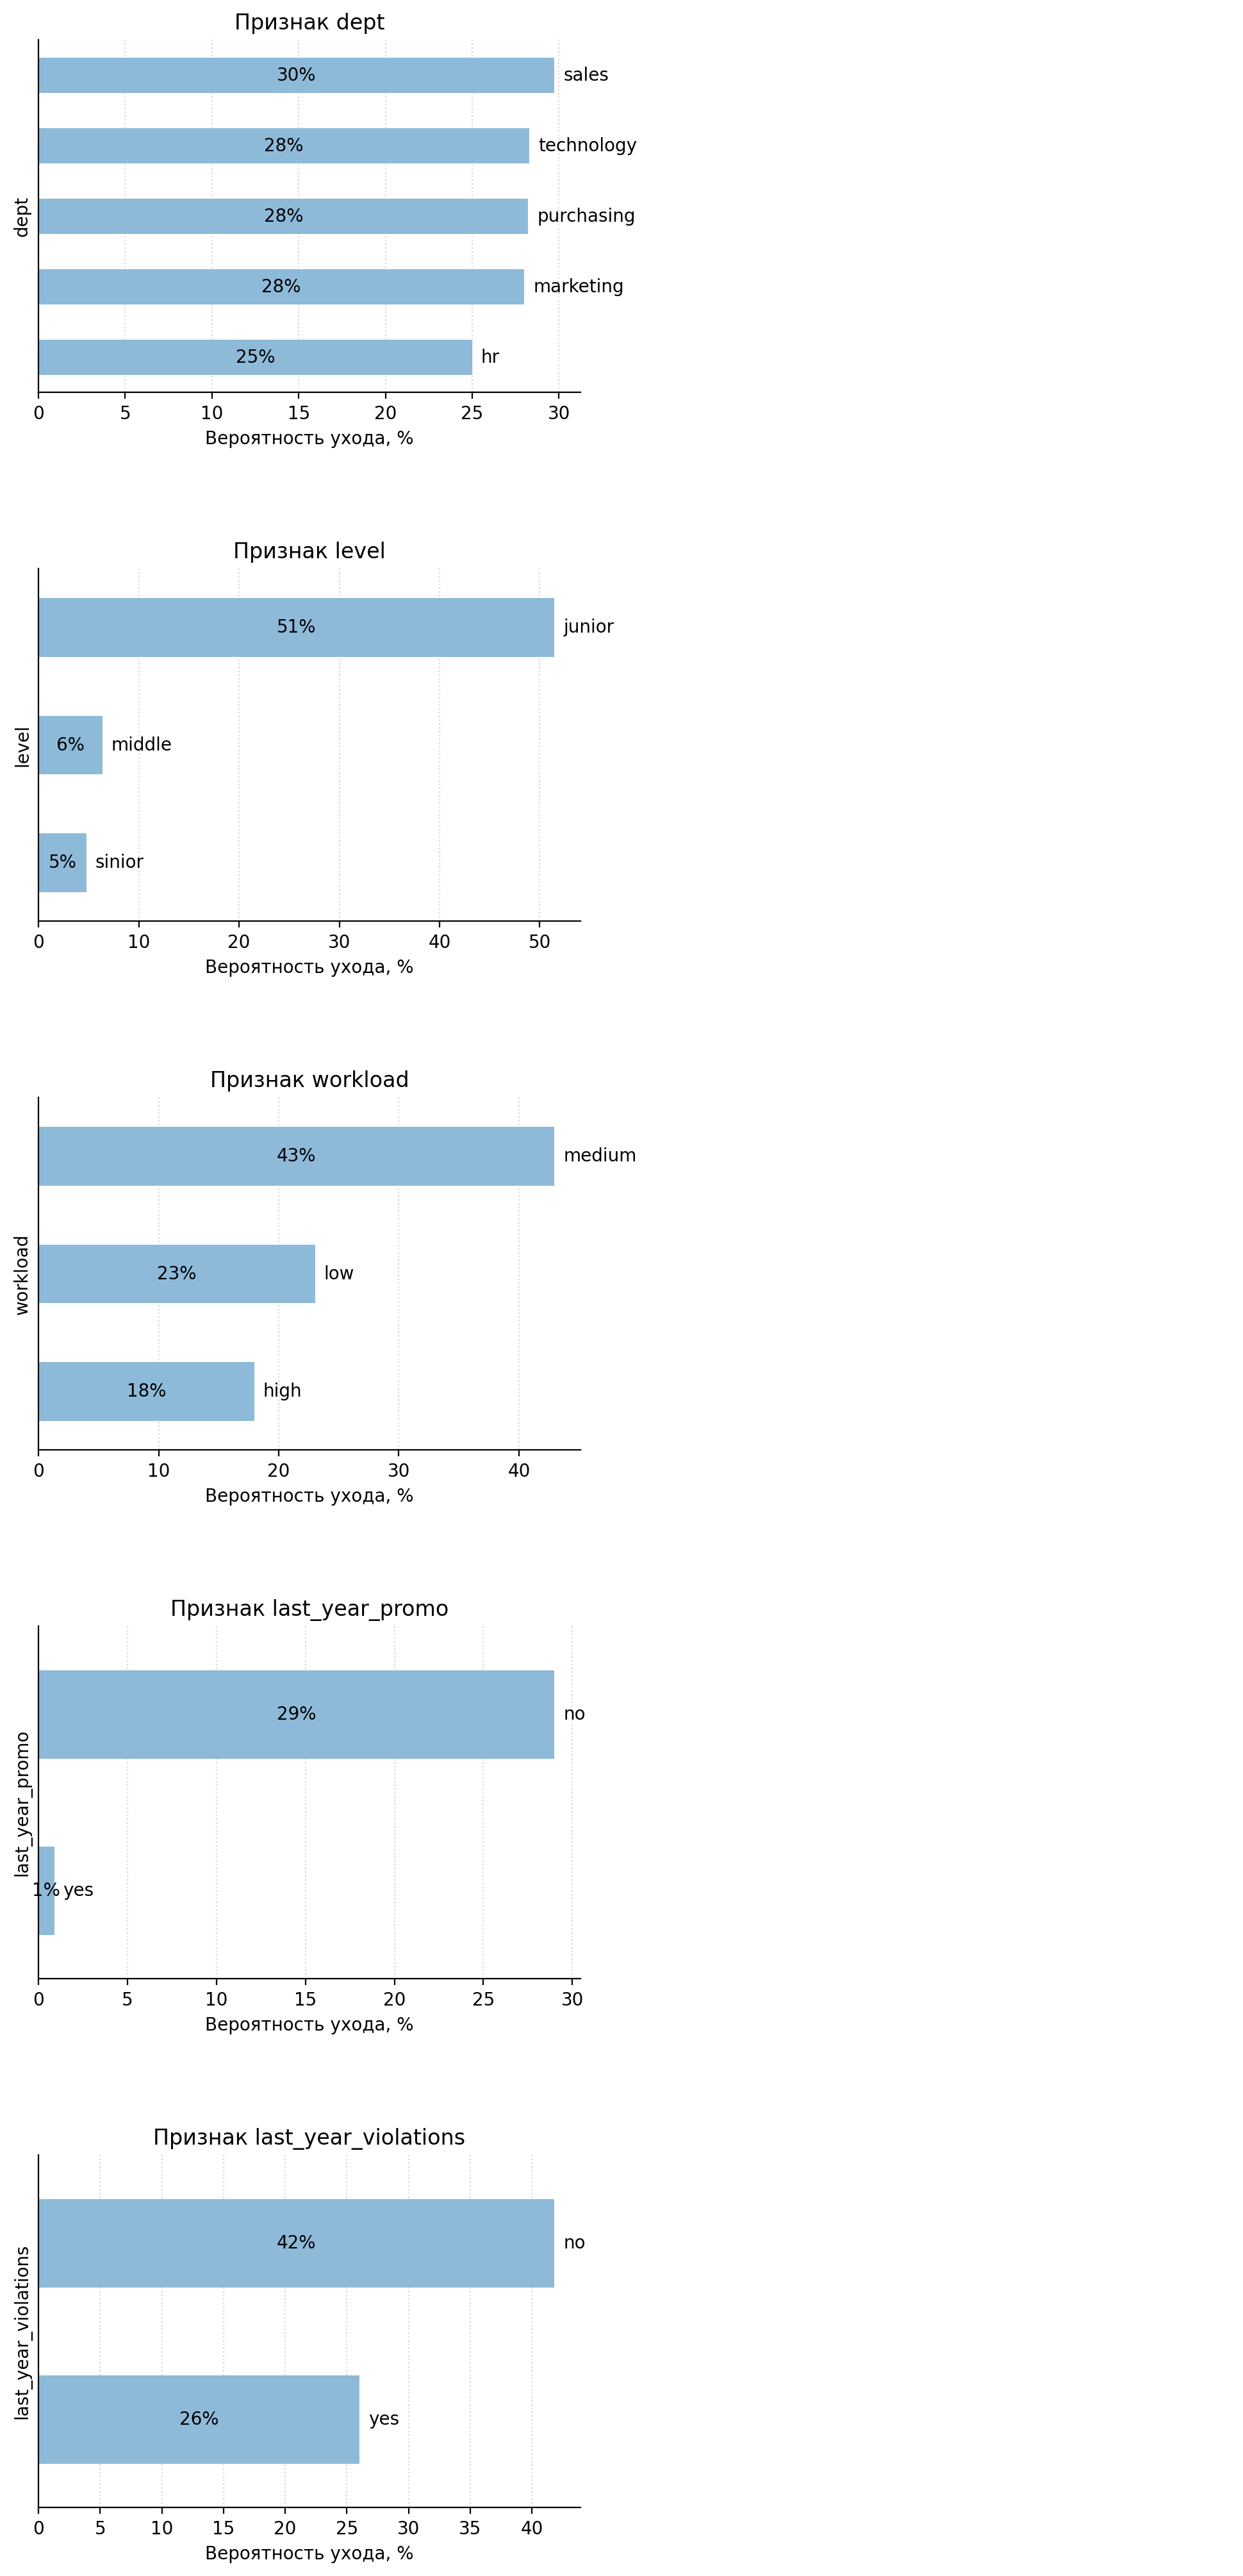

In [106]:
num_col_names = quit_train.select_dtypes(exclude='number').columns.drop('quit')

n = len(num_col_names)
fig, axes = plt.subplots(n, 2, figsize=(12, n * 5))
fig.subplots_adjust(hspace=0.5)

for ind, col_name in enumerate(num_col_names):
    ax1, ax2 = axes[ind, 0], axes[ind, 1]

    grouped = (quit_train.groupby([col_name])['quit']
               .agg(lambda x: (x == 'yes').sum() / len(x))
               .sort_values(ascending=True) * 100)
    
    col = quit_train[col_name].value_counts(normalize=True).sort_values() * 100
    grouped.plot(kind='barh', ax=ax1, color='#8ebad9')
    ax1.bar_label(axes[ind, 0].containers[0], fmt='%.0f%%', label_type='center')
    ax1.bar_label(axes[ind, 0].containers[0], labels=col.index, label_type='edge', padding=5)
    ax1.set_title(f'Признак {col_name}')
    ax1.set_xlabel('Вероятность ухода, %')
    ax1.set_yticks([])
    ax1.set_axisbelow(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='x', alpha=0.5, linestyle=':')
    
    ax2.set_axis_off()
    
plt.show()

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение — объединим оба целевых признака тестовой выборки.

In [108]:
quit_vs_jsr_test_target = quit_test_target.join(jsr_test_target)
quit_vs_jsr_test_target.shape

(2000, 2)

In [109]:
quit_vs_jsr_test_target.isna().sum().sum()

0

Пропусков нет — объединение прошло успешно.

Построим распределения признака `job_satisfaction_rate` с уровенем удовлетворённости сотрудника для ушедших и оставшихся сотрудников.

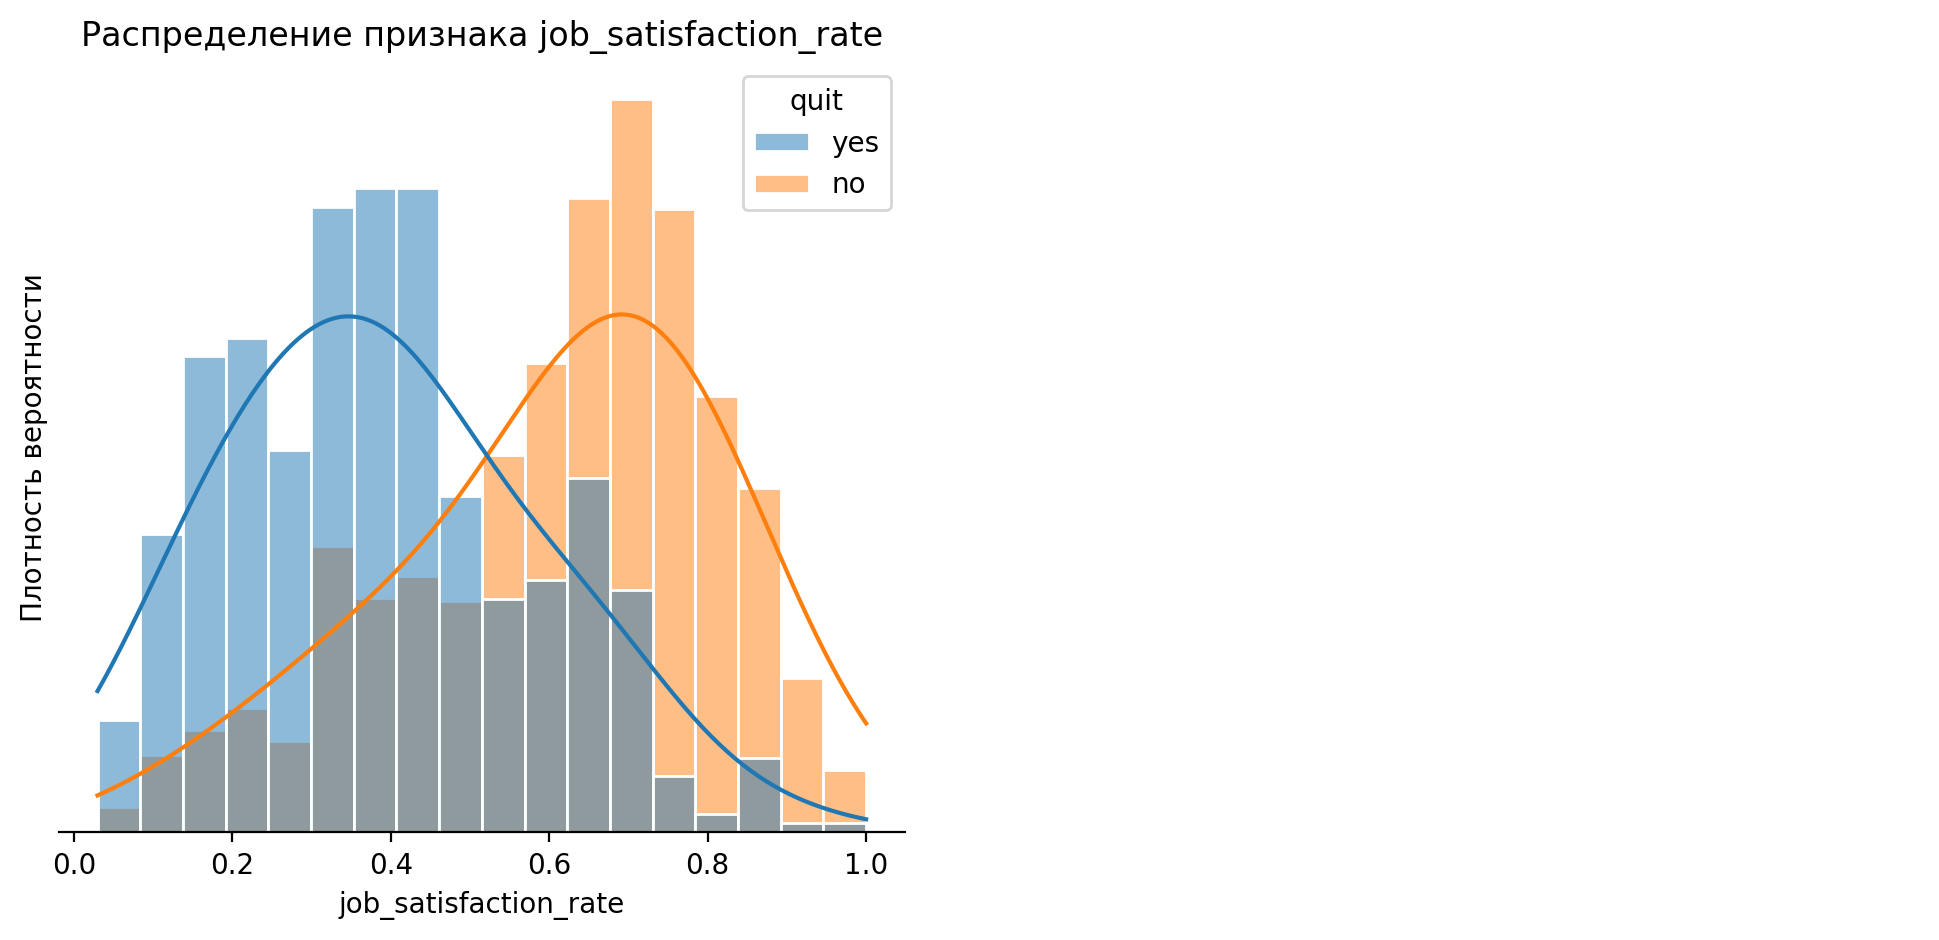

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(quit_vs_jsr_test_target, x='job_satisfaction_rate', ax=ax1, hue='quit', stat='density', common_norm=False, 
             kde=True, kde_kws={'bw_method': 0.6}, edgecolor='white')
ax1.set_title('Распределение признака job_satisfaction_rate')
ax1.set_xlabel('job_satisfaction_rate')
ax1.set_ylabel('Плотность вероятности')
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2.set_axis_off()

plt.show()

Судя по диаграмме распределения уход сотрудника действительно может быть связан с его уровенем удовлетворённости. Проведем статистический тест для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Нулевая гипотеза — «между средними значениями двух совокупностей нет разницы, они равны», а альтернативная — «средние значения двух совокупностей не равны».

In [114]:
alpha = 0.01 # уровень статистической значимости
results = st.ttest_ind(quit_vs_jsr_test_target.query('quit == "yes"')['job_satisfaction_rate'].values, 
                       quit_vs_jsr_test_target.query('quit == "no"')['job_satisfaction_rate'].values, 
                       alternative='two-sided')
display(f'p-значение: {results.pvalue}')
if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу') 

'p-значение: 1.2311220665173681e-104'

'Отвергаем нулевую гипотезу'

Добавим признак `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [116]:
quit_train['job_satisfaction_rate_pred'] = jsr_search_model_cv.predict(quit_train)
quit_test_features['job_satisfaction_rate_pred'] = jsr_search_model_cv.predict(quit_test_features)

Рассчитаем коэффициенты корреляции Фи  между всеми признаками в датафрейме с тренировочной выборкой. Посмотрим тепловую карту матрицы корреляций.

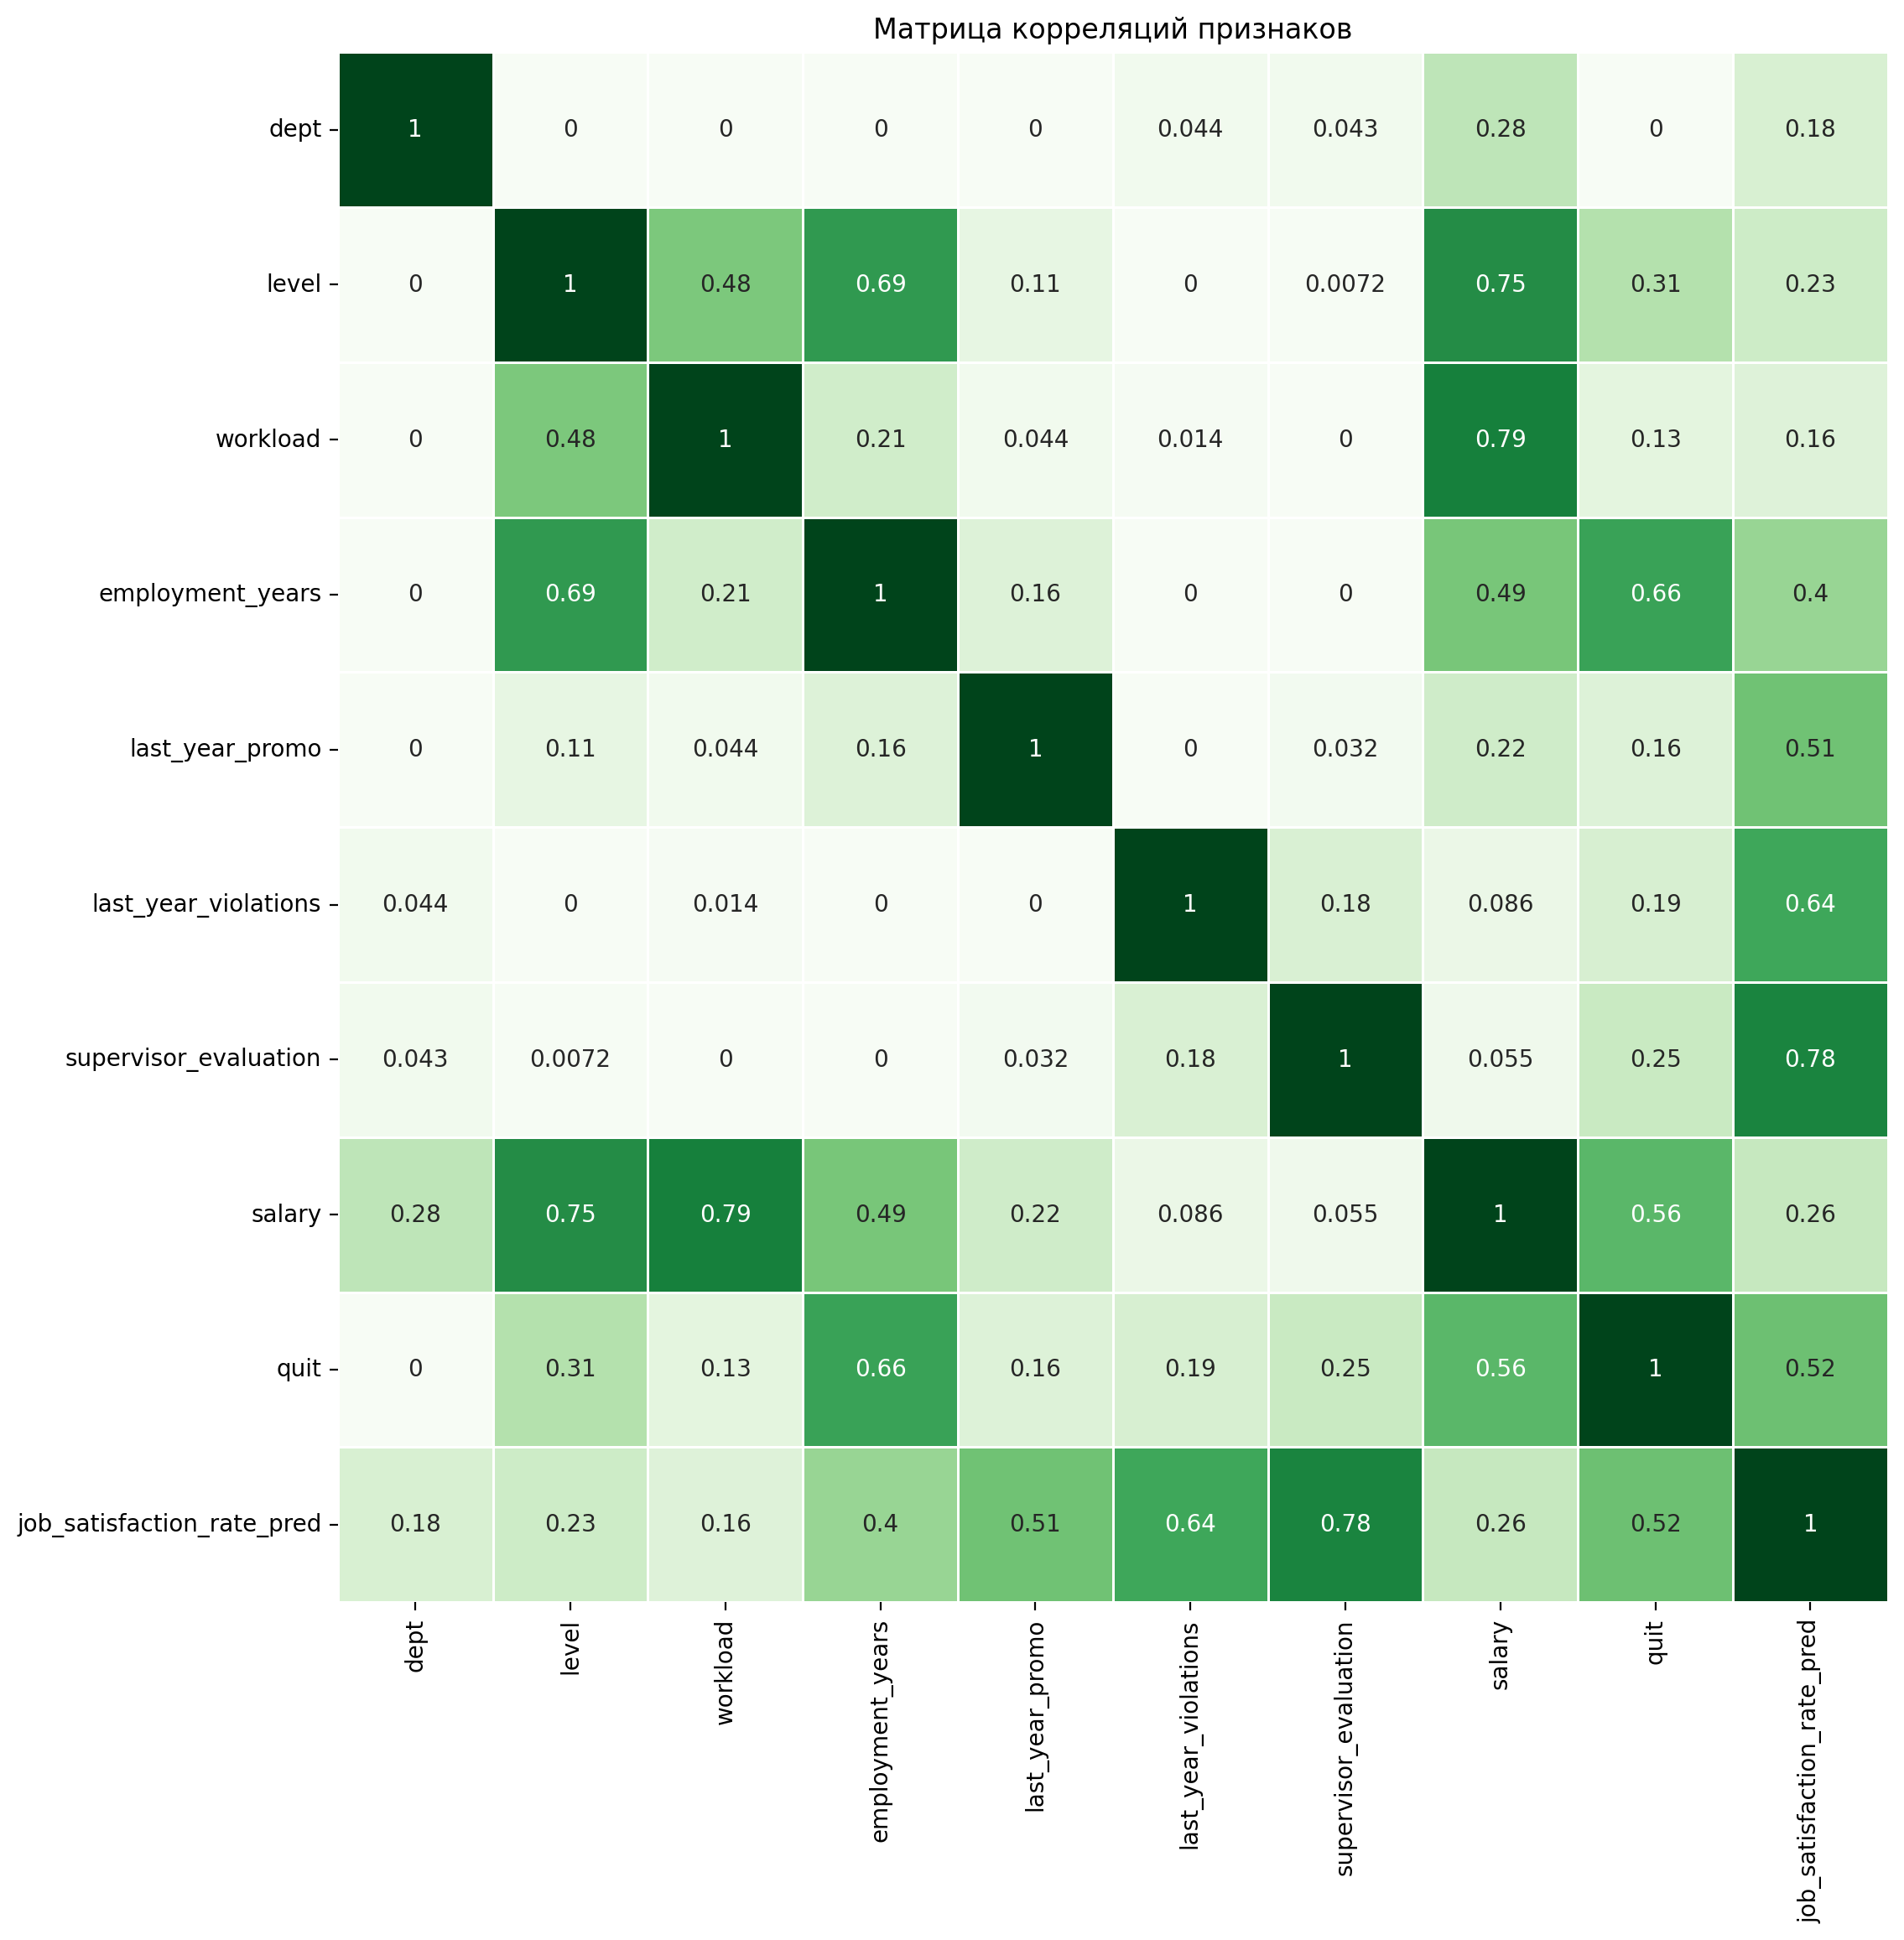

In [118]:
interval_col_names = ['salary', 'job_satisfaction_rate_pred']
corr_coefficients = quit_train.phik_matrix(interval_cols=interval_col_names)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(corr_coefficients, annot=True, square=True, cbar=False, linewidths=0.5, cmap='Greens', ax=ax)
ax.set_title('Матрица корреляций признаков')
plt.show()

Заметную и высокую корреляцию с целевым признаком показывают признаки `job_satisfaction_rate` (уровень удовлетворённости сотрудника работой в компании), `salary` (ежемесячная зарплата сотрудника) и `employment_years` (длительность работы в компании).

#### Тестовая выборка

Сравним распределения количественных признаков в тренировочной и тестовой выборках.

In [122]:
num_col_names = ['employment_years', 'supervisor_evaluation', 'salary']

describe_train = quit_train[num_col_names].describe().T.reset_index(names='признак')
describe_train['выборка'] = 'тренировочная'

describe_test = quit_test_features[num_col_names].describe().T.reset_index(names='признак')
describe_test['выборка'] = 'тестовая'

displayed_col_names = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
pd.concat([describe_train, describe_test]).pivot_table(index=['признак', 'выборка'], aggfunc='first')[displayed_col_names]

mean           std      min  \
признак               выборка                                             
employment_years      тестовая           3.66650      2.537222      1.0   
                      тренировочная      3.70150      2.541852      1.0   
salary                тестовая       34066.80000  15398.436729  12000.0   
                      тренировочная  33805.80000  15152.415163  12000.0   
supervisor_evaluation тестовая           3.52650      0.996892      1.0   
                      тренировочная      3.47475      1.004049      1.0   

                                         25%      50%      75%      max  
признак               выборка                                            
employment_years      тестовая           1.0      3.0      6.0     10.0  
                      тренировочная      2.0      3.0      6.0     10.0  
salary                тестовая       22800.0  30000.0  43200.0  96000.0  
                      тренировочная  22800.0  30000.0  43200.0  96000.0  
supervisor_evaluation тестовая           3.0      4.0      4.0      5.0  
                      тренировочная      3.0      4.0      4.0      5.0

Существенных различий в части распределений количественных признаков нет.

In [124]:
cat_col_names = quit_train.select_dtypes(exclude='number').columns.drop('quit')

feature_values = pd.DataFrame(columns=['признак', 'выборка', 'значения'])
for col_name in cat_col_names:
    feature_values.loc[len(feature_values)] = [col_name, 'тренировочная', 
                                               ', '.join(sorted(f"'{x}'" for x in quit_train[col_name].unique()))]
    feature_values.loc[len(feature_values)] = [col_name, 'тестовая', 
                                               ', '.join(sorted(f"'{x}'" for x in quit_test_features[col_name].unique()))]
feature_values.pivot_table(index=['признак', 'выборка'], aggfunc='first')

значения
признак              выборка                                                                          
dept                 тестовая       ' ', 'hr', 'marketing', 'nan', 'purchasing', 'sales', 'technology'
                     тренировочная              'hr', 'marketing', 'purchasing', 'sales', 'technology'
last_year_promo      тестовая                                                              'no', 'yes'
                     тренировочная                                                         'no', 'yes'
last_year_violations тестовая                                                              'no', 'yes'
                     тренировочная                                                         'no', 'yes'
level                тестовая                                      'junior', 'middle', 'nan', 'sinior'
                     тренировочная                                        'junior', 'middle', 'sinior'
workload             тестовая                                             ' ', 'high', 'low', 'medium'
                     тренировочная                                             'high', 'low', 'medium'

Отличий в значениях категориальных признаков нет. В тестовой выборке есть пропуски в значениях признаков `dept` и `level`, а также пробелы в значениях признаков `dept` и `workload` — учтем при подготовке признаков в пайплайне.

Сравним коэффициенты корреляции Фи между всеми признаками в датафреймах с тренировочной и тестовой выборками. Посмотрим тепловую карту разницы матриц корреляций.

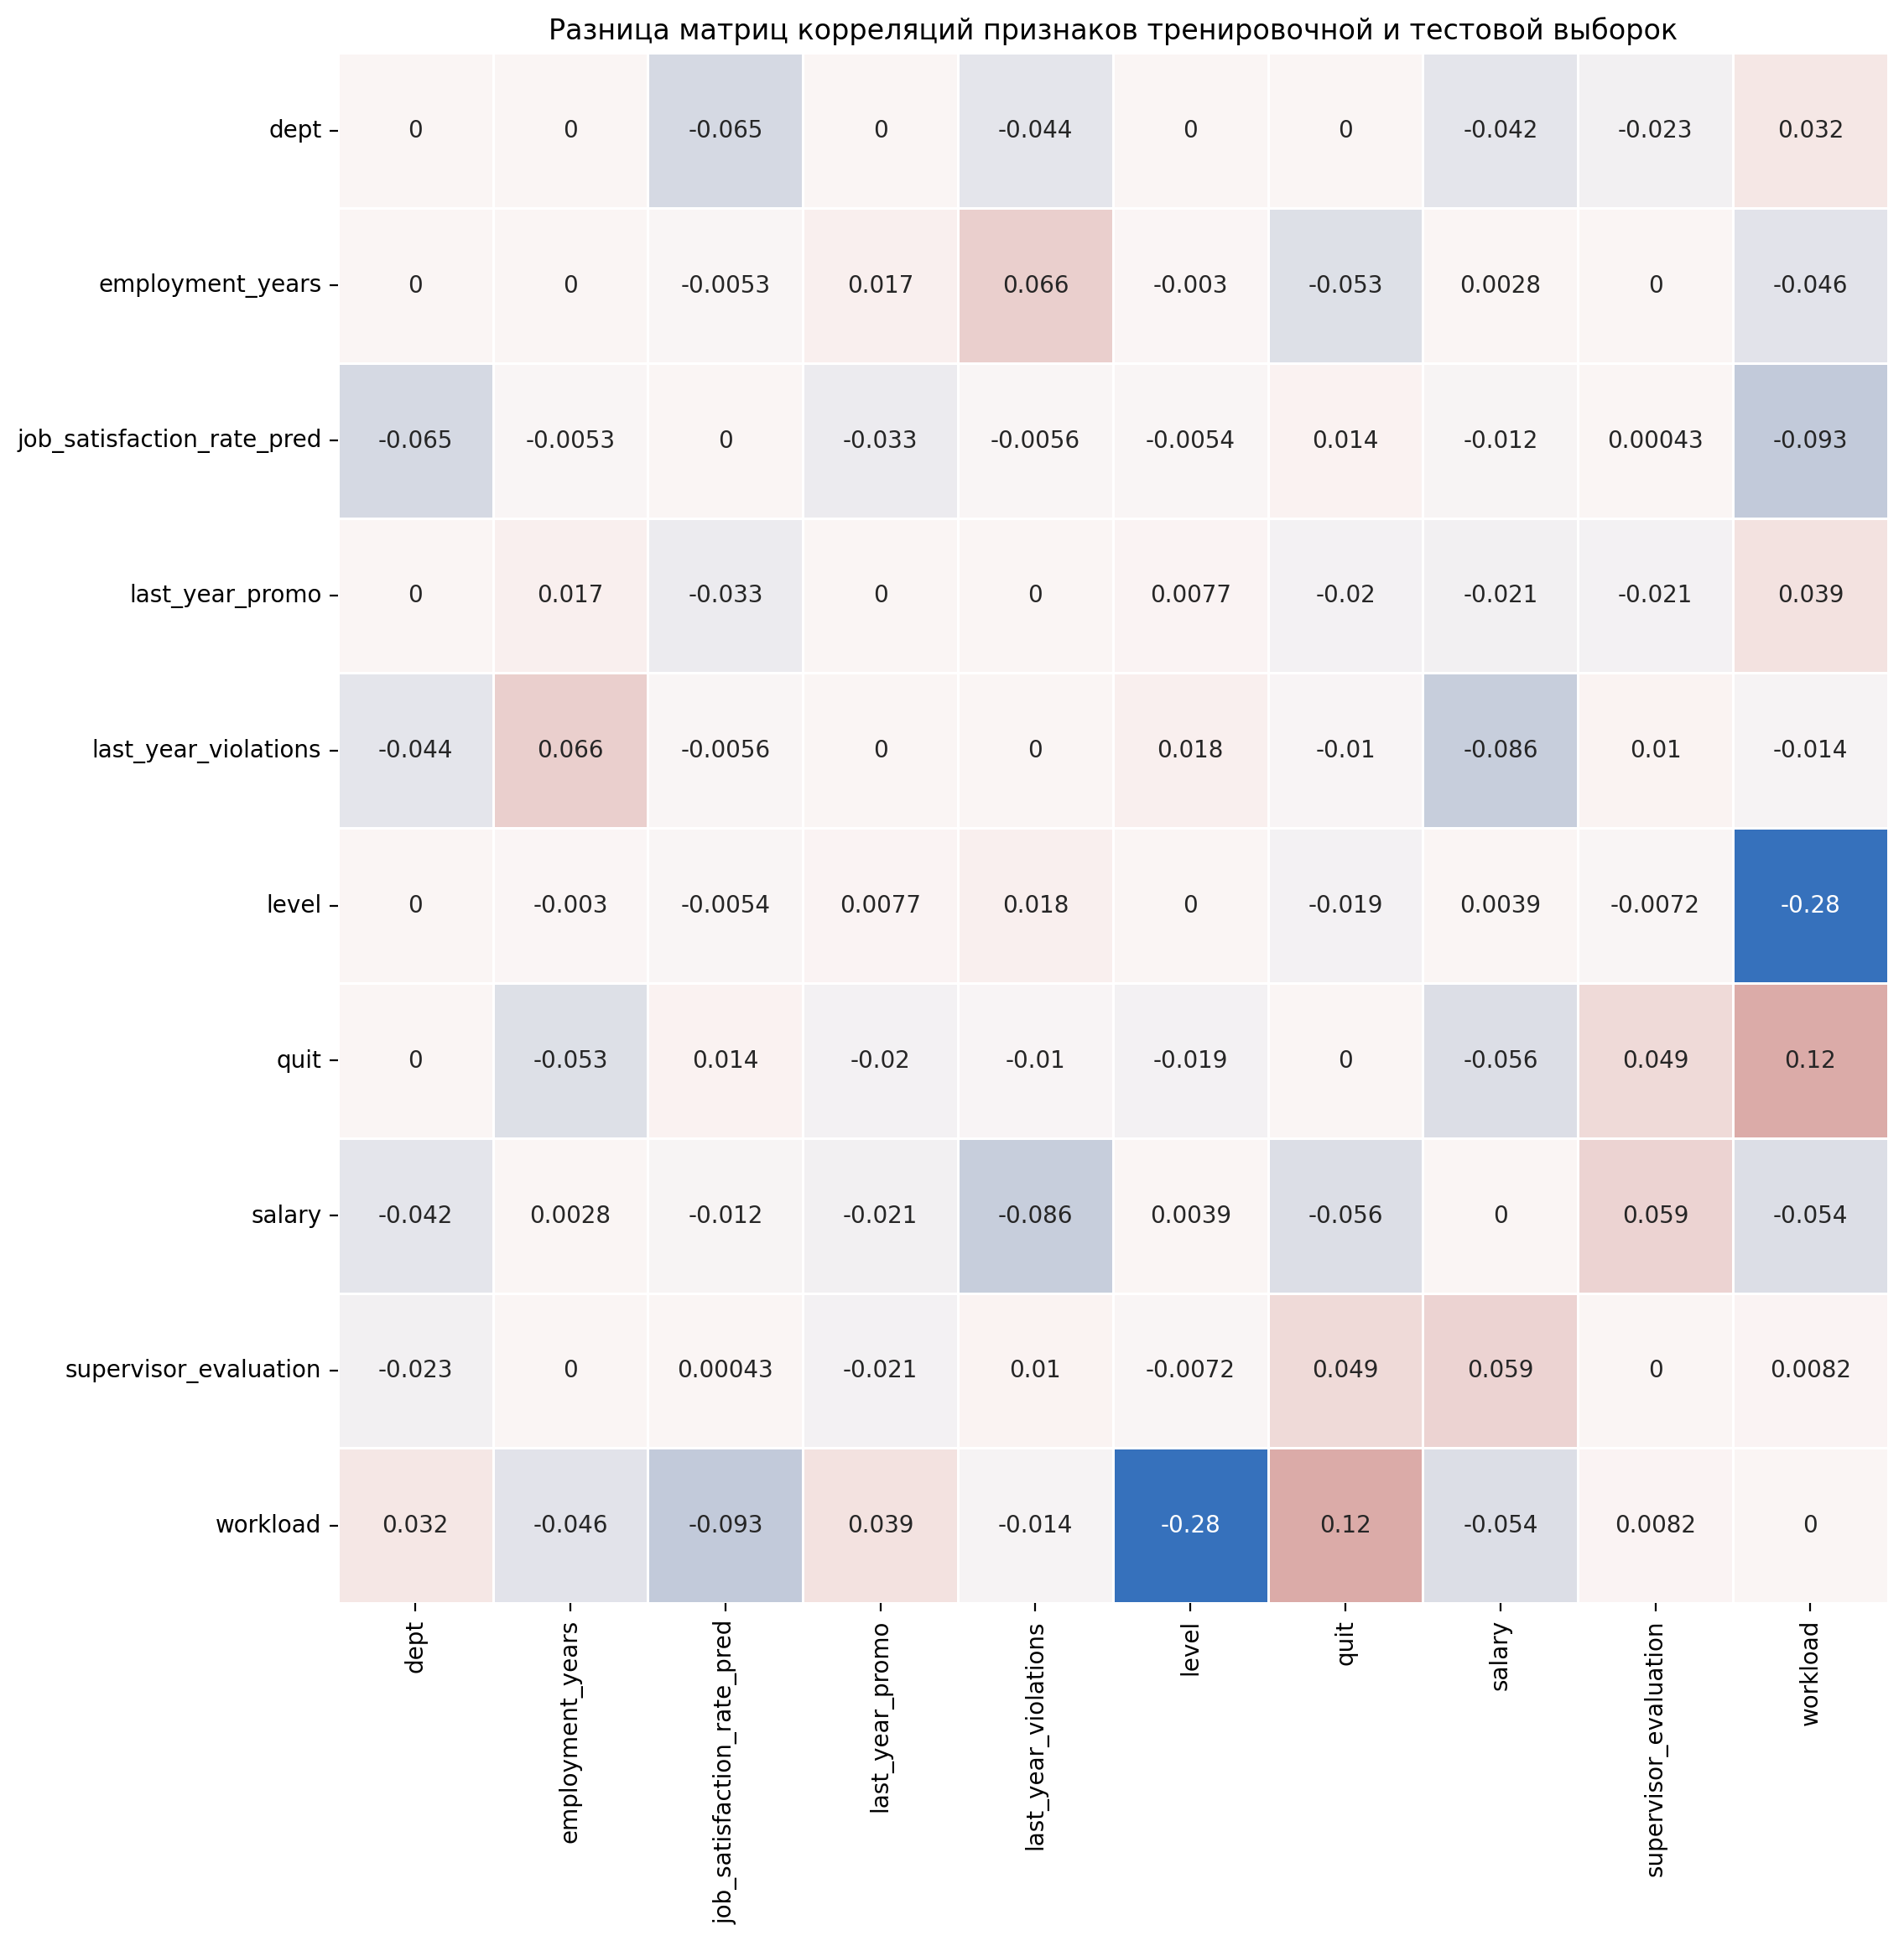

In [127]:
interval_col_names = ['salary', 'job_satisfaction_rate']
quit_train_corr_coefficients = quit_train.phik_matrix(interval_cols=interval_col_names)
quit_test_corr_coefficients = quit_test_features.join(quit_test_target).phik_matrix(interval_cols=interval_col_names)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(quit_test_corr_coefficients - quit_train_corr_coefficients, annot=True, square=True, 
            cbar=False, linewidths=0.5, cmap=sns.color_palette('vlag', as_cmap=True), vmin=-0.30, vmax=0.30, ax=ax)
ax.set_title('Разница матриц корреляций признаков тренировочной и тестовой выборок')
plt.show()

Заметно, что в тестовой выборке незначительно увеличилась корреляция целевого признака `quit` (увольнение сотрудника из компании) с признаком `workload` (уровень загруженности сотрудника). Также можно отметить снижение корреляции признаков `level` (уровень занимаемой должности) и `workload` (уровень загруженности сотрудника). Однако существенных отличий не обнаружено.

### Подготовка данных

Для автоматизации действий по подготовке данных (кодирование категориальных признаков и масштабирование количественных признаков) будем использовать пайплайны. При кодировании учтем ранговые признаки `level` (уровень занимаемой должности) и `workload` (уровень загруженности сотрудника).

In [131]:
quit_ohe_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
)

quit_ord_transformer = Pipeline(
    steps=[('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ('encoder', OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], 
                                                  ['low', 'medium', 'high']],
                                      handle_unknown='use_encoded_value', unknown_value=np.nan)),
           ('imputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)

quit_num_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
           ('scaler', MinMaxScaler())]
)

quit_data_preprocessor = ColumnTransformer(
    transformers=[('ohe', quit_ohe_transformer, ['dept', 'last_year_promo', 'last_year_violations']),
                  ('ord', quit_ord_transformer, ['level', 'workload']),
                  ('num', quit_num_transformer, ['employment_years', 'supervisor_evaluation', 
                                                 'salary', 'job_satisfaction_rate_pred'])], 
    remainder='drop', 
    verbose_feature_names_out=False
)

### Обучение моделей

Обучим несколько моделей, которые предскажут увольнение сотрудника из компании (задача сводится к бинарной классификации) и выберем лучшую из них.

In [134]:
X_train = quit_train.sort_index().drop('quit', axis=1)
y_train = quit_train.sort_index()['quit']
X_test = quit_test_features.sort_index()
y_test = quit_test_target.sort_index()['quit']

Для кодирования целевого признака воспользуемся кодировщиком `LabelEncoder`. Принудительно закодируем единицей положительный класс (сотрудник уволился).

In [136]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['no', 'yes'])
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

pd.DataFrame({
    'quit': label_encoder.classes_, 'encoded_value': label_encoder.transform(label_encoder.classes_)
})

quit  encoded_value
0   no              0
1  yes              1

Создадим итоговый пайплайн, включающий подготовку данных, отбор признаков и модель.

In [138]:
quit_final_pipe = Pipeline(steps=[('preprocessor', quit_data_preprocessor), 
                                  ('selector', 'passthrough'), 
                                  ('model', LogisticRegression(random_state=RANDOM_STATE))])

Начнем с дамми-модели, предсказывающей вероятности распределения классов как в тренировочной выборке.

In [140]:
quit_dummy_model = DummyClassifier(strategy='prior')
quit_dummy_model.fit(X_train, y_train)

score_test = roc_auc_score(y_test, quit_dummy_model.predict_proba(X_test)[:, 1])
display(f'Метрика ROC-AUC на тестовой выборке: {score_test:.4f}')

'Метрика ROC-AUC на тестовой выборке: 0.5000'

В качестве моделей возьмем:
- логистическую регрессию `LogisticRegression()`,
- модель дерева решений `DecisionTreeClassifier()`,
- метод k-ближайших соседей `KNeighborsClassifier()`,
- метод опорных векторов `SVC()`.

Подберем гиперпараметры с помощью класса `GridSearchCV`. В качестве метрики оценки качества будем использовать ROC-AUC.

In [142]:
cell_start_time = time.time()

param_grid = [
    {
        'preprocessor__num': [MinMaxScaler()],
        'selector': [SelectKBest(f_classif)],
        'selector__k': range(4, 16),
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'model__C': range(1, 6)
    },
    {
        'preprocessor__num': ['passthrough'],
        'selector': [SelectKBest(f_classif)],
        'selector__k': range(4, 16),
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, 11),
        'model__min_samples_split': range(2, 6),
        'model__min_samples_leaf': range(1, 6)
    },
    {
        'preprocessor__num': [MinMaxScaler(), StandardScaler()],
        'selector': [SelectKBest(f_classif)],
        'selector__k': range(4, 16),
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(1, 20),
        'model__metric': ['cityblock', 'euclidean']
    },
    {
        'preprocessor__num': [MinMaxScaler()],
        'selector': [SelectKBest(f_classif)],
        'selector__k': range(4, 16),
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__C': [1, 2, 20]
    }
]

In [143]:
quit_search_model_cv = GridSearchCV(quit_final_pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
quit_search_model_cv.fit(X_train, y_train)

display(f'На подбор гиперпараметров затрачено времени: {time.time() - cell_start_time:.0f} сек')
display(f'Метрика ROC-AUC при кросс-валидации: {quit_search_model_cv.best_score_:.4f}')

score_test = roc_auc_score(y_test, quit_search_model_cv.predict_proba(X_test)[:, 1])
display(f'Метрика ROC-AUC на тестовой выборке: {score_test:.4f}')

'На подбор гиперпараметров затрачено времени: 216 сек'

'Метрика ROC-AUC при кросс-валидации: 0.9347'

'Метрика ROC-AUC на тестовой выборке: 0.9200'

Посмотрим на результаты лучших моделей каждого типа.

In [145]:
cv_results_df = pd.DataFrame(quit_search_model_cv.cv_results_).sort_values('rank_test_score')
cv_results_df['model_name'] = cv_results_df['param_model'].apply(lambda x: x.__class__.__name__)

grouped = cv_results_df.pivot_table(index='model_name', aggfunc='first').sort_values('rank_test_score')
grouped[['params', 'mean_test_score', 'rank_test_score']]

params  \
model_name                                                                                                                                                                                                                                         
KNeighborsClassifier                                                {'model': KNeighborsClassifier(), 'model__metric': 'cityblock', 'model__n_neighbors': 10, 'preprocessor__num': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 10}   
SVC                                                                                         {'model': SVC(probability=True, random_state=42), 'model__C': 20, 'preprocessor__num': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 13}   
DecisionTreeClassifier  {'model': DecisionTreeClassifier(random_state=42), 'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'preprocessor__num': 'passthrough', 'selector': SelectKBest(), 'selector__k': 14}   
LogisticRegression                                            {'model': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'model__C': 5, 'preprocessor__num': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 15}   

                        mean_test_score  rank_test_score  
model_name                                                
KNeighborsClassifier           0.934725                1  
SVC                            0.932808               52  
DecisionTreeClassifier         0.929103              362  
LogisticRegression             0.917129             2145

Лучше всего справилась модель `KNeighborsClassifier()` с гиперпараметрами `metric='cityblock'`, `n_neighbors=9` и скейлером `MinMaxScaler()`. Модель удовлетворяет поставленному критерию успеха (ROC-AUC≥0.91 на тестовой выборке).

Оценим важность признаков для лучшей модели и построим графики важности с помощью метода SHAP.

In [ ]:
prepared_col_names = quit_search_model_cv.best_estimator_.named_steps['selector'].get_feature_names_out(
    input_features=quit_search_model_cv.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)
prepared_X_train = quit_search_model_cv.best_estimator_.named_steps['selector'].transform(
    quit_search_model_cv.best_estimator_.named_steps['preprocessor'].transform(X_train)
)
prepared_X_test = quit_search_model_cv.best_estimator_.named_steps['selector'].transform(
    quit_search_model_cv.best_estimator_.named_steps['preprocessor'].transform(X_test)
)

explainer = shap.KernelExplainer(
    quit_search_model_cv.best_estimator_.named_steps['model'].predict,
    shap.kmeans(prepared_X_train, 20), 
    prepared_col_names
)

shap_values = explainer(shap.sample(prepared_X_test, 200, random_state=RANDOM_STATE))

Для визуализации вклада признаков в каждое предсказание модели используем диаграмму `shap.plots.beeswarm`. На оси 
X отложены значения Шепли, на оси Y — признаки модели, расположенные сверху вниз в порядке убывания средних SHAP‑значений.

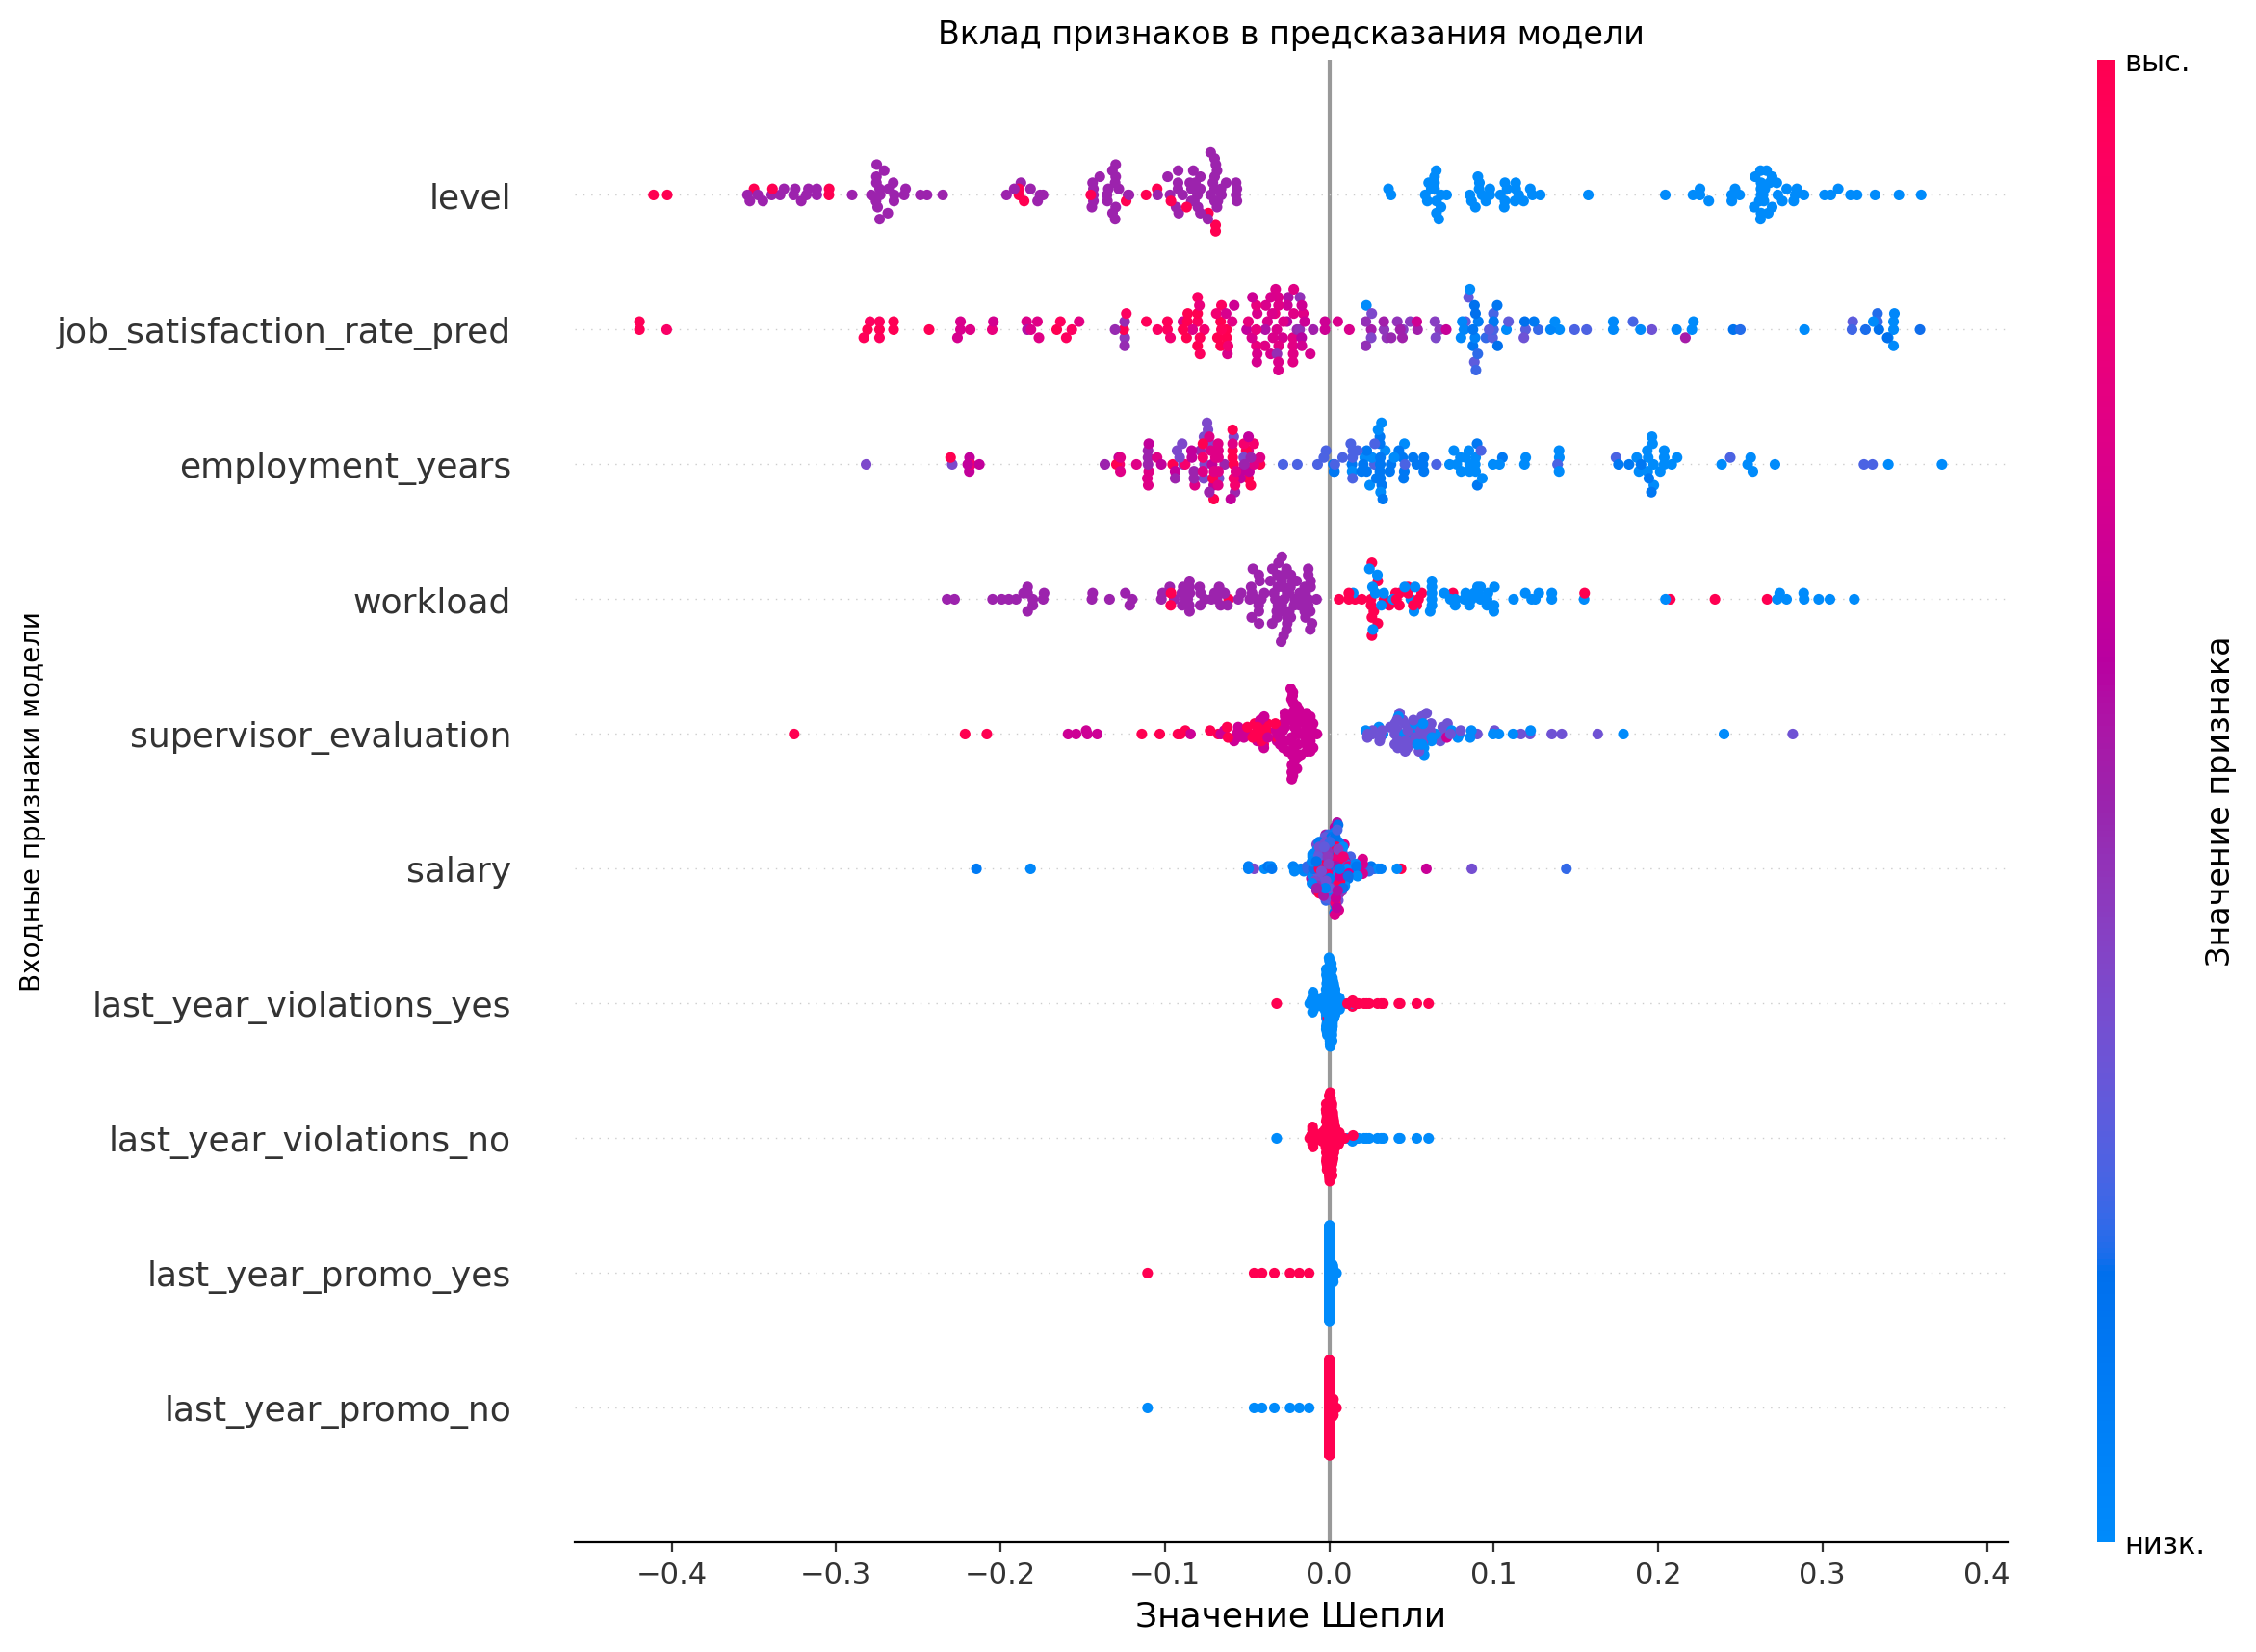

In [150]:
shap.plots.beeswarm(shap_values, max_display=len(prepared_col_names), show=False, plot_size=(12, 10))
fig, ax = plt.gcf(), plt.gca()
ax.set_title('Вклад признаков в предсказания модели')
ax.set_xlabel('Значение Шепли')
ax.set_ylabel('Входные признаки модели')
fig.axes[-1].set_ylabel('Значение признака')
fig.axes[-1].set_yticklabels(['низк.', 'выс.'])
plt.show()

Для оценки общего вклада признаков в прогнозы модели используем диаграмму `shap.plots.bar`.

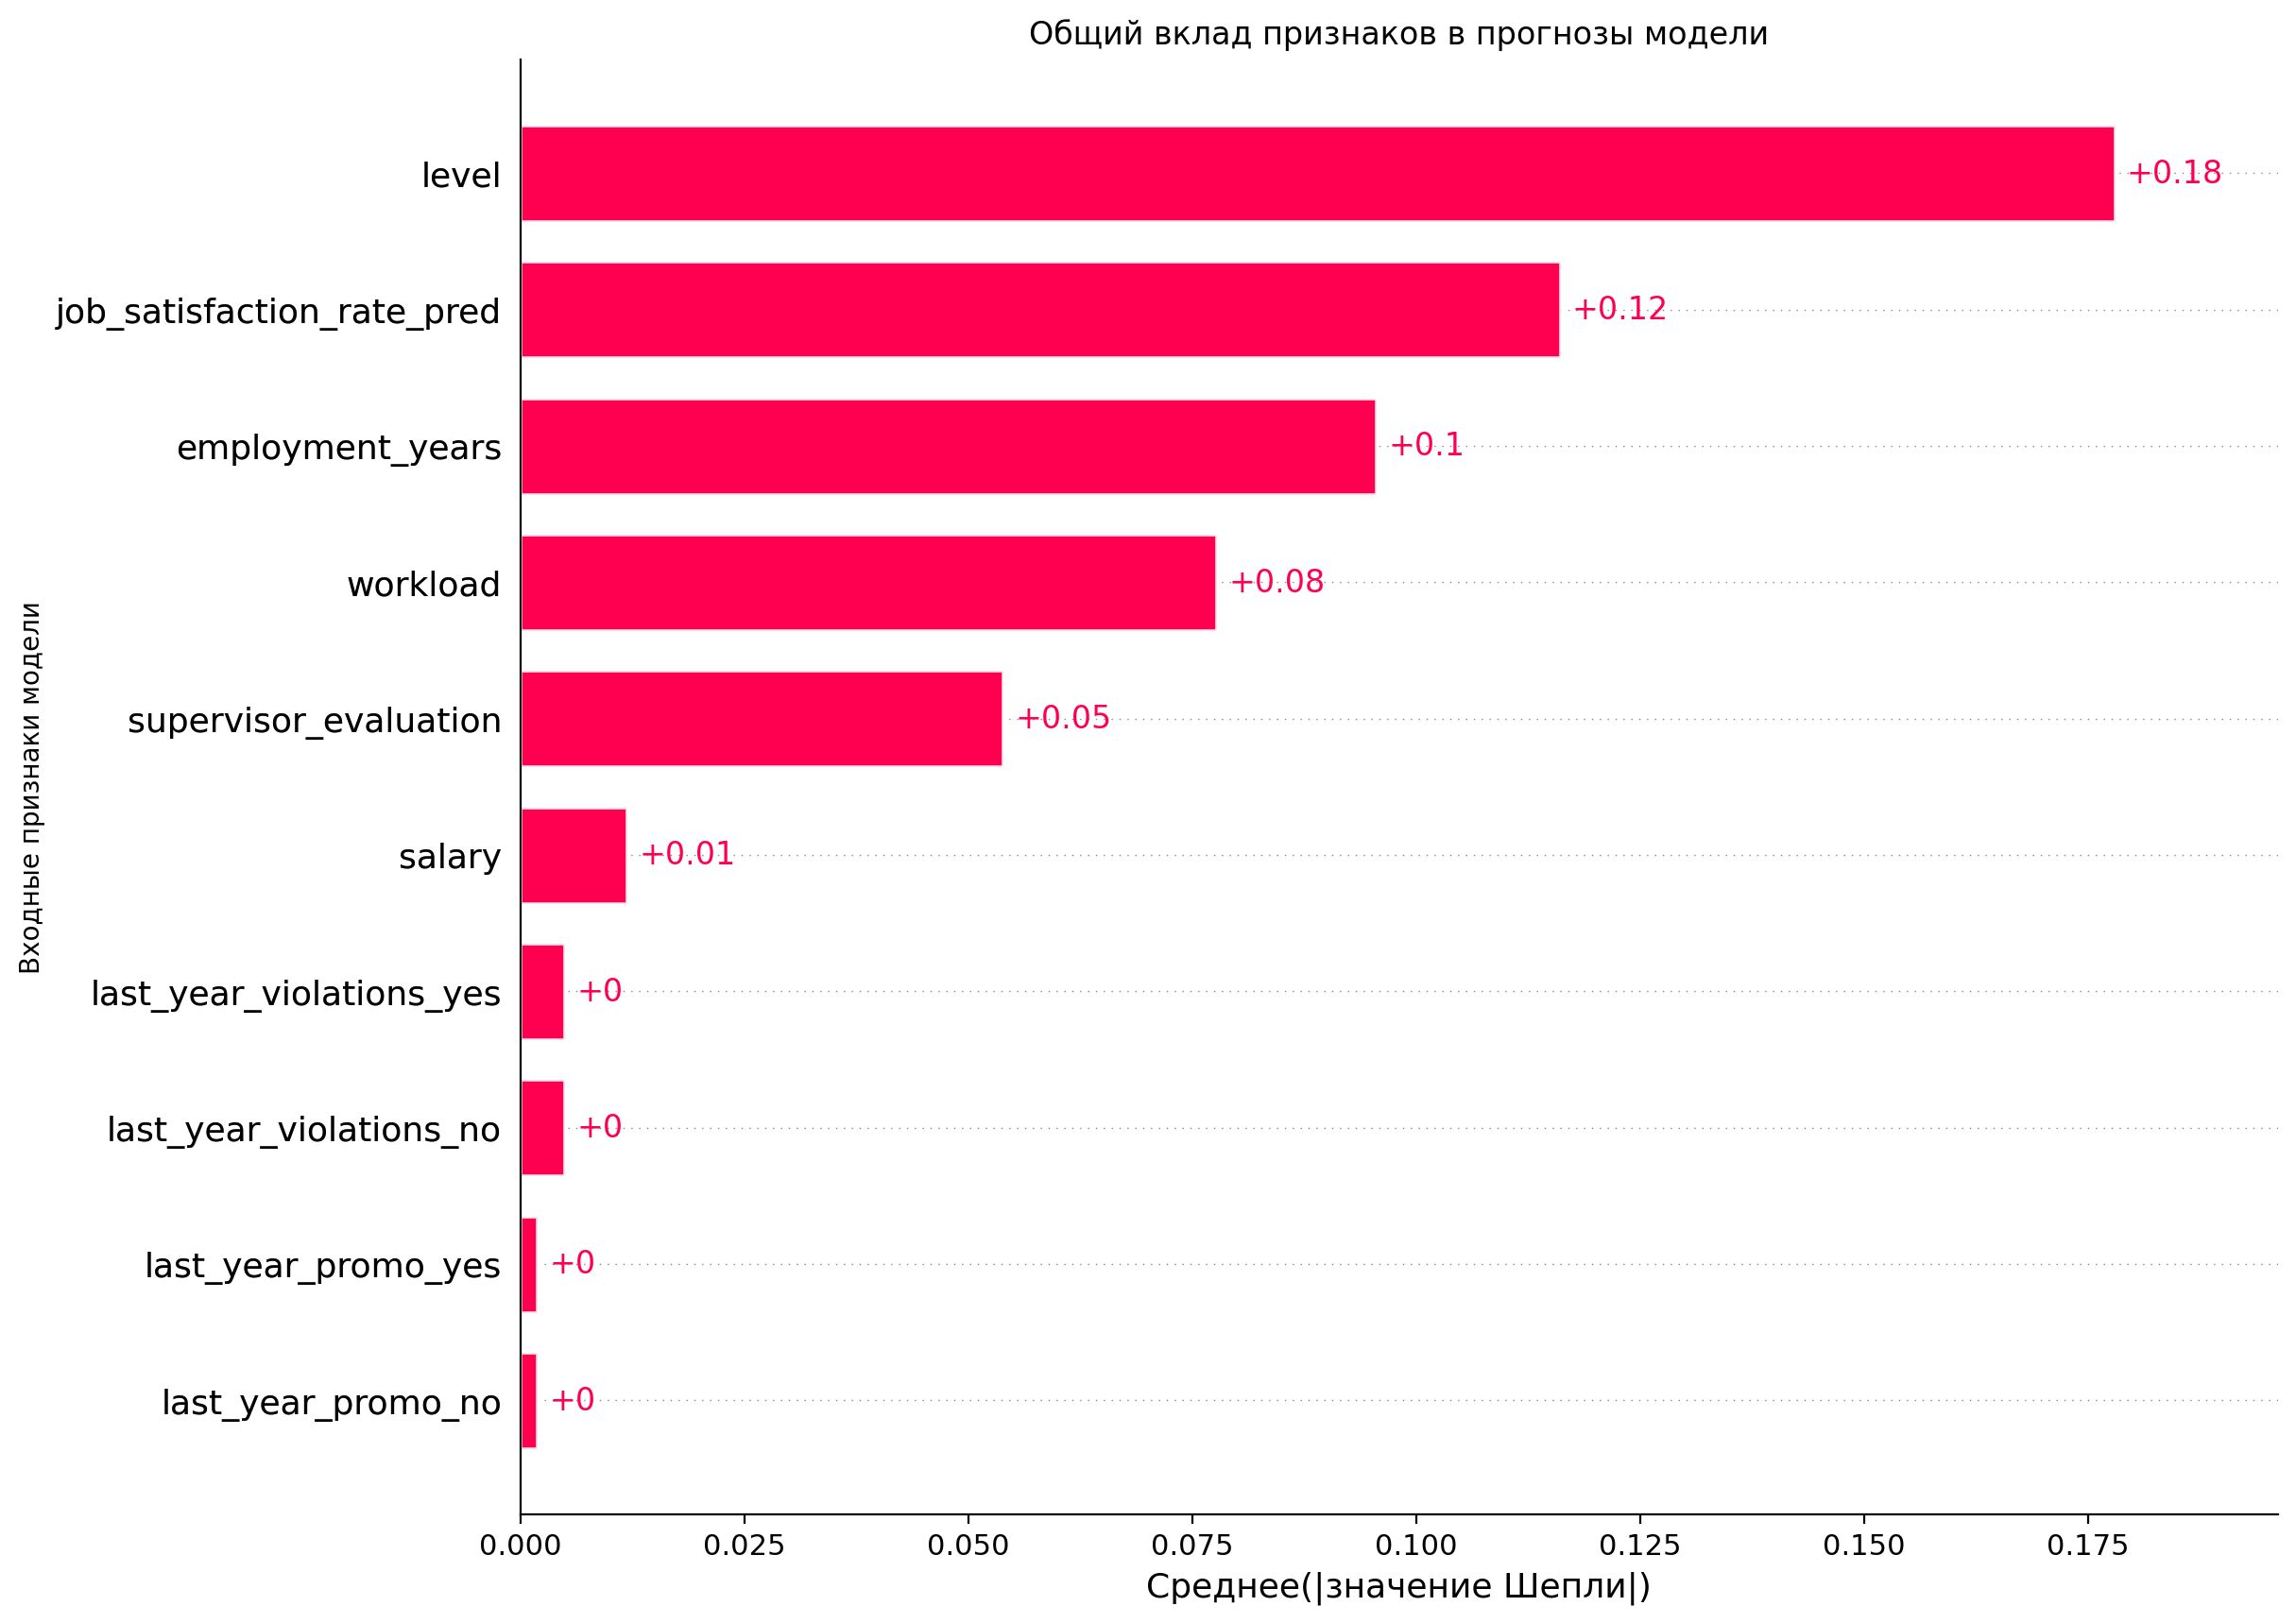

In [152]:
fig, ax = plt.subplots(figsize=(12, 10))
shap.plots.bar(shap_values, max_display=len(prepared_col_names), show=False, ax=ax)
ax.set_title('Общий вклад признаков в прогнозы модели')
ax.set_xlabel('Среднее(|значение Шепли|)')
ax.set_ylabel('Входные признаки модели')
plt.show()

Оценка важности признаков с помощью вычислений значений Шепли показывают схожие результаты в признаках, которые сильнее всего влияют на классификацию:
- `level` — уровень занимаемой должности;
- `job_satisfaction_rate_pred` — уровень удовлетворённости сотрудника работой в компании;
- `employment_years` — длительность работы в компании;
- `workload` — уровень загруженности сотрудника;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель.

Исходя из анализа важности признаков можно сделать несколько выводов, которые могут быть полезны при принятии бизнес-решений:
- Чем ниже уровень занимаемой должности, тем больше вероятность увольнения сотрудника.
- Чем ниже уровень удовлетворённости сотрудника работой в компании, тем больше вероятность увольнения сотрудника.
- Чем дольше сотрудник работает в компании, тем меньше вероятность его увольнения.
- Высокий и низкий уровени загруженности сотрудника увеличивают вероятность увольнения сотрудника.
- Низкие оценки качества работы сотрудников, которые дал их руководитель, увеличивают вероятность увольнения сотрудника.

### Вывод

Лучше всего с предсказанием увольнения сотрудника из компании справилась модель `KNeighborsClassifier()` с гиперпараметрами `metric='cityblock'`, `n_neighbors=9` и скейлером `MinMaxScaler()`. Модель удовлетворяет поставленному критерию успеха (ROC-AUC≥0.91 на тестовой выборке).

Логистическая регрессии плохо работает на данных без сильной линейной зависимости между целевым и входными признаками. Кроме того, логистическая регрессия не умеет работать с выбросами. Поэтому среди прочих моделей логистическая регрессия показа худший результат на кросс-валидации. Модель дерева решений, метод k-ближайших соседей и метод опорных векторов показали близкие значения метрики ROC-AUC, при этом метод k-ближайших соседей лучше других справился с зависимостями в данных (метрика ROC-AUC при кросс-валидации 0.9349).

## Общий вывод

В ходе исследования обработаны и проанализированы данные о 4000 сотрудниках компании «Работа с заботой». Построены модели, предсказывающие уровень удовлетворённости сотрудника и увольнения сотрудника из компании.

В процессе **предобработки данных** обнаружены дубликаты в тренировочных датасетах (). Найдено незначительное число пропусков в данных, не повлиявших на дальнейшие исследования.

По результатам **исследовательского анализа данных** можно отметить следующее:
- В признаке `salary` с ежемесячной зарплатой сотрудника есть выбросы с высокими значениями.
- В датафрейме с тренировочной выборкой содержится больше всего записей о сотрудниках из отдела продаж. В случае, если перед нами стратифицированная выборка, можно сделать вывод о том, что отдел продаж самый многочисленный.
- Сильный дисбаланс классов наблюдается у признаков `last_year_promo` и `last_year_violations`, то есть малое число сотрудников получили повышение за последний год или нарушили трудовой договор за последний год.
- Распределение целевого признака `job_satisfaction_rate` с уровенем удовлетворённости сотрудника имеет несколько пиков, то есть по целевому признаку сотрудники разделены на несколько групп.

Составлен портрет уволившегося сотрудника:
- средняя длительность работы в компании ~1.8 года (против ~4.4 года у «неуволившегося» сотрудника);
- средняя ежемесячная зарплата сотрудника ~23885 (против ~37702 у «неуволившегося» сотрудника);
- средняя оценка качества работы сотрудника, которую дал руководитель, ~3 (против ~3.6 у «неуволившегося» сотрудника);
- уволившийся сотрудник с большей вероятностью работает джуном в отделе продаж, слабо загружен, не получал повышений и не нарушал трудовой договор за последний год.

По результатам **корреляционного анализа данных** можно отметить следующее:
- Мультиколлинеарности, которая может негативно повлиять на качество моделей, не наблюдается.
- Признаки `level` (уровень занимаемой должности), `employment_years` (длительность работы в компании) и `salary` (ежемесячная зарплата сотрудника) имеют высокую взаимосвязь.
- С целевым признаком `job_satisfaction_rate` (уровень удовлетворённости сотрудника) более других коррелируют признаки `supervisor_evaluation` (оценка качества работы сотрудника, которую дал руководитель) и `last_year_violations` (нарушал ли сотрудник трудовой договор за последний год).
- Заметную и высокую корреляцию с целевым признаком `quit` (увольнение сотрудника из компании) показывают признаки `job_satisfaction_rate` (уровень удовлетворённости сотрудника работой в компании), `salary` (ежемесячная зарплата сотрудника) и `employment_years` (длительность работы в компании).

**Задача 1: предсказание уровня удовлетворённости сотрудника**

Лучше всего с предсказанием уровня удовлетворённости сотрудника справилась модель `DecisionTreeRegressor()` с гиперпараметрами `max_depth=15`, `min_samples_leaf=3` и `min_samples_split=3`. Модель удовлетворяет поставленному критерию успеха (SMAPE=13.72 на тестовой выборке). 

Самыми важными признаками в работе модели дерева решений оказались:
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `employment_years` — длительность работы в компании;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `level` — уровень занимаемой должности.

**Задача 2: предсказание увольнения сотрудника из компании**

Лучше всего с предсказанием увольнения сотрудника из компании справилась модель `KNeighborsClassifier()` с гиперпараметрами `metric='cityblock'`, `n_neighbors=9` и скейлером `MinMaxScaler()`. Модель удовлетворяет поставленному критерию успеха (ROC-AUC=0.9173 на тестовой выборке).

Оценка важности признаков с помощью вычислений значений Шепли показывают схожие результаты в признаках, которые сильнее всего влияют на классификацию:
- `level` — уровень занимаемой должности;
- `job_satisfaction_rate_pred` — уровень удовлетворённости сотрудника работой в компании;
- `employment_years` — длительность работы в компании;
- `workload` — уровень загруженности сотрудника;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель.

Исходя из анализа важности признаков можно сделать несколько выводов, которые могут быть полезны при принятии бизнес-решений:
- Чем ниже уровень занимаемой должности, тем больше вероятность увольнения сотрудника.
- Чем ниже уровень удовлетворённости сотрудника работой в компании, тем больше вероятность увольнения сотрудника.
- Чем дольше сотрудник работает в компании, тем меньше вероятность его увольнения.
- Высокий и низкий уровени загруженности сотрудника увеличивают вероятность увольнения сотрудника.
- Низкие оценки качества работы сотрудников, которые дал их руководитель, увеличивают вероятность увольнения сотрудника.

**Финальные рекомендации заказчику** после интерпретации моделей, которые могут позволить снизить вероятность ухода сотрудников:
- После интерпретации моделей можно сделать вывод, что на уход сотрудников сильно влияет уровень занимаемой должности, следовательно, стоит задуматься о подготовке мидлов и сеньоров из собственных джунов, а не о наборе извне. Это позволит уменьшить уход джунов, а также увеличит количество сотрудников, долгое время проработавших в компании.
- Стоит равномерно распределять нагрузку между сотрудниками. Слишком малый и крайне высокий уровень загруженности сотрудника может привести к его уходу.
- Стоит рассмотреть возможность повышения ежемесячной зарплаты ценных сотрудников с высокими оценками качества работы от руководителей, у которых прогнозируется низкий уровень удовлетворённости.